## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
# pandas and numpy
import pandas as pd
import numpy as np

# punctuation, stop words and English language model
from string import punctuation
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# !pip install -U scikit-learn

In [3]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.metrics import classification_report

In [4]:
import scattertext as st
from pprint import pprint
import pandas as pd
from scipy.stats import rankdata, hmean, norm
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English

In [5]:
# load data 
congress_tweets = pd.read_csv('116th Congressional Tweets and Demographics.csv')

In [6]:
num_values = congress_tweets.size
print(num_values)

15148656


In [7]:
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
# Use random seed so results are reproducible
congress_tweets = congress_tweets.sample(150000, random_state=1)

In [8]:
congress_tweets.head()

tweet_id     screen_name                   datetime  \
217331  1.170000e+18   RepValDemings  2019-09-19T16:10:19-04:00   
258764  1.140000e+18  RepHankJohnson  2019-06-14T14:05:48-04:00   
50091   1.220000e+18   RepFrenchHill  2020-01-15T19:02:21-05:00   
205601  1.120000e+18    RepTedDeutch  2019-04-22T17:49:57-04:00   
85993   1.170000e+18      RepLaMalfa  2019-08-29T15:43:43-04:00   

                                                     text name_wikipedia  \
217331  Thank you for testifying today Mr. Blake. http...    Val Demings   
258764  My Twitter Town Hall on healthcare has begun a...   Hank Johnson   
50091   Scipio Jones‘ fight for civil rights and equal...    French Hill   
205601  There is no better time to #ActOnClimate than ...     Ted Deutch   
85993   I understand the VA often has problems recruit...   Doug LaMalfa   

       position joined_congress_date   birthday gender state district_number  \
217331      Rep             3-Jan-17  3/12/1957      F    FL              10   
258764      Rep             3-Jan-07  10/2/1954      M    GA               4   
50091       Rep             3-Jan-15  12/5/1956      M    AR               2   
205601      Rep            13-Apr-10   5/7/1966      M    FL              22   
85993       Rep             3-Jan-13   7/2/1960      M    CA               1   

             party trump_2016_state_share clinton_2016_state_share  \
217331    Democrat              4,617,886                4,504,975   
258764    Democrat              2,089,104                1,877,963   
50091   Republican                684,872                  380,494   
205601    Democrat              4,617,886                4,504,975   
85993   Republican              4,483,814                8,753,792   

       obama_2012_state_share romney_2012_state_share  
217331              4,237,756               4,163,447  
258764              1,773,827               2,078,688  
50091                 394,409                 647,744  
205601              4,237,756               4,163,447  
85993               7,854,285               4,839,958

## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [9]:
# To identify whether I should drop missing values with dropna, I wanna see how many missing values there are. 
missing_values_count = congress_tweets.isna().sum()
print(missing_values_count)
# Turns out there are no missing values in the dataset. 

tweet_id                    0
screen_name                 0
datetime                    0
text                        0
name_wikipedia              0
position                    0
joined_congress_date        0
birthday                    0
gender                      0
state                       0
district_number             0
party                       0
trump_2016_state_share      0
clinton_2016_state_share    0
obama_2012_state_share      0
romney_2012_state_share     0
dtype: int64


In [10]:
nlp = spacy.load("en_core_web_sm")

def rem_punc_stop_lemmatize(text):
    stop_words = STOP_WORDS
    punc = set(punctuation)
    
    # Lowercase all text 
    text = text.lower()
    
    # Remove punctuation
    punc_free = "".join(ch for ch in text if ch not in punc)
    
    # Tokenize text and process tokens
    doc = nlp(punc_free)
    processed_tokens = [token.lemma_ for token in doc 
                        if token.text not in stop_words 
                        and not token.text.startswith(('http', '@'))
                        and token.is_alpha]  
    
    return processed_tokens

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1: ScatterText

In [11]:
#!pip install scattertext

In [12]:
import scattertext as st
import spacy
# Load an English tokenizer, tagger, parser, NER, and word vectors
nlp = spacy.load('en_core_web_sm')

# subset_congress_tweets = congress_tweets[:5000]
subset_congress_tweets = congress_tweets.sample(150000, random_state=1)

In [13]:
# I wanna explore the category of party
category = 'Democrat'
not_category = 'Republican'

In [14]:
corpus = st.CorpusFromPandas(subset_congress_tweets[:5000],
                             category_col='party',  # Category whos groups I wanna compare 
                             text_col='text',
                             nlp=nlp).build()

In [15]:
assert 'Democrat' in subset_congress_tweets['party'].values, "Democrat not found in party column"
assert 'Republican' in subset_congress_tweets['party'].values, "Republican not found in party column"
assert len(subset_congress_tweets['screen_name']) == len(subset_congress_tweets), "Metadata length mismatch"

In [16]:
# I was able to identify that my metadata length did not match the # of documents in the corpus and fixed that below
# assert len(subset_congress_tweets['screen_name']) == corpus.get_num_docs(), "Metadata length does not match the number of documents in the corpus"

In [17]:
# matching metadata length to the # of documents in the corpus
subset_congress_tweets = congress_tweets[:5000].copy()
subset_metadata = subset_congress_tweets['screen_name']

corpus = st.CorpusFromPandas(subset_congress_tweets, 
                             category_col='party', 
                             text_col='text', 
                             nlp=nlp).build()

In [18]:
# Generating Scattertext vis with specified category
html = st.produce_scattertext_explorer(corpus,
                                       category='Democrat',
                                       category_name='Democrat',
                                       not_category_name='Republican',
                                       width_in_pixels=1000,
                                       minimum_term_frequency=5,  
                                       metadata=subset_congress_tweets['screen_name'])

In [19]:
# Saving it as html file
html_file_path = "C:/Users/MSalman/Desktop/courses/2024-01_Spring/CSS ll/Computational-Social-Science-Training-Program/Projects/Project 5/Scattertext_Visualization.html"

open(html_file_path, 'wb').write(html.encode('utf-8'))

print(f"Visualization saved to {html_file_path}")

Visualization saved to C:/Users/MSalman/Desktop/courses/2024-01_Spring/CSS ll/Computational-Social-Science-Training-Program/Projects/Project 5/Scattertext_Visualization.html


### EDA 2: Topic Modelling

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
import spacy

In [21]:
nlp = spacy.load('en_core_web_sm')

In [22]:
# Initializing TfidfVectorizer with custom tokenizer and limited features
tfidf_vectorizer = TfidfVectorizer(tokenizer=rem_punc_stop_lemmatize, max_features=10000, token_pattern=None)

In [23]:
congress_tweets = pd.read_csv('116th Congressional Tweets and Demographics.csv').sample(150000, random_state=1)
smaller_sample = congress_tweets.sample(n=10000, random_state=42)

In [24]:
# Fit + transform
tfidf_matrix_small = tfidf_vectorizer.fit_transform(smaller_sample['text'])

In [25]:
# get feature names + check length
feature_names=tfidf_vectorizer.get_feature_names_out()
len(feature_names)

10000

In [26]:
# Initialize LDA
lda_model = LatentDirichletAllocation(n_components=10, # Number of topics
                                      learning_method='online', 
                                      random_state=0, 
                                      n_jobs=-1) # Use all available CPUs

In [27]:
# Fit model to tf-idf matrix
lda_model.fit(tfidf_matrix_small)

LatentDirichletAllocation(learning_method='online', n_jobs=-1, random_state=0)

In [28]:
# Display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [29]:
# Display top 10 words in each topic
display_topics(lda_model, tfidf_vectorizer.get_feature_names_out(), 10)

Topic 0:
amp rt need work today trump president help people qt
Topic 1:
va near text symptom previously commercial october steven amazon device
Topic 2:
pain vp privacy armed heritage finish management transcript airport arrive
Topic 3:
happy birthday wish celebrate tuesday johnson san repcohen recognition cold
Topic 4:
statedept regulation cbp easter sentedcruz quo pro hometown cyber johncornyn
Topic 5:
join student thank today great school rt hall community town
Topic 6:
session design stream communist gen getcovere delete cultural convention condolence
Topic 7:
nasa announcement space addiction moon venezuelan lifesave exciting male launch
Topic 8:
memory navy texans reservation transgender tear sea maine editorial services
Topic 9:
de el la en para y que los paso del


## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

C:\Users\MSalman\AppData\Local\Temp\ipykernel_30472\1902141437.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcconnell_tweets['sentiment'], mcconnell_tweets['subjectivity'] = zip(*mcconnell_tweets['text'].apply(get_sentiment_subjectivity))
C:\Users\MSalman\AppData\Local\Temp\ipykernel_30472\1902141437.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcconnell_tweets['sentiment'], mcconnell_tweets['subjectivity'] = zip(*mcconnell_tweets['text'].apply(get_sentiment_subjectivity))
C:\Users\MSalman\A

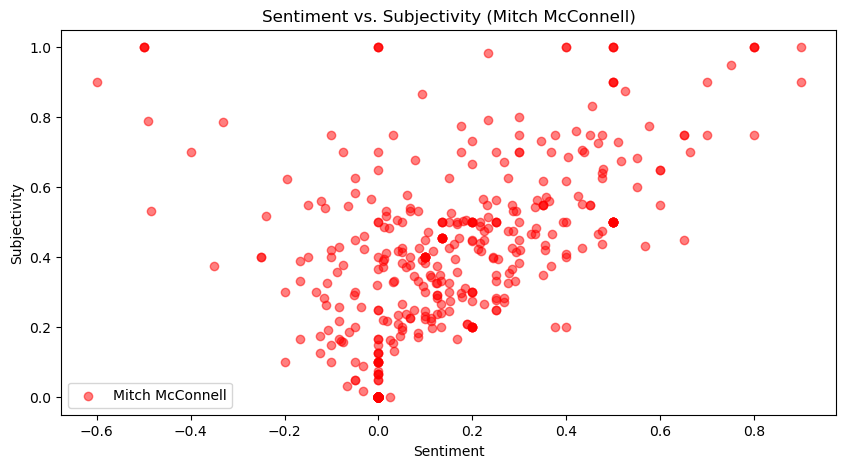

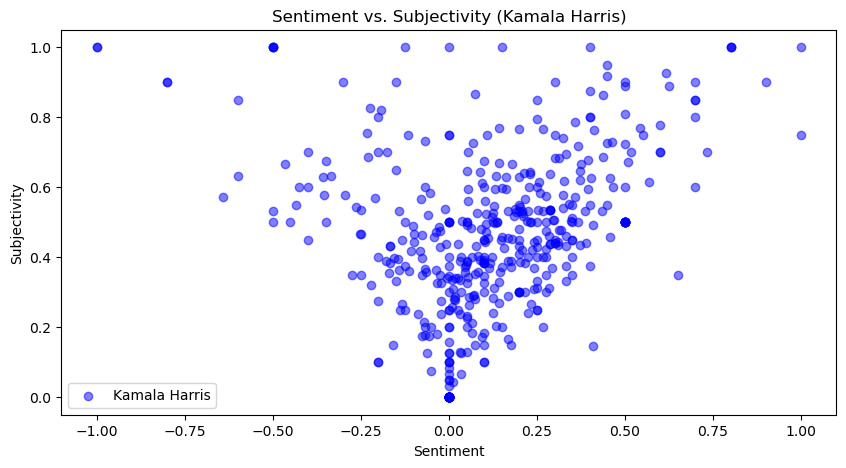

In [30]:
# Filtering dataset for Mitch McConnell and Kamala Harris
mcconnell_tweets = congress_tweets[congress_tweets['name_wikipedia'] == 'Mitch McConnell']
harris_tweets = congress_tweets[congress_tweets['name_wikipedia'] == 'Kamala Harris']

# Sentiment and subjectivity scores
def get_sentiment_subjectivity(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

# Sentiment and subjectivity scores for each tweat
mcconnell_tweets['sentiment'], mcconnell_tweets['subjectivity'] = zip(*mcconnell_tweets['text'].apply(get_sentiment_subjectivity))
harris_tweets['sentiment'], harris_tweets['subjectivity'] = zip(*harris_tweets['text'].apply(get_sentiment_subjectivity))

# Vis Mitch McConnell
plt.figure(figsize=(10, 5))
plt.scatter(mcconnell_tweets['sentiment'], mcconnell_tweets['subjectivity'], color='red', alpha=0.5, label='Mitch McConnell')
plt.title('Sentiment vs. Subjectivity (Mitch McConnell)')
plt.xlabel('Sentiment')
plt.ylabel('Subjectivity')
plt.legend()
plt.show()

# Vis Kamala Harris
plt.figure(figsize=(10, 5))
plt.scatter(harris_tweets['sentiment'], harris_tweets['subjectivity'], color='blue', alpha=0.5, label='Kamala Harris')
plt.title('Sentiment vs. Subjectivity (Kamala Harris)')
plt.xlabel('Sentiment')
plt.ylabel('Subjectivity')
plt.legend()
plt.show()

**Answer:** Mitch McConnell's tweets (red) display many values clustered around the middle, indicating a balance of positive and negative sentiment in tweeting language. This could suggest a mix of personal opinions and factual content.
Kamala Harris's tweets (blue) show a range of sentiment scores with a higher concentration in the slightly positive range. Many tweets show moderate to high subjectivity.
I would have assumed that Mitch McConnell's tweets are more subjective, toward a negative rhetoric. Kamala Harris' results slightly skewed towards positive sentiment do not surprise me based on her political communication in general. 

C:\Users\MSalman\AppData\Local\Temp\ipykernel_30472\3657766836.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mcconnell_tweets['sentiment'], shade=True, color="r", label="Mitch McConnell")
C:\Users\MSalman\AppData\Local\Temp\ipykernel_30472\3657766836.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(harris_tweets['sentiment'], shade=True, color="b", label="Kamala Harris")


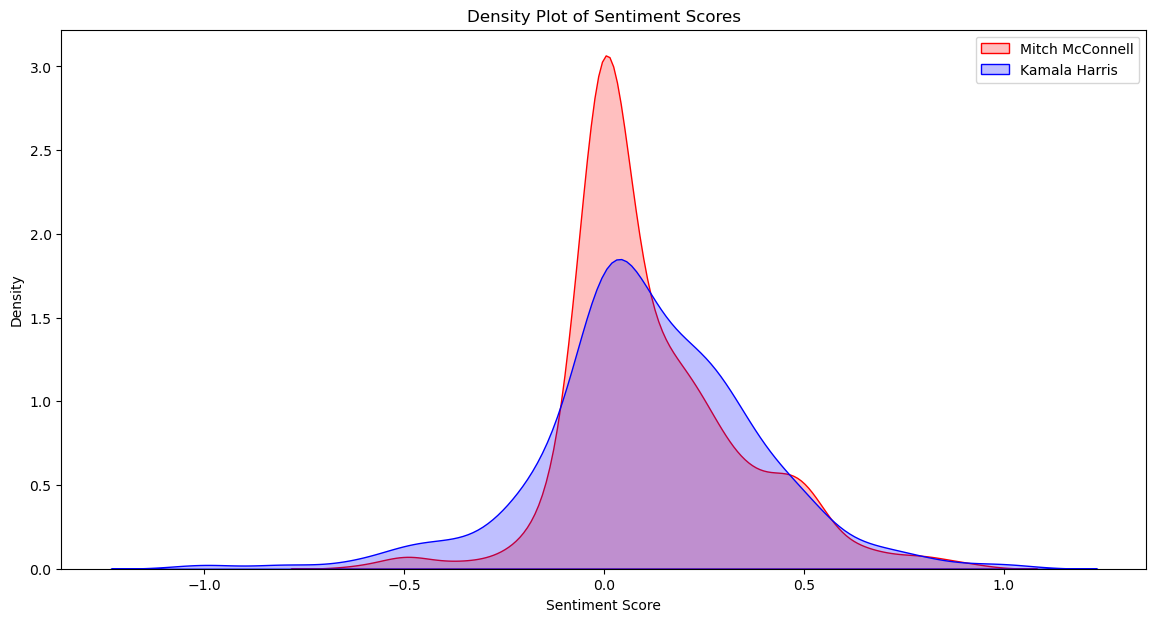

Test Statistic: 116726.0, P-Value: 0.3857697111507188


In [31]:
import seaborn as sns
from scipy import stats

# density plot
plt.figure(figsize=(14, 7))
sns.kdeplot(mcconnell_tweets['sentiment'], shade=True, color="r", label="Mitch McConnell")
sns.kdeplot(harris_tweets['sentiment'], shade=True, color="b", label="Kamala Harris")
plt.title('Density Plot of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()
plt.show()

# t-test # first, normality check 
_, p_value_norm_mcconnell = stats.normaltest(mcconnell_tweets['sentiment'])
_, p_value_norm_harris = stats.normaltest(harris_tweets['sentiment'])

alpha = 0.05  
if p_value_norm_mcconnell < alpha and p_value_norm_harris < alpha:
    stat, p_value = stats.mannwhitneyu(mcconnell_tweets['sentiment'], harris_tweets['sentiment'])
else:
    stat, p_value = stats.ttest_ind(mcconnell_tweets['sentiment'], harris_tweets['sentiment'])

print(f"Test Statistic: {stat}, P-Value: {p_value}")

#### Plot Democrats v. Republicans 

C:\Users\MSalman\AppData\Local\Temp\ipykernel_30472\2323718275.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  democrat_tweets[['sentiment', 'subjectivity']] = democrat_tweets['text'].apply(get_sentiment_subjectivity).apply(pd.Series)
C:\Users\MSalman\AppData\Local\Temp\ipykernel_30472\2323718275.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  democrat_tweets[['sentiment', 'subjectivity']] = democrat_tweets['text'].apply(get_sentiment_subjectivity).apply(pd.Series)
C:\Users\MSalman\AppData\Local\Tem

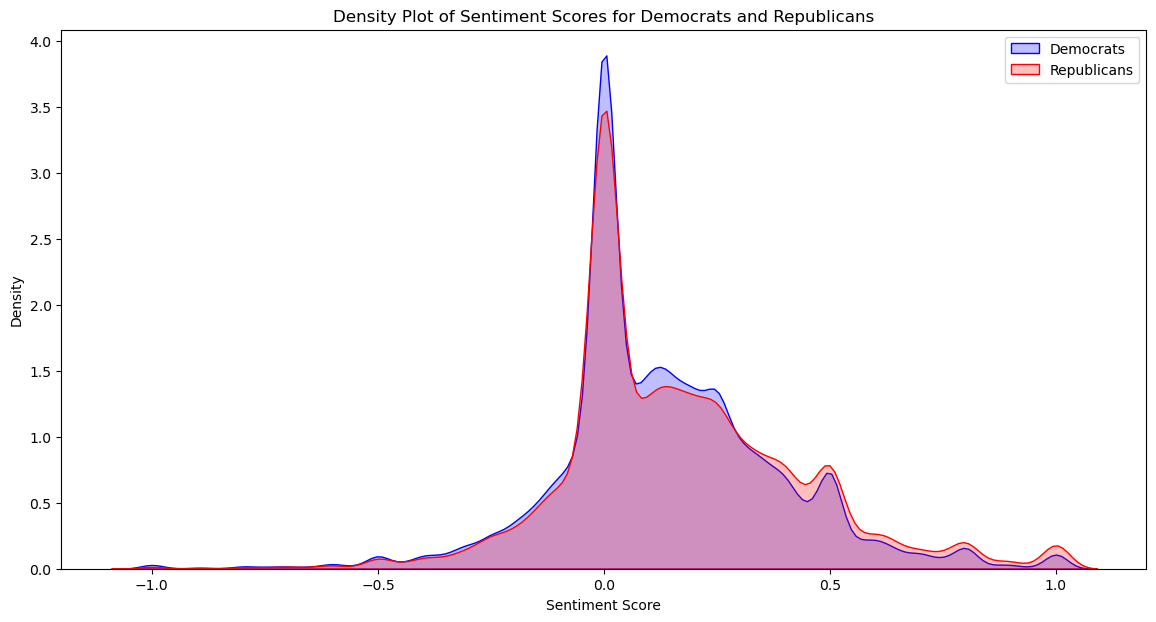

In [32]:
# Filtering tweets for democrats and republicans
democrat_tweets = congress_tweets[congress_tweets['party'] == 'Democrat']
republican_tweets = congress_tweets[congress_tweets['party'] == 'Republican']

# Get sentiment and subjectivity scores for each tweet
democrat_tweets[['sentiment', 'subjectivity']] = democrat_tweets['text'].apply(get_sentiment_subjectivity).apply(pd.Series)
republican_tweets[['sentiment', 'subjectivity']] = republican_tweets['text'].apply(get_sentiment_subjectivity).apply(pd.Series)

# Density plots for sentiment
plt.figure(figsize=(14, 7))
sns.kdeplot(democrat_tweets['sentiment'], shade=True, color="blue", label="Democrats")
sns.kdeplot(republican_tweets['sentiment'], shade=True, color="red", label="Republicans")
plt.title('Density Plot of Sentiment Scores for Democrats and Republicans')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()
plt.show()

In [33]:
from scipy.stats import ttest_ind, mannwhitneyu, normaltest

# Checking for normality
_, p_value_dem = normaltest(democrat_tweets['sentiment'])
_, p_value_rep = normaltest(republican_tweets['sentiment'])

# If both p-values >0.05, we can assume normality and thus use t-test. Othervise Mann-Whitney U test.
if p_value_dem > 0.05 and p_value_rep > 0.05:
    t_stat, p_value = ttest_ind(democrat_tweets['sentiment'], republican_tweets['sentiment'])
    print(f'T-test: statistic={t_stat}, p-value={p_value}')
else:
    u_stat, p_value = mannwhitneyu(democrat_tweets['sentiment'], republican_tweets['sentiment'])
    print(f'Mann-Whitney U test: statistic={u_stat}, p-value={p_value}')

Mann-Whitney U test: statistic=2432866738.0, p-value=5.634588510599623e-57


#### Plot Senators v. Representatives

In [34]:
# Filtering tweets for democrats and republicans
senator_tweets = congress_tweets[congress_tweets['position'] == 'Rep']
representative_tweets = congress_tweets[congress_tweets['position'] == 'Sen']

In [35]:
# Get sentiment and subjectivity scores for each tweet
democrat_tweets[['sentiment', 'subjectivity']] = democrat_tweets['text'].apply(get_sentiment_subjectivity).apply(pd.Series)
republican_tweets[['sentiment', 'subjectivity']] = republican_tweets['text'].apply(get_sentiment_subjectivity).apply(pd.Series)

C:\Users\MSalman\AppData\Local\Temp\ipykernel_30472\1134946856.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  democrat_tweets[['sentiment', 'subjectivity']] = democrat_tweets['text'].apply(get_sentiment_subjectivity).apply(pd.Series)
C:\Users\MSalman\AppData\Local\Temp\ipykernel_30472\1134946856.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  republican_tweets[['sentiment', 'subjectivity']] = republican_tweets['text'].apply(get_sentiment_subjectivity).apply(pd.Series)


C:\Users\MSalman\AppData\Local\Temp\ipykernel_30472\840145402.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(democrat_tweets['sentiment'], shade=True, color="blue", label="Rep")
C:\Users\MSalman\AppData\Local\Temp\ipykernel_30472\840145402.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(republican_tweets['sentiment'], shade=True, color="red", label="Sen")


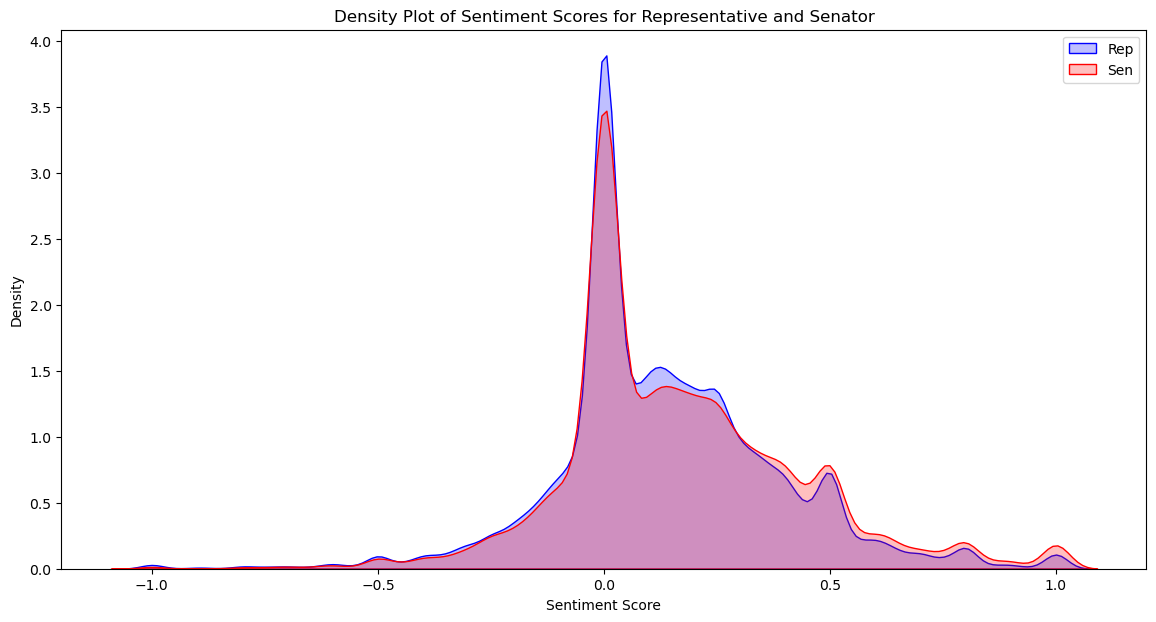

In [36]:
# Density plots for sentiment
plt.figure(figsize=(14, 7))
sns.kdeplot(democrat_tweets['sentiment'], shade=True, color="blue", label="Rep")
sns.kdeplot(republican_tweets['sentiment'], shade=True, color="red", label="Sen")
plt.title('Density Plot of Sentiment Scores for Representative and Senator')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()
plt.show()

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [37]:
# Apply LDA transformation to the tf-idf matrix from earlier
tfidf_matrix_subset = tfidf_vectorizer.transform(subset_congress_tweets['text'])
topic_distribution_subset = lda_model.transform(tfidf_matrix_subset)

In [38]:
# Convert topic distribution into df and reset index
topic_dist_df_subset = pd.DataFrame(topic_distribution_subset).reset_index(drop=True)

In [39]:
print(topic_dist_df_subset.head())

          0         1         2         3         4         5         6  \
0  0.652014  0.020671  0.020671  0.020671  0.091813  0.111477  0.020671   
1  0.305633  0.023320  0.023320  0.023320  0.023320  0.507809  0.023320   
2  0.752837  0.019196  0.019196  0.019196  0.019196  0.093594  0.019196   
3  0.533492  0.023853  0.023853  0.023853  0.023853  0.275686  0.023853   
4  0.499949  0.122181  0.021544  0.021544  0.021544  0.227062  0.021544   

          7         8         9  
0  0.020671  0.020671  0.020671  
1  0.023320  0.023320  0.023320  
2  0.019196  0.019196  0.019196  
3  0.023853  0.023853  0.023853  
4  0.021544  0.021544  0.021544  


### Tf-idf

In [40]:
tfidf_df_subset = pd.DataFrame(tfidf_matrix_subset.todense(),
                               columns=tfidf_vectorizer.get_feature_names_out())
print(tfidf_df_subset.head())

   aampm  aampmcommerce  aapi  aapiequalpay  aapis  aaron  aaronblake  aarpca  \
0    0.0            0.0   0.0           0.0    0.0    0.0         0.0     0.0   
1    0.0            0.0   0.0           0.0    0.0    0.0         0.0     0.0   
2    0.0            0.0   0.0           0.0    0.0    0.0         0.0     0.0   
3    0.0            0.0   0.0           0.0    0.0    0.0         0.0     0.0   
4    0.0            0.0   0.0           0.0    0.0    0.0         0.0     0.0   

   abandon  abbott  ...  𝘮𝘰𝘳𝘦  𝘯𝘰𝘵𝘦𝘴  𝘳𝘦𝘴𝘰𝘶𝘳𝘤𝘦𝘴  𝘵𝘪𝘱𝘴  𝙁𝙧𝙤𝙢  𝙎𝙪𝙗𝙟𝙚𝙘𝙩   𝙏𝙤  \
0      0.0     0.0  ...   0.0    0.0        0.0   0.0   0.0      0.0  0.0   
1      0.0     0.0  ...   0.0    0.0        0.0   0.0   0.0      0.0  0.0   
2      0.0     0.0  ...   0.0    0.0        0.0   0.0   0.0      0.0  0.0   
3      0.0     0.0  ...   0.0    0.0        0.0   0.0   0.0      0.0  0.0   
4      0.0     0.0  ...   0.0    0.0        0.0   0.0   0.0      0.0  0.0   

   𝙖𝙗𝙤𝙧𝙩𝙞𝙤𝙣  𝙖𝙡𝙡  𝙛𝙖𝙢𝙞𝙡𝙮  
0       0.0  0.0     0.

In [41]:
# All the zero values made me sus. Thus, I made sure there are non-zero values in the df.
non_zero_counts = (tfidf_df_subset != 0).sum(axis=1)
print(non_zero_counts)

0       16
1       11
2       19
3       11
4       15
        ..
4995    18
4996    20
4997    11
4998    11
4999    20
Length: 5000, dtype: int64


### Word Embedding

In [42]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

#model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [43]:
import gensim

# tokenize text data
subset_congress_tweets['tokens'] = subset_congress_tweets['text'].apply(rem_punc_stop_lemmatize)

# Train the Word2Vec model
model = gensim.models.Word2Vec(subset_congress_tweets['tokens'], 
                               vector_size=100,   
                               window=5,          
                               min_count=5,       
                               sg=0,    
                               alpha=0.025,
                               epochs=5,   
                               seed=1,      
                               batch_words=10000, 
                               workers=1) 


In [44]:
subset_congress_tweets['tokens'] = subset_congress_tweets['text'].apply(rem_punc_stop_lemmatize)

In [45]:
# Train the Word2Vec model on the tokenized text
word2vec_model = gensim.models.Word2Vec(subset_congress_tweets['tokens'],
                                        vector_size=100,  
                                        window=5,     
                                        min_count=5,    
                                        sg=0,            
                                        alpha=0.025,   
                                        epochs=5,   
                                        seed=1,      
                                        workers=1)      

In [46]:
# Define a function to average Word2Vec vectors for a single document
def document_vector(word2vec_model, tokens):
    # filter the words that are not in the Word2Vec model's vocabulary
    tokens = [token for token in tokens if token in word2vec_model.wv.index_to_key]
    
    # if no words remain after filtering, return a zero vector
    if len(tokens) == 0:
        return np.zeros(word2vec_model.vector_size)
    
    # average the word vectors for a document
    doc_vector = np.mean(word2vec_model.wv[tokens], axis=0)
    return doc_vector

In [47]:
# Apply the function to each row in the df
doc_vectors = subset_congress_tweets['tokens'].apply(lambda tokens: document_vector(word2vec_model, tokens))

In [48]:
# Create a df from the document vectors
doc_vectors_df = pd.DataFrame(doc_vectors.tolist())

# Each row represents a document in my dataset. Each column is one of the 100 dimensions of the Word2Vec feature space.

In [49]:
print(doc_vectors_df.head())

         0         1         2         3         4         5         6   \
0 -0.319622  0.410228  0.205843  0.002262  0.065485 -0.573469  0.196795   
1 -0.298212  0.379517  0.194296  0.003788  0.057989 -0.547642  0.187686   
2 -0.273079  0.372893  0.182185 -0.000668  0.057725 -0.517415  0.185284   
3 -0.240146  0.305623  0.150219 -0.003456  0.051421 -0.433672  0.146074   
4 -0.240018  0.323187  0.157447 -0.004664  0.051075 -0.449190  0.153335   

         7         8         9   ...        90        91        92        93  \
0  0.775958 -0.208283 -0.183888  ...  0.398849  0.073703  0.040440 -0.000272   
1  0.727151 -0.187320 -0.168645  ...  0.378163  0.071948  0.036607  0.002688   
2  0.686526 -0.186590 -0.169997  ...  0.370043  0.070325  0.024559 -0.003347   
3  0.578357 -0.158946 -0.139319  ...  0.310107  0.064871  0.027273  0.000036   
4  0.598594 -0.161384 -0.141782  ...  0.323284  0.066651  0.024494 -0.000909   

         94        95        96        97        98        99  
0  0

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [50]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])
...

In [51]:
y_party = subset_congress_tweets['party']
y_position = subset_congress_tweets['position']

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

def split_and_train(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)  # This line was missing
    accuracy = model.score(X_test, y_test)
    print(f'Accuracy: {accuracy}')
    print(classification_report(y_test, y_pred))  # Now y_pred is defined

# Runing predictions and report results
print("Topic Modeling Features")
print("Predicting Party")
split_and_train(topic_dist_df_subset, y_party)
print("Predicting Position")
split_and_train(topic_dist_df_subset, y_position)

Topic Modeling Features
Predicting Party
Accuracy: 0.614
              precision    recall  f1-score   support

    Democrat       0.62      0.98      0.76       617
  Republican       0.44      0.03      0.05       383

    accuracy                           0.61      1000
   macro avg       0.53      0.50      0.41      1000
weighted avg       0.55      0.61      0.49      1000

Predicting Position
Accuracy: 0.757
              precision    recall  f1-score   support

         Rep       0.76      1.00      0.86       757
         Sen       0.00      0.00      0.00       243

    accuracy                           0.76      1000
   macro avg       0.38      0.50      0.43      1000
weighted avg       0.57      0.76      0.65      1000



C:\Users\MSalman\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSalman\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSalman\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [53]:
# Using tf-idf features to predict party and position
print("\nTF-IDF Features")
print("Predicting Party")
split_and_train(tfidf_df_subset, y_party)
print("Predicting Position")
split_and_train(tfidf_df_subset, y_position)


TF-IDF Features
Predicting Party
Accuracy: 0.722
              precision    recall  f1-score   support

    Democrat       0.71      0.94      0.81       617
  Republican       0.78      0.38      0.51       383

    accuracy                           0.72      1000
   macro avg       0.75      0.66      0.66      1000
weighted avg       0.74      0.72      0.69      1000

Predicting Position
Accuracy: 0.758
              precision    recall  f1-score   support

         Rep       0.76      1.00      0.86       757
         Sen       0.60      0.01      0.02       243

    accuracy                           0.76      1000
   macro avg       0.68      0.50      0.44      1000
weighted avg       0.72      0.76      0.66      1000



In [54]:
# Using Word2Vec features to predict party and position
print("\nWord2Vec Features")
print("Predicting Party")
split_and_train(doc_vectors_df, y_party)
print("Predicting Position")
split_and_train(doc_vectors_df, y_position)


Word2Vec Features
Predicting Party
Accuracy: 0.617
              precision    recall  f1-score   support

    Democrat       0.62      1.00      0.76       617
  Republican       0.00      0.00      0.00       383

    accuracy                           0.62      1000
   macro avg       0.31      0.50      0.38      1000
weighted avg       0.38      0.62      0.47      1000

Predicting Position


C:\Users\MSalman\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSalman\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSalman\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.757
              precision    recall  f1-score   support

         Rep       0.76      1.00      0.86       757
         Sen       0.00      0.00      0.00       243

    accuracy                           0.76      1000
   macro avg       0.38      0.50      0.43      1000
weighted avg       0.57      0.76      0.65      1000



C:\Users\MSalman\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSalman\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSalman\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Two Combined Models

In [55]:
subset_congress_tweets.columns

Index(['tweet_id', 'screen_name', 'datetime', 'text', 'name_wikipedia',
       'position', 'joined_congress_date', 'birthday', 'gender', 'state',
       'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'tokens'],
      dtype='object')

In [56]:
tfidf_features = tfidf_vectorizer.get_feature_names_out()

# display some features
print(tfidf_features[:10])  

['aampm' 'aampmcommerce' 'aapi' 'aapiequalpay' 'aapis' 'aaron'
 'aaronblake' 'aarpca' 'abandon' 'abbott']


In [57]:
# However, I want some features randomly and just simply the first 10
tfidf_features = tfidf_vectorizer.get_feature_names_out()
# Generating 10 random unique indices
random_indices = np.random.choice(len(tfidf_features), 10, replace=False)
# Using them to select features
random_features = tfidf_features[random_indices]
print(random_features)

['vastly' 'bombing' 'donate' 'overstate' 'distribución' 'snlyngaas'
 'nemour' 'presentation' 'engage' 'greenhouse']


In [58]:
non_text_features = subset_congress_tweets[['gender', 'state', 'district_number', 'party', 'trump_2016_state_share', 'clinton_2016_state_share', 'obama_2012_state_share', 'romney_2012_state_share']]

In [59]:
# dummies of non-text features
non_text_features_dummies = pd.get_dummies(non_text_features).reset_index(drop=True)

In [60]:
# Non-text features + tfidf
# --------
tfidf_df = pd.DataFrame(tfidf_matrix_small.todense(), 
                        columns=tfidf_vectorizer.get_feature_names_out())

In [61]:
from textblob import TextBlob
import pandas as pd

# Calc sentiment and subjectivity
subset_congress_tweets[['sentiment', 'subjectivity']] = subset_congress_tweets['text'].apply(
    lambda x: pd.Series(get_sentiment_subjectivity(x))
)

# merging this with my topic modeling features
# Ensure that the 'topic_dist_df_subset' DataFrame is indexed in the same way as 'congress_tweets'
engineered_features_with_topics = topic_dist_df_subset.join(
    subset_congress_tweets[['sentiment', 'subjectivity']],
    how='inner'
)

# Confirming the dimensions to ensure the join was successful
print(engineered_features_with_topics.shape)

# 'engineered_features_with_topics' includes the sentiment, subjectivity, and topic features.

(22, 12)


In [62]:
# Non-text features + engineered features
# --------
# combine non-text features + engineered features
non_text_engineered_features = non_text_features_dummies.reset_index(drop=True).join(engineered_features_with_topics)

In [63]:
engineered_features_with_topics = topic_dist_df_subset.join(non_text_features_dummies.reset_index(drop=True))

In [64]:
# combine non-text features with tf-idf  
non_text_plus_tfidf = non_text_features_dummies.reset_index(drop=True).join(tfidf_df)

In [65]:
print(non_text_plus_tfidf.head())

   gender_F  gender_M  state_AK  state_AL  state_AR  state_AZ  state_CA  \
0      True     False     False     False     False     False     False   
1     False      True     False     False     False     False     False   
2     False      True     False     False      True     False     False   
3     False      True     False     False     False     False     False   
4     False      True     False     False     False     False      True   

   state_CO  state_CT  state_DC  ...  𝘮𝘰𝘳𝘦  𝘯𝘰𝘵𝘦𝘴  𝘳𝘦𝘴𝘰𝘶𝘳𝘤𝘦𝘴  𝘵𝘪𝘱𝘴  𝙁𝙧𝙤𝙢  \
0     False     False     False  ...   0.0    0.0        0.0   0.0   0.0   
1     False     False     False  ...   0.0    0.0        0.0   0.0   0.0   
2     False     False     False  ...   0.0    0.0        0.0   0.0   0.0   
3     False     False     False  ...   0.0    0.0        0.0   0.0   0.0   
4     False     False     False  ...   0.0    0.0        0.0   0.0   0.0   

   𝙎𝙪𝙗𝙟𝙚𝙘𝙩   𝙏𝙤  𝙖𝙗𝙤𝙧𝙩𝙞𝙤𝙣  𝙖𝙡𝙡  𝙛𝙖𝙢𝙞𝙡𝙮  
0      0.0  0.0       0.0  0.0     0.0  
1      0.0

In [66]:
# Again, I wasn't sure if I did this right because of all the zero-values. 
# Get a boolean DataFrame where True indicates non-zero values
non_zero_mask = non_text_plus_tfidf.astype(bool)
non_zero_counts_per_row = non_zero_mask.sum(axis=1)
for i in non_text_plus_tfidf.index:
    if non_zero_counts_per_row[i] > 0:
        print(f"Row {i} non-zero values:")
        print(non_text_plus_tfidf.loc[i][non_zero_mask.loc[i]])
        print()  # Add a newline for better readability

Row 0 non-zero values:
gender_F                                  True
state_FL                                  True
district_number_10                        True
party_Democrat                            True
trump_2016_state_share_4,617,886          True
clinton_2016_state_share_4,504,975        True
obama_2012_state_share_4,237,756          True
romney_2012_state_share_4,163,447         True
act                                   0.146423
bill                                   0.15493
final                                 0.274109
forward                               0.392059
georgia                               0.299271
include                               0.185346
land                                  0.242718
look                                  0.185895
management                            0.287968
natural                               0.260251
package                               0.234304
preserve                              0.263758
protect                              

gender_M                                True
state_AK                                True
district_number_Senate                  True
party_Republican                        True
trump_2016_state_share_163,387          True
clinton_2016_state_share_116,454        True
obama_2012_state_share_122,640          True
romney_2012_state_share_164,676         True
realdonaldtrump                      0.86341
rt                                  0.504503
Name: 13, dtype: object

Row 14 non-zero values:
gender_M                                  True
state_AZ                                  True
district_number_6                         True
party_Republican                          True
trump_2016_state_share_1,252,401          True
clinton_2016_state_share_1,161,167        True
obama_2012_state_share_1,025,232          True
romney_2012_state_share_1,233,654         True
access                                0.194119
act                                   0.147798
bipartisan                     

gender_M                                  True
state_IN                                  True
district_number_7                         True
party_Democrat                            True
trump_2016_state_share_1,557,286          True
clinton_2016_state_share_1,033,126        True
obama_2012_state_share_1,152,887          True
romney_2012_state_share_1,420,543         True
fox                                   0.324728
judgment                              0.385252
ken                                   0.397812
news                                   0.21624
poor                                  0.333794
rt                                    0.107374
say                                   0.195891
starr                                 0.385252
think                                 0.237125
trumps                                0.288128
tweet                                 0.303532
Name: 29, dtype: object

Row 30 non-zero values:
gender_F                                  True
state_FL   

gender_M                                  True
state_FL                                  True
district_number_3                         True
party_Republican                          True
trump_2016_state_share_4,617,886          True
clinton_2016_state_share_4,504,975        True
obama_2012_state_share_4,237,756          True
romney_2012_state_share_4,163,447         True
american                               0.11999
artemis                               0.276306
ensure                                0.133713
finally                               0.180237
flag                                  0.408412
man                                   0.161591
mar                                   0.517565
moon                                  0.474157
nasa                                  0.215374
plant                                 0.224382
program                               0.144881
sotu                                  0.190992
woman                                  0.13813
Name: 42, dty

gender_M                                  True
state_CA                                  True
district_number_49                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
act                                    0.09354
amp                                    0.22146
anticorruption                        0.221513
bank                                  0.332513
big                                   0.265825
bill                                  0.098974
break                                  0.13447
door                                  0.170946
end                                   0.118756
enforce                               0.191184
executive                             0.164693
handcuff                              0.239752
jail                                  0.203275
law          

gender_M                                  True
state_NY                                  True
district_number_1                         True
party_Republican                          True
trump_2016_state_share_2,819,533          True
clinton_2016_state_share_4,556,118        True
obama_2012_state_share_4,485,741          True
romney_2012_state_share_2,490,431         True
alongside                             0.206135
antilynching                          0.282043
attempt                               0.384881
come                                  0.138217
corybooker                            0.259888
day                                   0.247171
finally                                0.18398
floyds                                0.291238
george                                0.206135
kamalaharris                          0.242002
legislation                           0.142082
memorial                              0.209256
pass                                  0.125317
person       

gender_M                                  True
state_CA                                  True
district_number_15                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
america                               0.082328
amp                                   0.053276
celebrate                             0.092442
continue                              0.072897
cuba                                  0.450494
cuban                                 0.450494
day                                   0.146847
democracy                             0.208576
end                                   0.085705
fortunately                           0.167564
free                                  0.099916
freedom                               0.104288
hope                                  0.099124
horror       

gender_M                                True
state_MT                                True
district_number_Senate                  True
party_Republican                        True
trump_2016_state_share_279,240          True
clinton_2016_state_share_177,709        True
obama_2012_state_share_201,839          True
romney_2012_state_share_267,928         True
act                                 0.177868
benefit                             0.249941
care                                0.203341
economic                            0.240548
effort                              0.235616
ensure                              0.213655
exactly                             0.334426
impact                              0.247552
imperative                           0.37214
irs                                 0.340688
know                                0.215808
need                                0.166306
payment                             0.292244
receive                             0.236647
sign      

gender_M                                  True
state_IL                                  True
district_number_16                        True
party_Republican                          True
trump_2016_state_share_2,146,015          True
clinton_2016_state_share_3,090,729        True
obama_2012_state_share_3,019,512          True
romney_2012_state_share_2,135,216         True
allocate                              0.423636
battle                                0.359345
continue                              0.208161
coronavirus                           0.235552
distribute                            0.374945
florida                               0.340458
hhsgov                                0.359345
hospital                              0.307301
million                               0.234337
pandemic                              0.240033
Name: 109, dtype: object

Row 110 non-zero values:
gender_F                                  True
state_TX                                  True
district_

gender_F                                  True
state_MN                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_1,322,951          True
clinton_2016_state_share_1,367,716        True
obama_2012_state_share_1,546,167          True
romney_2012_state_share_1,320,225         True
aapis                                  0.21633
amp                                   0.133217
antiasian                              0.21633
carrier                               0.181517
china                                 0.133079
colleague                             0.114038
come                                  0.102667
condemn                               0.152037
coronavirus                           0.103133
country                               0.095059
dangerous                             0.138675
describe                              0.190247
flu                                   0.179757
hate         

gender_M                                  True
state_CA                                  True
district_number_39                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
amp                                   0.186115
beaumont                               0.30223
clear                                 0.175722
commitment                             0.19291
congratulation                        0.183368
display                               0.244695
federal                               0.140022
great                                 0.133754
judge                                 0.404633
judgment                              0.292688
know                                  0.143067
law                                   0.146421
president                             0.119624
privilege    

gender_F                                  True
state_WA                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_1,221,747          True
clinton_2016_state_share_1,742,718        True
obama_2012_state_share_1,755,396          True
romney_2012_state_share_1,290,670         True
donald                                0.382302
housejudiciary                        0.396032
impeachment                           0.312089
j                                     0.509626
president                             0.226044
rt                                    0.154147
senate                                 0.25719
trial                                 0.388792
trump                                 0.218455
Name: 159, dtype: object

Row 160 non-zero values:
gender_F                                  True
state_WI                                  True
district_number_4                         True
party_Dem

gender_M                                  True
state_VA                                  True
district_number_5                         True
party_Republican                          True
trump_2016_state_share_1,769,443          True
clinton_2016_state_share_1,981,473        True
obama_2012_state_share_1,971,820          True
romney_2012_state_share_1,822,522         True
commuter                              0.276107
help                                  0.107734
industry                              0.174464
maryland                              0.469498
million                               0.135221
network                               0.229044
passenger                             0.241731
rail                                  0.488908
read                                  0.144426
receive                               0.147995
safe                                  0.142618
support                               0.114501
thrilled                              0.230833
upgrade      

gender_M                                  True
state_TX                                  True
district_number_17                        True
party_Republican                          True
trump_2016_state_share_4,685,047          True
clinton_2016_state_share_3,877,868        True
obama_2012_state_share_3,308,124          True
romney_2012_state_share_4,569,843         True
area                                  0.202697
bay                                   0.276671
crew                                  0.269576
customer                              0.267487
daylight                              0.332961
inspection                             0.29712
line                                  0.199089
live                                  0.162551
pgampe                                0.322449
power                                 0.371303
restoration                           0.285483
resume                                0.282304
rt                                     0.08987
service      

gender_M                                  True
state_PA                                  True
district_number_13                        True
party_Republican                          True
trump_2016_state_share_2,970,733          True
clinton_2016_state_share_2,926,441        True
obama_2012_state_share_2,990,274          True
romney_2012_state_share_2,680,434         True
access                                0.187823
brave                                 0.244708
care                                  0.326968
child                                 0.191799
ensure                                0.171777
health                                 0.15087
honorably                             0.354962
legislation                           0.178816
mental                                0.247391
nation                                0.173177
need                                  0.133708
permanent                              0.27391
receive                               0.190262
right        

gender_F                                  True
state_MA                                  True
district_number_5                         True
party_Democrat                            True
trump_2016_state_share_1,090,893          True
clinton_2016_state_share_1,995,196        True
obama_2012_state_share_1,921,290          True
romney_2012_state_share_1,188,314         True
amp                                   0.137437
attack                                 0.26817
court                                 0.251564
crisis                                0.216101
defend                                0.289339
fundamental                           0.336948
government                            0.229311
house                                 0.182743
pleased                               0.317085
right                                 0.195356
single                                0.306623
state                                 0.194489
supreme                                0.28552
worship      

gender_M                                  True
state_MI                                  True
district_number_2                         True
party_Republican                          True
trump_2016_state_share_2,279,543          True
clinton_2016_state_share_2,268,839        True
obama_2012_state_share_2,564,569          True
romney_2012_state_share_2,115,256         True
belong                                0.335197
country                               0.343571
home                                  0.397361
mountain                               0.32189
place                                 0.219008
road                                  0.549508
rt                                     0.10552
virginia                              0.269384
west                                  0.272888
Name: 240, dtype: object

Row 241 non-zero values:
gender_M                                  True
state_MD                                  True
district_number_5                         True
party_Dem

gender_F                                True
state_ME                                True
district_number_Senate                  True
party_Republican                        True
trump_2016_state_share_335,593          True
clinton_2016_state_share_357,735        True
obama_2012_state_share_401,306          True
romney_2012_state_share_292,276         True
address                             0.118818
advanced                            0.189359
alter                               0.227886
amp                                 0.070166
animal                              0.193214
burden                              0.179219
developer                           0.227886
dna                                 0.227886
draft                               0.180439
engineering                         0.197774
fda                                 0.184503
genome                              0.227886
guidance                            0.169478
issue                                0.11507
new       

gender_M                                  True
state_AZ                                  True
district_number_4                         True
party_Republican                          True
trump_2016_state_share_1,252,401          True
clinton_2016_state_share_1,161,167        True
obama_2012_state_share_1,025,232          True
romney_2012_state_share_1,233,654         True
accord                                  0.1658
act                                   0.088943
action                                0.118756
american                              0.095874
amp                                   0.070193
attack                                0.136961
authorize                             0.173942
briefing                              0.164448
brink                                 0.220773
chance                                0.154303
check                                 0.124049
congress                              0.098186
constitutionally                      0.220773
evidence     

gender_F                                  True
state_TX                                  True
district_number_29                        True
party_Democrat                            True
trump_2016_state_share_4,685,047          True
clinton_2016_state_share_3,877,868        True
obama_2012_state_share_3,308,124          True
romney_2012_state_share_4,569,843         True
afghanistan                           0.339074
current                               0.289933
forget                                0.270562
get                                   0.225719
hall                                  0.253573
involvement                           0.361886
ready                                 0.269979
simply                                 0.29175
start                                 0.234253
state                                 0.183903
town                                  0.253573
wage                                  0.276164
war                                   0.256078
year         

gender_F                                  True
state_TX                                  True
district_number_16                        True
party_Democrat                            True
trump_2016_state_share_4,685,047          True
clinton_2016_state_share_3,877,868        True
obama_2012_state_share_3,308,124          True
romney_2012_state_share_4,569,843         True
blsdata                                0.31858
blsgov                                 0.31858
employment                            0.255934
force                                 0.173908
graphic                                0.30072
grow                                  0.200054
interactive                            0.30072
labor                                 0.223129
nation                                 0.15052
new                                   0.135435
pace                                   0.30072
qt                                    0.103584
state                                 0.277621
today        

gender_M                                  True
state_IN                                  True
district_number_3                         True
party_Republican                          True
trump_2016_state_share_1,557,286          True
clinton_2016_state_share_1,033,126        True
obama_2012_state_share_1,152,887          True
romney_2012_state_share_1,420,543         True
career                                0.299758
employer                              0.331213
govmikedewine                          0.41148
help                                  0.168288
identify                               0.33981
new                                   0.189331
ohio                                  0.305931
opportunity                           0.240828
place                                 0.249492
rt                                    0.120208
train                                 0.350248
work                                  0.317062
Name: 318, dtype: object

Row 319 non-zero values:
gender_F 

gender_F                                True
state_OK                                True
district_number_5                       True
party_Democrat                          True
trump_2016_state_share_949,136          True
clinton_2016_state_share_420,375        True
obama_2012_state_share_443,547          True
romney_2012_state_share_891,325         True
backbone                            0.214314
biz                                 0.223838
clinic                               0.20152
community                           0.101591
coop                                0.257918
critical                            0.139042
electric                            0.249775
energy                              0.157281
essential                           0.164279
health                              0.106162
manufacturer                        0.207201
partnership                         0.186805
product                             0.186805
provider                            0.180033
providers 

gender_M                                  True
state_MD                                  True
district_number_2                         True
party_Democrat                            True
trump_2016_state_share_943,169            True
clinton_2016_state_share_1,677,928        True
obama_2012_state_share_1,677,844          True
romney_2012_state_share_971,869           True
amp                                   0.247266
child                                 0.140076
demolish                              0.267689
dignity                               0.190866
drastically                           0.259237
entire                                0.174734
family                                0.106882
goal                                  0.187486
harm                                   0.18563
human                                  0.16649
israel                                0.203139
needlessly                            0.259237
palestinian                           0.252682
peace        

gender_M                                  True
state_NY                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_2,819,533          True
clinton_2016_state_share_4,556,118        True
obama_2012_state_share_4,485,741          True
romney_2012_state_share_2,490,431         True
arizona                               0.272176
attorney                              0.273801
bailey                                0.399803
chief                                 0.281967
deputy                                 0.15619
district                              0.223181
gain                                    0.1442
generalbrnovich                       0.417593
honorably                              0.19359
incredibly                            0.145386
loss                                  0.133109
michael                               0.306771
nominate                              0.155215
proud        

gender_M                                  True
state_FL                                  True
district_number_Senate                    True
party_Republican                          True
trump_2016_state_share_4,617,886          True
clinton_2016_state_share_4,504,975        True
obama_2012_state_share_4,237,756          True
romney_2012_state_share_4,163,447         True
detain                                 0.24147
ice                                    0.21673
investigate                           0.203814
joaquincastrotx                       0.218435
meet                                  0.161622
repbarragan                           0.256742
repespaillat                          0.243267
rephankjohnson                        0.266302
repjayapal                            0.219321
repjimmygomez                         0.293252
repjuanvargas                         0.285836
reploucorrea                          0.302812
repsylviagarcia                       0.247181
rt           

gender_M                                  True
state_MD                                  True
district_number_2                         True
party_Democrat                            True
trump_2016_state_share_943,169            True
clinton_2016_state_share_1,677,928        True
obama_2012_state_share_1,677,844          True
romney_2012_state_share_971,869           True
bank                                  0.176389
belief                                0.218093
central                               0.166036
dangerous                             0.163055
deposit                               0.218093
economic                              0.268424
eliminate                             0.183486
fed                                   0.209435
federal                               0.117846
feds                                  0.246332
fringe                                0.240103
gold                                  0.196314
independence                          0.195174
insurance    

gender_M                                  True
state_TX                                  True
district_number_17                        True
party_Republican                          True
trump_2016_state_share_4,685,047          True
clinton_2016_state_share_3,877,868        True
obama_2012_state_share_3,308,124          True
romney_2012_state_share_4,569,843         True
american                              0.178906
conflict                              0.322823
decade                                0.277684
destabilize                           0.425405
endless                               0.356946
life                                  0.196277
nearly                                0.260769
region                                0.284012
risk                                  0.249445
threaten                              0.287126
troop                                  0.28253
war                                   0.258101
Name: 399, dtype: object

Row 400 non-zero values:
gender_M 

gender_M                                True
state_AR                                True
district_number_2                       True
party_Republican                        True
trump_2016_state_share_684,872          True
clinton_2016_state_share_380,494        True
obama_2012_state_share_394,409          True
romney_2012_state_share_647,744         True
abortion                            0.230952
appeal                              0.279773
big                                 0.180894
court                               0.183897
decision                             0.19161
dollar                              0.212493
federal                             0.151174
fund                                 0.17663
judge                                0.21843
law                                 0.158082
like                                0.155662
parenthood                          0.291177
plan                                0.171058
provider                            0.227766
reaffirm  

gender_M                                  True
state_CA                                  True
district_number_17                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
act                                   0.124534
allow                                  0.18334
brother                               0.251027
crisis                                0.154533
especially                            0.195663
exactly                               0.234148
food                                   0.18997
free                                   0.18432
kindness                              0.273679
lovene                                0.309116
maintain                              0.232146
nation                                 0.15081
nebraskan                             0.301299
overtime     

gender_M                                  True
state_AZ                                  True
district_number_5                         True
party_Republican                          True
trump_2016_state_share_1,252,401          True
clinton_2016_state_share_1,161,167        True
obama_2012_state_share_1,025,232          True
romney_2012_state_share_1,233,654         True
administrator                          0.23533
forward                               0.144978
great                                 0.122835
joint                                 0.221332
look                                  0.137483
mnuchin                               0.237981
monday                                0.200218
news                                  0.150874
paycheck                              0.173954
paycheckprotectionprogram             0.218284
program                               0.140943
protection                             0.15217
qt                                    0.090246
resumption   

gender_F                                  True
state_NY                                  True
district_number_21                        True
party_Republican                          True
trump_2016_state_share_2,819,533          True
clinton_2016_state_share_4,556,118        True
obama_2012_state_share_4,485,741          True
romney_2012_state_share_2,490,431         True
april                                 0.311878
community                             0.176574
eliminate                             0.323372
feature                                0.35495
fight                                 0.198391
help                                  0.169394
inspire                               0.295471
join                                  0.189116
leader                                0.240213
meeting                               0.279871
teamhorsford                          0.448285
violence                              0.256481
woman                                  0.21703
Name: 456, dt

gender_F                                  True
state_PA                                  True
district_number_6                         True
party_Democrat                            True
trump_2016_state_share_2,970,733          True
clinton_2016_state_share_2,926,441        True
obama_2012_state_share_2,990,274          True
romney_2012_state_share_2,680,434         True
act                                   0.122907
amp                                   0.290989
asylumseeker                          0.315023
basic                                 0.231088
cosponsor                             0.190811
detention                             0.233184
dignity                               0.224616
eliminate                             0.227243
end                                    0.15604
ensure                                0.147636
forprofit                             0.270103
human                                  0.19593
immigrant                             0.209765
mandatory    

gender_M                                  True
state_NC                                  True
district_number_8                         True
party_Republican                          True
trump_2016_state_share_2,362,631          True
clinton_2016_state_share_2,189,316        True
obama_2012_state_share_2,178,391          True
romney_2012_state_share_2,270,395         True
accord                                0.236478
acquittal                             0.325151
blessing                              0.265416
block                                 0.197942
call                                  0.170611
date                                  0.252466
defendant                             0.314885
end                                   0.161057
familiar                              0.294916
like                                  0.155114
mcconnell                             0.198622
qt                                    0.105721
right                                 0.142305
rt           

gender_M                                 True
state_LA                                 True
district_number_Senate                   True
party_Republican                         True
trump_2016_state_share_1,178,638         True
clinton_2016_state_share_780,154         True
obama_2012_state_share_809,141           True
romney_2012_state_share_1,152,262        True
adviser                              0.247944
afford                                0.19596
appropsdem                           0.213198
chief                                 0.19596
continue                              0.11706
damage                               0.192062
day                                  0.117905
economic                             0.146606
economist                            0.233139
economy                              0.145001
end                                  0.137628
endtheshutdown                       0.228775
growth                               0.194604
mexico                            

gender_M                                  True
state_MI                                  True
district_number_6                         True
party_Republican                          True
trump_2016_state_share_2,279,543          True
clinton_2016_state_share_2,268,839        True
obama_2012_state_share_2,564,569          True
romney_2012_state_share_2,115,256         True
beach                                 0.239953
competition                             0.2292
congratulation                        0.195757
dean                                  0.596209
good                                   0.15392
luck                                  0.253744
newport                               0.322649
represent                             0.201052
root                                  0.243558
scrippsbee                            0.322649
student                               0.164511
success                               0.228367
week                                  0.144444
Name: 516, dt

gender_M                                  True
state_MO                                  True
district_number_Senate                    True
party_Republican                          True
trump_2016_state_share_1,594,511          True
clinton_2016_state_share_1,071,068        True
obama_2012_state_share_1,223,796          True
romney_2012_state_share_1,482,440         True
democrat                              0.292107
failure                               0.365966
follow                                0.275208
house                                 0.197437
infrastructure                        0.294086
repespaillat                          0.387426
speak                                 0.254221
tantrum                               0.445572
today                                 0.159468
trump                                 0.184471
white                                 0.278109
work                                  0.171666
Name: 530, dtype: object

Row 531 non-zero values:
gender_M 

gender_M                                  True
state_CA                                  True
district_number_11                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
follow                                0.274106
m                                     0.236869
news                                  0.261093
officially                            0.372953
personal                              0.330975
repmarktakano                         0.422414
tiktok                                0.435662
verify                                0.428623
Name: 549, dtype: object

Row 550 non-zero values:
gender_M                                  True
state_FL                                  True
district_number_6                         True
party_Republican                          True
trump_201

gender_M                              True
state_MO                              True
district_number_6                     True
party_Republican                      True
trump_2016_state_share_1,594,511      True
clinton_2016_state_share_1,071,068    True
obama_2012_state_share_1,223,796      True
romney_2012_state_share_1,482,440     True
Name: 562, dtype: object

Row 563 non-zero values:
gender_M                                  True
state_CO                                  True
district_number_2                         True
party_Democrat                            True
trump_2016_state_share_1,202,484          True
clinton_2016_state_share_1,338,870        True
obama_2012_state_share_1,323,102          True
romney_2012_state_share_1,185,243         True
builder                               0.362201
driver                                   0.283
economy                               0.189019
educate                               0.300967
essential                             0.2

gender_M                                  True
state_NY                                  True
district_number_5                         True
party_Democrat                            True
trump_2016_state_share_2,819,533          True
clinton_2016_state_share_4,556,118        True
obama_2012_state_share_4,485,741          True
romney_2012_state_share_2,490,431         True
bring                                 0.260395
chuckgrassley                         0.410781
congress                               0.20867
cost                                   0.28747
drug                                  0.288793
forward                               0.253066
great                                 0.214415
look                                  0.239983
morning                               0.271416
office                                0.245824
prescription                          0.327007
visit                                 0.242355
way                                   0.238228
work         

gender_F                                  True
state_CA                                  True
district_number_12                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
cage                                  0.541205
fire                                  0.355212
inside                                0.479161
pilot                                 0.479161
set                                   0.348898
Name: 594, dtype: object

Row 595 non-zero values:
gender_M                                  True
state_IN                                  True
district_number_Senate                    True
party_Republican                          True
trump_2016_state_share_1,557,286          True
clinton_2016_state_share_1,033,126        True
obama_2012_state_share_1,152,887          True
romney_20

gender_M                                True
state_OK                                True
district_number_1                       True
party_Republican                        True
trump_2016_state_share_949,136          True
clinton_2016_state_share_420,375        True
obama_2012_state_share_443,547          True
romney_2012_state_share_891,325         True
accomplishment                      0.329861
brilliant                           0.378164
congratulation                      0.243066
education                           0.235254
future                              0.217313
mind                                0.313022
piratenationhs                      0.418451
rt                                  0.108133
stem                                0.299385
story                               0.231971
student                             0.204269
tell                                0.229212
young                               0.253081
Name: 608, dtype: object

Row 609 non-zero values:
gend

gender_M                                  True
state_PA                                  True
district_number_3                         True
party_Democrat                            True
trump_2016_state_share_2,970,733          True
clinton_2016_state_share_2,926,441        True
obama_2012_state_share_2,990,274          True
romney_2012_state_share_2,680,434         True
action                                0.263556
case                                  0.570272
continue                              0.213151
heroesact                             0.353156
house                                 0.207131
month                                 0.270568
pass                                  0.217699
refuse                                0.317083
republican                            0.302043
senate                                0.227843
today                                 0.167297
Name: 623, dtype: object

Row 624 non-zero values:
gender_M                                True
state_OK   

gender_M                                  True
state_AZ                                  True
district_number_4                         True
party_Republican                          True
trump_2016_state_share_1,252,401          True
clinton_2016_state_share_1,161,167        True
obama_2012_state_share_1,025,232          True
romney_2012_state_share_1,233,654         True
aid                                   0.222682
congress                              0.157276
continue                              0.153845
desk                                  0.289137
disaster                               0.23358
fight                                 0.161606
gt                                    0.270301
hurricanemichael                      0.337387
imperative                             0.29808
oped                                  0.271573
package                               0.227979
possible                              0.240093
president                             0.144534
read         

gender_F                                  True
state_IL                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_2,146,015          True
clinton_2016_state_share_3,090,729        True
obama_2012_state_share_3,019,512          True
romney_2012_state_share_2,135,216         True
awesome                               0.274965
brighten                              0.324306
case                                  0.182773
day                                   0.137618
design                                0.506784
grader                                0.299636
international                         0.233015
job                                   0.155736
know                                  0.153517
need                                  0.118304
patch                                 0.324306
root                                  0.244808
space                                 0.233015
station      

gender_M                                  True
state_PA                                  True
district_number_3                         True
party_Democrat                            True
trump_2016_state_share_2,970,733          True
clinton_2016_state_share_2,926,441        True
obama_2012_state_share_2,990,274          True
romney_2012_state_share_2,680,434         True
accomplish                            0.347121
congress                              0.193712
district                               0.25107
excited                               0.317202
fourth                                0.381335
representative                        0.285875
serve                                 0.229514
sixth                                 0.377384
term                                  0.351416
thrilled                              0.364142
Name: 672, dtype: object

Row 673 non-zero values:
gender_M                                  True
state_PA                                  True
district_

gender_M                                  True
state_AZ                                  True
district_number_5                         True
party_Republican                          True
trump_2016_state_share_1,252,401          True
clinton_2016_state_share_1,161,167        True
obama_2012_state_share_1,025,232          True
romney_2012_state_share_1,233,654         True
canyon                                0.441095
day                                   0.193279
fun                                   0.390528
grand                                 0.358205
memorial                              0.327261
open                                  0.256077
rt                                    0.122939
safe                                   0.22784
weekend                               0.308291
westerncaucus                         0.390528
Name: 692, dtype: object

Row 693 non-zero values:
gender_M                                  True
state_NJ                                  True
district_

gender_M                                True
state_AR                                True
district_number_1                       True
party_Republican                        True
trump_2016_state_share_684,872          True
clinton_2016_state_share_380,494        True
obama_2012_state_share_394,409          True
romney_2012_state_share_647,744         True
action                              0.178531
american                            0.144131
amp                                 0.105523
appreciate                          0.458838
ask                                 0.182921
depend                              0.254878
economy                             0.178851
grant                               0.210827
new                                 0.145696
office                              0.173889
place                               0.191992
president                           0.271297
realdonaldtrump                     0.158311
strength                            0.261494
suspend   

gender_M                                  True
state_CA                                  True
district_number_10                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
act                                   0.330676
climatecrisis                         0.633376
quickly                               0.606617
time                                  0.348574
Name: 722, dtype: object

Row 723 non-zero values:
gender_F                                  True
state_WI                                  True
district_number_4                         True
party_Democrat                            True
trump_2016_state_share_1,405,284          True
clinton_2016_state_share_1,382,536        True
obama_2012_state_share_1,620,985          True
romney_2012_state_share_1,407,966         True
access   

gender_M                                  True
state_NY                                  True
district_number_13                        True
party_Democrat                            True
trump_2016_state_share_2,819,533          True
clinton_2016_state_share_4,556,118        True
obama_2012_state_share_4,485,741          True
romney_2012_state_share_2,490,431         True
activity                              0.170221
amp                                   0.141612
billion                               0.135432
cargo                                 0.229962
catch                                 0.166557
consider                              0.151951
county                                0.124097
economic                              0.121337
engine                                0.197171
estate                                0.205208
generate                              0.202236
great                                 0.101771
job                                   0.110431
kristin      

gender_F                                  True
state_IN                                  True
district_number_2                         True
party_Republican                          True
trump_2016_state_share_1,557,286          True
clinton_2016_state_share_1,033,126        True
obama_2012_state_share_1,152,887          True
romney_2012_state_share_1,420,543         True
amp                                   0.240645
bridge                                0.287942
care                                  0.174299
community                             0.307848
count                                 0.247365
funding                               0.205237
help                                  0.147665
housing                               0.262303
inform                                0.305332
local                                 0.207367
program                               0.198437
public                                0.188163
road                                  0.274641
school       

gender_M                                 True
state_KY                                 True
district_number_Senate                   True
party_Republican                         True
trump_2016_state_share_1,202,971         True
clinton_2016_state_share_628,854         True
obama_2012_state_share_679,370           True
romney_2012_state_share_1,087,190        True
beginning                            0.277298
celebrate                            0.195227
chag                                 0.331434
festival                             0.303637
happyhanukkah                        0.353876
joyous                               0.344928
light                                0.255068
mark                                 0.231781
occasion                             0.337616
sameach                              0.331434
tonight                               0.21396
wish                                  0.22439
Name: 769, dtype: object

Row 770 non-zero values:
gender_M                     

gender_F                                  True
state_IL                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_2,146,015          True
clinton_2016_state_share_3,090,729        True
obama_2012_state_share_3,019,512          True
romney_2012_state_share_2,135,216         True
america                               0.141663
barackobama                           0.261832
child                                 0.155795
democracy                             0.538347
election                              0.160667
go                                    0.149277
grow                                   0.18696
inclusive                              0.26568
john                                  0.188849
lewis                                 0.225934
like                                  0.142032
perpetual                             0.310977
representative                         0.18924
to           

gender_F                                  True
state_CA                                  True
district_number_44                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
act                                    0.13561
amp                                   0.107022
community                             0.136909
continue                              0.146437
example                               0.239506
lead                                  0.174544
pass                                  0.149561
peace                                 0.458195
people                                0.136304
repdeanphillip                        0.347583
repgracemeng                          0.305675
repjohncurtis                         0.305675
rt                                    0.093817
security     

gender_M                                  True
state_CO                                  True
district_number_7                         True
party_Democrat                            True
trump_2016_state_share_1,202,484          True
clinton_2016_state_share_1,338,870        True
obama_2012_state_share_1,323,102          True
romney_2012_state_share_1,185,243         True
amp                                   0.122077
conference                            0.275838
dismantle                             0.321003
end                                   0.196388
live                                  0.193561
president                             0.156928
press                                 0.261326
repdwstweet                           0.353802
repshalala                            0.318516
repteddeutch                          0.353802
repwilson                              0.36632
tune                                  0.222641
usps                                  0.318516
Name: 814, dt

gender_M                                  True
state_MN                                  True
district_number_3                         True
party_Democrat                            True
trump_2016_state_share_1,322,951          True
clinton_2016_state_share_1,367,716        True
obama_2012_state_share_1,546,167          True
romney_2012_state_share_1,320,225         True
aftunion                              0.411336
empower                               0.617825
member                                0.207361
morning                               0.237945
repjahanahaye                         0.385249
rt                                    0.114644
serve                                 0.433495
Name: 826, dtype: object

Row 827 non-zero values:
gender_M                                  True
state_CA                                  True
district_number_21                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2

gender_M                                  True
state_PA                                  True
district_number_11                        True
party_Republican                          True
trump_2016_state_share_2,970,733          True
clinton_2016_state_share_2,926,441        True
obama_2012_state_share_2,990,274          True
romney_2012_state_share_2,680,434         True
access                                0.109282
bill                                  0.088039
chance                                0.144347
country                                0.09371
favor                                 0.166629
fixourpark                            0.445502
folk                                  0.134721
fundlwcf                              0.394077
greatamericanoutdoorsact              0.426523
historic                              0.137006
house                                 0.087309
incredible                            0.139875
land                                  0.137924
long         

gender_F                                True
state_NV                                True
district_number_3                       True
party_Democrat                          True
trump_2016_state_share_512,058          True
clinton_2016_state_share_539,260        True
obama_2012_state_share_531,373          True
romney_2012_state_share_463,567         True
begin                               0.345575
correction                          0.566694
hall                                0.340461
pm                                  0.318606
pt                                  0.475498
town                                0.340461
Name: 853, dtype: object

Row 854 non-zero values:
gender_M                                  True
state_OR                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_782,403            True
clinton_2016_state_share_1,002,106        True
obama_2012_state_share_970,488       

gender_F                                  True
state_IL                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_2,146,015          True
clinton_2016_state_share_3,090,729        True
obama_2012_state_share_3,019,512          True
romney_2012_state_share_2,135,216         True
american                              0.160243
constitution                          0.242694
dead                                  0.303842
fair                                  0.233979
hold                                    0.1938
impeachment                            0.20822
m                                     0.187901
mcconnell                             0.232755
night                                 0.236983
people                                0.149419
repsylviagarcia                       0.311028
require                               0.240219
rt                                    0.102844
trial        

gender_M                                True
state_KS                                True
district_number_2                       True
party_Republican                        True
trump_2016_state_share_671,018          True
clinton_2016_state_share_427,005        True
obama_2012_state_share_440,726          True
romney_2012_state_share_692,634         True
abortion                            0.437513
call                                0.162173
disease                             0.217214
elective                            0.598625
fact                                0.184804
pandemic                             0.15015
physician                           0.268232
process                             0.181756
read                                0.156564
sign                                 0.16908
statement                           0.184515
suspension                          0.291744
treat                               0.206896
Name: 882, dtype: object

Row 883 non-zero values:
gend

gender_M                                 True
state_LA                                 True
district_number_Senate                   True
party_Republican                         True
trump_2016_state_share_1,178,638         True
clinton_2016_state_share_780,154         True
obama_2012_state_share_809,141           True
romney_2012_state_share_1,152,262        True
bipartisan                           0.312773
blind                                0.292785
country                              0.139246
disgusting                           0.278684
fuel                                 0.226807
get                                   0.16947
half                                 0.227687
hate                                 0.215732
impeachment                          0.173171
inquiry                               0.22511
nancy                                0.239211
pelosi                               0.202269
problem                              0.203581
resolution                        

gender_M                                  True
state_PA                                  True
district_number_13                        True
party_Republican                          True
trump_2016_state_share_2,970,733          True
clinton_2016_state_share_2,926,441        True
obama_2012_state_share_2,990,274          True
romney_2012_state_share_2,680,434         True
administration                        0.147443
capacity                              0.223005
case                                  0.168995
dr                                     0.18867
fact                                  0.179296
fauci                                 0.234291
load                                  0.277049
massive                                 0.2252
normal                                0.474855
return                                0.370255
safely                                0.204741
suppress                              0.271976
testimony                               0.2252
testing      

gender_F                                  True
state_CA                                  True
district_number_35                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
course                                0.222214
deploy                                0.242379
forward                               0.153761
free                                  0.169988
help                                  0.111236
home                                  0.149604
inherent                              0.294375
look                                  0.145812
mission                               0.202215
operation                             0.409602
pray                                   0.21321
resolve                               0.236488
safe                                  0.294506
service      

gender_M                                  True
state_MO                                  True
district_number_Senate                    True
party_Republican                          True
trump_2016_state_share_1,594,511          True
clinton_2016_state_share_1,071,068        True
obama_2012_state_share_1,223,796          True
romney_2012_state_share_1,482,440         True
absolutely                            0.179794
administration                        0.120516
americans                             0.105967
carbon                                0.195447
cnnbrk                                0.226453
death                                 0.153312
deserve                               0.130563
early                                 0.146783
epa                                    0.36285
failure                               0.185995
lead                                   0.12308
leadership                            0.134668
life                                  0.113085
obamaera     

gender_F                                  True
state_MI                                  True
district_number_14                        True
party_Democrat                            True
trump_2016_state_share_2,279,543          True
clinton_2016_state_share_2,268,839        True
obama_2012_state_share_2,564,569          True
romney_2012_state_share_2,115,256         True
admin                                 0.402038
amp                                   0.097377
break                                 0.177381
come                                  0.300184
expect                                0.422288
get                                   0.169132
hearing                               0.183373
plan                                  0.165794
press                                 0.208452
promise                               0.198597
record                                 0.19319
specific                              0.292202
strategic                             0.268143
test         

gender_M                                  True
state_PA                                  True
district_number_3                         True
party_Democrat                            True
trump_2016_state_share_2,970,733          True
clinton_2016_state_share_2,926,441        True
obama_2012_state_share_2,990,274          True
romney_2012_state_share_2,680,434         True
center                                0.212631
check                                 0.194705
community                              0.14094
cool                                  0.303379
expect                                0.238889
f                                     0.319301
heat                                  0.314676
high                                  0.192507
open                                  0.201172
precaution                            0.279576
proper                                0.297325
public                                0.172291
remember                              0.209513
safe         

gender_F                                True
state_OK                                True
district_number_5                       True
party_Democrat                          True
trump_2016_state_share_949,136          True
clinton_2016_state_share_420,375        True
obama_2012_state_share_443,547          True
romney_2012_state_share_891,325         True
bureau                              0.298004
census                              0.227179
day                                  0.15071
fill                                0.235876
form                                 0.24397
hansilowang                         0.343946
household                           0.566425
leave                               0.201905
monday                              0.256195
respond                             0.231285
rt                                  0.095862
say                                 0.174888
source                              0.262894
today                                0.11744
Name: 975,

gender_F                                  True
state_FL                                  True
district_number_27                        True
party_Democrat                            True
trump_2016_state_share_4,617,886          True
clinton_2016_state_share_4,504,975        True
obama_2012_state_share_4,237,756          True
romney_2012_state_share_4,163,447         True
distance                               0.29395
excited                               0.285049
home                                  0.205404
jersey                                 0.29781
let                                   0.205237
mask                                  0.244004
new                                   0.171822
path                                  0.285049
reach                                  0.25798
social                                0.241291
spread                                0.232768
stay                                  0.231847
stop                                  0.198591
vaccination  

gender_M                                 True
state_LA                                 True
district_number_4                        True
party_Republican                         True
trump_2016_state_share_1,178,638         True
clinton_2016_state_share_780,154         True
obama_2012_state_share_809,141           True
romney_2012_state_share_1,152,262        True
bakerripley                          0.624923
center                               0.185678
close                                0.180677
closure                              0.242613
community                            0.123075
leonel                               0.312461
list                                 0.217384
march                                 0.41088
rt                                   0.084337
site                                 0.210895
update                                0.18117
visit                                0.156301
website                              0.213986
Name: 1002, dtype: object

Row 100

gender_F                                  True
state_MA                                  True
district_number_3                         True
party_Democrat                            True
trump_2016_state_share_1,090,893          True
clinton_2016_state_share_1,995,196        True
obama_2012_state_share_1,921,290          True
romney_2012_state_share_1,188,314         True
becki                                 0.336093
deputy                                0.125707
duty                                  0.108288
enforcement                           0.101635
epidemic                              0.118548
good                                  0.076751
gun                                   0.098972
heartbreaking                         0.133688
husband                               0.256591
illinois                              0.233055
jacob                                  0.43778
keltner                                0.50414
know                                   0.07616
law          

gender_M                                 True
state_KY                                 True
district_number_4                        True
party_Republican                         True
trump_2016_state_share_1,202,971         True
clinton_2016_state_share_628,854         True
obama_2012_state_share_679,370           True
romney_2012_state_share_1,087,190        True
anthony                              0.269692
ask                                  0.165861
david                                0.253663
director                             0.208585
dr                                   0.391047
fauci                                0.242802
health                               0.127909
important                            0.149428
nih                                  0.277302
office                               0.157671
perspective                          0.249646
question                             0.171308
research                             0.403794
tribal                            

gender_M                                 True
state_SC                                 True
district_number_5                        True
party_Republican                         True
trump_2016_state_share_1,155,389         True
clinton_2016_state_share_855,373         True
obama_2012_state_share_865,941           True
romney_2012_state_share_1,071,645        True
act                                  0.134434
attack                               0.207011
bigotry                              0.276812
community                            0.135721
continue                             0.145167
country                              0.151408
devastate                            0.262906
extreme                              0.283706
family                               0.137579
fight                                0.152491
hatred                               0.281266
impact                               0.187101
m                                     0.16992
muslim                            

gender_F                                  True
state_TX                                  True
district_number_16                        True
party_Democrat                            True
trump_2016_state_share_4,685,047          True
clinton_2016_state_share_3,877,868        True
obama_2012_state_share_3,308,124          True
romney_2012_state_share_4,569,843         True
american                              0.191637
bill                                  0.188113
care                                  0.203244
housegop                               0.31498
impeach                               0.321373
issue                                 0.230092
law                                   0.220761
people                                0.178693
president                             0.180359
problem                               0.292742
rt                                    0.122993
sign                                  0.249282
solve                                 0.338886
subpoena     

gender_F                                  True
state_WA                                  True
district_number_7                         True
party_Democrat                            True
trump_2016_state_share_1,221,747          True
clinton_2016_state_share_1,742,718        True
obama_2012_state_share_1,755,396          True
romney_2012_state_share_1,290,670         True
access                                0.227352
act                                     0.1731
control                               0.292432
internet                              0.316346
online                                0.298624
people                                0.173986
power                                 0.247382
proud                                 0.200569
provider                              0.309696
repmceachin                            0.38505
rt                                    0.119753
savethenet                            0.380409
service                               0.208834
support      

gender_M                                  True
state_CA                                  True
district_number_39                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
american                              0.116359
core                                  0.225849
debase                                0.276679
democracy                             0.166762
disagree                              0.232154
dishonor                              0.261168
elect                                 0.186744
gerrymander                           0.276679
governmental                          0.276679
idea                                  0.189481
j                                     0.246896
kagan                                 0.276679
partisan                              0.188356
people       

gender_M                                True
state_VT                                True
district_number_Senate                  True
party_Independent                       True
trump_2016_state_share_95,369           True
clinton_2016_state_share_178,573        True
obama_2012_state_share_199,239          True
romney_2012_state_share_92,698          True
ago                                 0.215924
answer                               0.22901
change                              0.203939
continue                             0.16753
country                             0.174732
course                              0.300173
day                                  0.16874
follow                              0.226924
history                              0.22751
honor                               0.188116
life                                 0.18347
lose                                0.220952
pearlharbor                         0.397649
remember                            0.232835
serve     

gender_M                                  True
state_MO                                  True
district_number_7                         True
party_Republican                          True
trump_2016_state_share_1,594,511          True
clinton_2016_state_share_1,071,068        True
obama_2012_state_share_1,223,796          True
romney_2012_state_share_1,482,440         True
letter                                0.751744
read                                  0.659456
Name: 1132, dtype: object

Row 1133 non-zero values:
gender_M                                True
state_AR                                True
district_number_1                       True
party_Republican                        True
trump_2016_state_share_684,872          True
clinton_2016_state_share_380,494        True
obama_2012_state_share_394,409          True
romney_2012_state_share_647,744         True
face                                0.316316
long                                0.324656
louisiana                  

gender_M                                  True
state_NY                                  True
district_number_5                         True
party_Democrat                            True
trump_2016_state_share_2,819,533          True
clinton_2016_state_share_4,556,118        True
obama_2012_state_share_4,485,741          True
romney_2012_state_share_2,490,431         True
british                               0.268962
competence                            0.268962
cyber                                 0.221455
deserve                               0.143276
engineering                           0.233423
expert                                0.179566
find                                  0.143276
focus                                 0.173948
good                                  0.128309
govt                                  0.200995
huawei                                0.225679
huaweis                               0.561861
people                                0.105473
review       

gender_M                                  True
state_FL                                  True
district_number_5                         True
party_Democrat                            True
trump_2016_state_share_4,617,886          True
clinton_2016_state_share_4,504,975        True
obama_2012_state_share_4,237,756          True
romney_2012_state_share_4,163,447         True
ago                                   0.181933
americans                             0.289714
beach                                 0.249176
brave                                 0.447377
defeat                                0.251628
freedom                               0.201944
great                                 0.148278
guarantee                             0.246877
john                                  0.212522
normandy                              0.275869
remember                              0.196182
sacrifice                             0.205745
storm                                  0.24267
thousand     

gender_F                                  True
state_WA                                  True
district_number_7                         True
party_Democrat                            True
trump_2016_state_share_1,221,747          True
clinton_2016_state_share_1,742,718        True
obama_2012_state_share_1,755,396          True
romney_2012_state_share_1,290,670         True
community                             0.425131
continue                               0.45472
matter                                0.681825
work                                  0.384198
Name: 1174, dtype: object

Row 1175 non-zero values:
gender_M                                 True
state_SC                                 True
district_number_Senate                   True
party_Republican                         True
trump_2016_state_share_1,155,389         True
clinton_2016_state_share_855,373         True
obama_2012_state_share_865,941           True
romney_2012_state_share_1,071,645        True
bargaining     

gender_M                               True
state_ND                               True
district_number_Senate                 True
party_Republican                       True
trump_2016_state_share_216,794         True
clinton_2016_state_share_93,758        True
obama_2012_state_share_124,827         True
romney_2012_state_share_188,163        True
action                             0.184731
black                              0.429589
crisis                             0.171683
federal                            0.328587
government                         0.182178
guarantee                          0.261296
ignore                               0.2501
intentional                        0.343422
job                                0.170293
long                               0.196816
lower                              0.253809
start                              0.196816
unemployment                       0.437079
Name: 1188, dtype: object

Row 1189 non-zero values:
gender_M               

gender_F                                True
state_MS                                True
district_number_Senate                  True
party_Republican                        True
trump_2016_state_share_700,714          True
clinton_2016_state_share_485,131        True
obama_2012_state_share_562,949          True
romney_2012_state_share_710,746         True
accountable                         0.175219
address                              0.14577
burma                               0.279578
cause                               0.176614
condition                           0.167698
create                              0.158738
crisis                              0.135353
dignified                           0.270751
ensure                              0.131025
ethnic                               0.25831
hold                                  0.1422
justice                             0.147241
minority                            0.200878
perpetrator                         0.263905
persecute 

gender_M                                  True
state_TX                                  True
district_number_20                        True
party_Democrat                            True
trump_2016_state_share_4,685,047          True
clinton_2016_state_share_3,877,868        True
obama_2012_state_share_3,308,124          True
romney_2012_state_share_4,569,843         True
crisis                                0.234574
family                                 0.19346
fight                                 0.214429
go                                    0.242933
guide                                 0.369692
help                                  0.183087
live                                  0.236544
michigan                              0.344191
need                                  0.176749
resource                              0.256865
stop                                  0.238071
unprecedented                         0.367685
visit                                  0.24237
website      

gender_M                                  True
state_NY                                  True
district_number_3                         True
party_Democrat                            True
trump_2016_state_share_2,819,533          True
clinton_2016_state_share_4,556,118        True
obama_2012_state_share_4,485,741          True
romney_2012_state_share_2,490,431         True
come                                  0.279069
listen                                0.357367
podcast                               0.517129
politico                              0.476086
rule                                  0.342846
sure                                  0.318967
woman                                 0.284684
Name: 1232, dtype: object

Row 1233 non-zero values:
gender_F                                  True
state_FL                                  True
district_number_21                        True
party_Democrat                            True
trump_2016_state_share_4,617,886          True
clinton

gender_M                                  True
state_MI                                  True
district_number_9                         True
party_Democrat                            True
trump_2016_state_share_2,279,543          True
clinton_2016_state_share_2,268,839        True
obama_2012_state_share_2,564,569          True
romney_2012_state_share_2,115,256         True
american                               0.16725
country                                0.17475
flag                                  0.284636
flagday                               0.360709
founding                              0.385134
freedom                               0.239698
honor                                 0.188136
justice                               0.209445
opportunity                           0.215051
principle                             0.317128
reminder                              0.257786
symbol                                0.337184
today                                 0.131504
uphold       

gender_F                                  True
state_MA                                  True
district_number_7                         True
party_Democrat                            True
trump_2016_state_share_1,090,893          True
clinton_2016_state_share_1,995,196        True
obama_2012_state_share_1,921,290          True
romney_2012_state_share_1,188,314         True
americans                             0.229554
die                                   0.329612
national                               0.24702
not                                    0.25635
president                             0.210153
shameful                              0.409782
strategy                              0.400799
testing                               0.308705
trace                                 0.450172
trump                                 0.203097
Name: 1261, dtype: object

Row 1262 non-zero values:
gender_M                               True
state_WY                               True
district_numb

gender_M                                  True
state_OH                                  True
district_number_8                         True
party_Republican                          True
trump_2016_state_share_2,841,005          True
clinton_2016_state_share_2,394,164        True
obama_2012_state_share_2,827,709          True
romney_2012_state_share_2,661,437         True
cc                                    0.319391
census                                0.675735
color                                 0.237673
community                             0.138702
especially                            0.215856
find                                  0.187582
illinois                              0.255045
risk                                  0.206482
state                                 0.153431
submit                                0.254015
sure                                  0.191011
vital                                 0.227227
Name: 1275, dtype: object

Row 1276 non-zero values:
gender_

gender_M                                True
state_MT                                True
district_number_Senate                  True
party_Republican                        True
trump_2016_state_share_279,240          True
clinton_2016_state_share_177,709        True
obama_2012_state_share_201,839          True
romney_2012_state_share_267,928         True
aid                                 0.195311
announce                             0.18596
assistance                          0.187535
commonwealth                        0.261442
declaration                         0.243049
disaster                            0.409739
federal                             0.148386
governor                            0.216785
governorva                          0.302327
major                               0.202328
monday                              0.231037
news                                0.174097
northam                             0.320282
receive                             0.166253
release   

gender_M                                  True
state_AZ                                  True
district_number_5                         True
party_Republican                          True
trump_2016_state_share_1,252,401          True
clinton_2016_state_share_1,161,167        True
obama_2012_state_share_1,025,232          True
romney_2012_state_share_1,233,654         True
aca                                   0.279607
care                                  0.179257
clear                                 0.233672
condition                             0.241069
constituent                           0.251881
end                                   0.199072
fight                                 0.177863
healthcare                            0.245504
housedemocrat                         0.249963
message                               0.276933
people                                0.157604
preexist                              0.270506
protect                               0.348524
send         

gender_F                                  True
state_WI                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_1,405,284          True
clinton_2016_state_share_1,382,536        True
obama_2012_state_share_1,620,985          True
romney_2012_state_share_1,407,966         True
biddeford                             0.460906
celebrate                             0.246244
center                                 0.27389
commitment                            0.294192
community                             0.181545
great                                 0.203977
join                                   0.19444
local                                 0.244578
regional                              0.367538
staff                                 0.278711
student                               0.235006
technology                            0.301574
year                                   0.18503
Name: 1323, d

gender_M                                  True
state_VA                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_1,769,443          True
clinton_2016_state_share_1,981,473        True
obama_2012_state_share_1,971,820          True
romney_2012_state_share_1,822,522         True
amp                                   0.099893
broadband                             0.224978
call                                  0.170233
cap                                   0.275072
class                                 0.226462
company                               0.198526
concrete                              0.294263
connect                               0.233105
datum                                 0.217767
extend                                0.218974
family                                0.129539
fee                                   0.264829
free                                  0.187345
help         

gender_M                                True
state_AR                                True
district_number_1                       True
party_Republican                        True
trump_2016_state_share_684,872          True
clinton_2016_state_share_380,494        True
obama_2012_state_share_394,409          True
romney_2012_state_share_647,744         True
ag                                    0.3023
barr                                0.298546
congress                            0.187756
grossly                             0.435935
immediately                         0.290277
insufficient                        0.422171
muellerreport                       0.350212
need                                0.159025
public                              0.209905
summary                             0.373774
Name: 1350, dtype: object

Row 1351 non-zero values:
gender_M                                True
state_UT                                True
district_number_Senate                  True
pa

gender_F                                  True
state_CA                                  True
district_number_35                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
activity                              0.210188
big                                   0.157419
bipartisan                            0.140133
cosponsor                             0.171994
delegation                             0.19331
economic                              0.149827
esp                                   0.257551
federal                               0.131556
funding                               0.149132
glri                                  0.549982
greatlake                             0.268037
house                                 0.116252
increase                                0.1631
lead         

gender_F                                 True
state_TN                                 True
district_number_Senate                   True
party_Republican                         True
trump_2016_state_share_1,522,925         True
clinton_2016_state_share_870,695         True
obama_2012_state_share_960,709           True
romney_2012_state_share_1,462,330        True
achieve                              0.226342
adam                                 0.235188
amp                                  0.097371
architecture                         0.298512
basic                                0.231982
contest                              0.292184
democrats                            0.165936
evidence                             0.214664
fact                                 0.189091
goal                                 0.221491
incontrovertible                     0.316241
office                               0.160456
president                            0.125169
process                           

gender_F                                  True
state_CA                                  True
district_number_38                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
afraid                                0.301542
americans                             0.158337
answer                                0.210915
break                                 0.205408
end                                   0.362808
find                                   0.19509
house                                 0.149935
huge                                  0.246498
need                                  0.133597
pass                                  0.315169
phone                                 0.271088
rep                                   0.213229
robocall                              0.332174
senate       

gender_F                                True
state_HI                                True
district_number_2                       True
party_Democrat                          True
trump_2016_state_share_128,847          True
clinton_2016_state_share_266,891        True
obama_2012_state_share_306,658          True
romney_2012_state_share_121,015         True
amp                                 0.078936
cattle                              0.248273
company                             0.156876
farmcreditvas                       0.535551
stop                                0.125966
vaagribiz                           0.535551
vafarmbureau                        0.535551
virginia                            0.176653
Name: 1412, dtype: object

Row 1413 non-zero values:
gender_F                                  True
state_CA                                  True
district_number_44                        True
party_Democrat                            True
trump_2016_state_share_4,483,814       

gender_F                                  True
state_NY                                  True
district_number_4                         True
party_Democrat                            True
trump_2016_state_share_2,819,533          True
clinton_2016_state_share_4,556,118        True
obama_2012_state_share_4,485,741          True
romney_2012_state_share_2,490,431         True
advocate                              0.260126
americans                             0.168004
care                                   0.17332
class                                 0.271245
continue                              0.163713
coverage                              0.244985
expertise                             0.352454
health                                0.319895
human                                 0.241684
repshalala                            0.312176
rt                                    0.104885
rulesdemocrat                         0.341736
secretary                             0.243068
serve        

gender_F                                  True
state_TX                                  True
district_number_18                        True
party_Democrat                            True
trump_2016_state_share_4,685,047          True
clinton_2016_state_share_3,877,868        True
obama_2012_state_share_3,308,124          True
romney_2012_state_share_4,569,843         True
affect                                0.256628
county                                0.212159
daily                                 0.298344
ensure                                0.184249
family                                0.156975
help                                  0.148559
important                             0.189048
monroe                                0.356589
pandemic                              0.190995
picture                               0.326682
quick                                 0.309188
recover                               0.274427
strong                                0.228267
survey       

gender_M                                True
state_KS                                True
district_number_4                       True
party_Republican                        True
trump_2016_state_share_671,018          True
clinton_2016_state_share_427,005        True
obama_2012_state_share_440,726          True
romney_2012_state_share_692,634         True
birthday                             0.18326
bold                                0.194136
brave                               0.181778
challenge                            0.16661
character                            0.23345
climb                               0.251562
confidence                          0.220442
finish                              0.206618
friend                              0.149764
girl                                0.403083
girlscout                           0.272274
happy                               0.147846
height                              0.236298
make                                0.148157
new       

gender_M                                  True
state_GA                                  True
district_number_Senate                    True
party_Republican                          True
trump_2016_state_share_2,089,104          True
clinton_2016_state_share_1,877,963        True
obama_2012_state_share_1,773,827          True
romney_2012_state_share_2,078,688         True
america                               0.183171
constitution                          0.245202
enshrine                              0.363385
form                                  0.264445
found                                 0.295387
idea                                  0.263641
line                                  0.230184
order                                 0.228764
people                                0.150964
perfect                               0.292136
principle                             0.306982
say                                   0.189566
states                                0.219406
union        

gender_M                                True
state_SD                                True
district_number_Senate                  True
party_Republican                        True
trump_2016_state_share_227,721          True
clinton_2016_state_share_117,458        True
obama_2012_state_share_145,039          True
romney_2012_state_share_210,610         True
bolster                             0.317175
business                            0.183857
clear                               0.232903
country                             0.176019
crisis                              0.193933
game                                0.276893
hear                                0.196118
iowan                               0.336113
need                                0.146127
overwhelming                        0.332855
paycheck                            0.251052
political                           0.229483
program                             0.203411
protection                          0.219614
response  

gender_F                                True
state_WV                                True
district_number_Senate                  True
party_Republican                        True
trump_2016_state_share_489,371          True
clinton_2016_state_share_188,794        True
obama_2012_state_share_238,269          True
romney_2012_state_share_417,655         True
charge                              0.302101
continue                            0.187502
device                              0.381592
location                            0.319772
power                               0.248151
psp                                 0.403668
public                              0.214296
region                               0.29713
safety                              0.262493
shutoff                             0.445053
Name: 1504, dtype: object

Row 1505 non-zero values:
gender_M                                  True
state_NY                                  True
district_number_10                        T

gender_M                                  True
state_CO                                  True
district_number_6                         True
party_Democrat                            True
trump_2016_state_share_1,202,484          True
clinton_2016_state_share_1,338,870        True
obama_2012_state_share_1,323,102          True
romney_2012_state_share_1,185,243         True
american                              0.204655
investigation                         0.298828
mueller                               0.333266
neil                                  0.471269
people                                0.190832
ready                                 0.311277
repdlesko                             0.417243
rt                                    0.131348
teamcavuto                            0.459352
Name: 1517, dtype: object

Row 1518 non-zero values:
gender_F                                  True
state_OH                                  True
district_number_11                        True
party_D

gender_F                                True
state_IA                                True
district_number_Senate                  True
party_Republican                        True
trump_2016_state_share_800,983          True
clinton_2016_state_share_653,669        True
obama_2012_state_share_822,544          True
romney_2012_state_share_730,617         True
amp                                 0.107581
earthquake                          0.299579
evacuation                          0.271295
good                                0.166682
guideline                           0.274784
helpful                             0.287686
pacific                             0.285211
prepare                             0.464105
recent                               0.23327
reminder                            0.226485
tsunamis                            0.349401
washingtonian                        0.33837
Name: 1532, dtype: object

Row 1533 non-zero values:
gender_M                                True
st

gender_M                                  True
state_MD                                  True
district_number_5                         True
party_Democrat                            True
trump_2016_state_share_943,169            True
clinton_2016_state_share_1,677,928        True
obama_2012_state_share_1,677,844          True
romney_2012_state_share_971,869           True
american                              0.146303
campaign                              0.230452
control                               0.229295
democrat                              0.210715
faketrumpemergency                    0.321419
grab                                  0.286435
house                                 0.142424
midterm                               0.336899
people                                0.136421
power                                 0.193971
president                             0.137693
pure                                  0.301916
reject                                0.261266
s            

gender_M                                True
state_AR                                True
district_number_Senate                  True
party_Republican                        True
trump_2016_state_share_684,872          True
clinton_2016_state_share_380,494        True
obama_2012_state_share_394,409          True
romney_2012_state_share_647,744         True
act                                 0.107538
afford                              0.194392
americans                           0.119167
biden                               0.193047
cause                                0.17412
covid                               0.177073
crisis                              0.133442
dark                                0.212727
delay                               0.183534
deliberately                        0.260177
democratic                          0.188762
deny                                0.188762
doubt                               0.231274
face                                0.149047
hero      

gender_M                                  True
state_MI                                  True
district_number_7                         True
party_Republican                          True
trump_2016_state_share_2,279,543          True
clinton_2016_state_share_2,268,839        True
obama_2012_state_share_2,564,569          True
romney_2012_state_share_2,115,256         True
admin                                 0.206473
dirty                                  0.30013
echo                                  0.294634
investigation                         0.199476
law                                   0.157375
maduro                                0.260964
maduros                               0.314585
people                                0.127386
potentially                           0.289874
protect                                0.14085
regime                                0.237257
senatormenendez                       0.249252
thejusticedept                        0.269923
tolerance    

gender_M                                  True
state_CO                                  True
district_number_7                         True
party_Democrat                            True
trump_2016_state_share_1,202,484          True
clinton_2016_state_share_1,338,870        True
obama_2012_state_share_1,323,102          True
romney_2012_state_share_1,185,243         True
absolutely                            0.365582
alan                                  0.482631
ask                                   0.265997
far                                   0.318782
great                                  0.44111
lamont                                0.498366
rt                                    0.134515
Name: 1596, dtype: object

Row 1597 non-zero values:
gender_F                                True
state_IA                                True
district_number_Senate                  True
party_Republican                        True
trump_2016_state_share_800,983          True
clinton_2016_stat

gender_F                                True
state_NM                                True
district_number_2                       True
party_Democrat                          True
trump_2016_state_share_319,667          True
clinton_2016_state_share_385,234        True
obama_2012_state_share_415,335          True
romney_2012_state_share_335,788         True
america                             0.187869
assault                             0.282596
benefit                             0.216468
billion                             0.232533
confront                            0.302962
congress                            0.170056
delay                               0.262912
economic                            0.208333
force                               0.215536
home                                0.200661
level                               0.256528
million                             0.187264
pandemic                            0.191817
pass                                0.169895
paycheck  

gender_M                                  True
state_FL                                  True
district_number_Senate                    True
party_Republican                          True
trump_2016_state_share_4,617,886          True
clinton_2016_state_share_4,504,975        True
obama_2012_state_share_4,237,756          True
romney_2012_state_share_4,163,447         True
available                             0.129948
complex                               0.180642
county                                0.336971
drivethrough                          0.196476
dupage                                 0.65222
june                                  0.148974
new                                   0.176972
open                                  0.234046
resident                              0.249701
rt                                    0.056181
site                                  0.280973
test                                  0.126285
testing                               0.242038
tue          

gender_M                                  True
state_FL                                  True
district_number_1                         True
party_Republican                          True
trump_2016_state_share_4,617,886          True
clinton_2016_state_share_4,504,975        True
obama_2012_state_share_4,237,756          True
romney_2012_state_share_4,163,447         True
absolutely                            0.463121
aca                                   0.439228
ill                                   0.437799
right                                 0.276308
senmarkey                             0.496506
vote                                    0.2794
Name: 1638, dtype: object

Row 1639 non-zero values:
gender_F                                  True
state_IN                                  True
district_number_5                         True
party_Republican                          True
trump_2016_state_share_1,557,286          True
clinton_2016_state_share_1,033,126        True
obama_2

gender_F                                True
state_NM                                True
district_number_1                       True
party_Democrat                          True
trump_2016_state_share_319,667          True
clinton_2016_state_share_385,234        True
obama_2012_state_share_415,335          True
romney_2012_state_share_335,788         True
difference                          0.506159
let                                  0.35038
light                                0.48164
shine                               0.573351
work                                0.245616
Name: 1654, dtype: object

Row 1655 non-zero values:
gender_F                                  True
state_MA                                  True
district_number_3                         True
party_Democrat                            True
trump_2016_state_share_1,090,893          True
clinton_2016_state_share_1,995,196        True
obama_2012_state_share_1,921,290          True
romney_2012_state_share_1,188,314

gender_M                                  True
state_IL                                  True
district_number_1                         True
party_Democrat                            True
trump_2016_state_share_2,146,015          True
clinton_2016_state_share_3,090,729        True
obama_2012_state_share_3,019,512          True
romney_2012_state_share_2,135,216         True
carrier                               0.222899
childcare                             0.227769
clerk                                 0.257261
cook                                  0.240946
doctor                                0.189411
emt                                   0.257261
firefighter                           0.199507
grateful                              0.159854
health                                0.109344
hero                                  0.161995
mail                                    0.1788
mental                                0.179299
nurse                                 0.191627
nygovcuomo   

gender_M                                  True
state_MN                                  True
district_number_6                         True
party_Republican                          True
trump_2016_state_share_1,322,951          True
clinton_2016_state_share_1,367,716        True
obama_2012_state_share_1,546,167          True
romney_2012_state_share_1,320,225         True
ahead                                 0.214385
answer                                0.342319
ask                                   0.158626
assistance                            0.174018
available                             0.185545
business                              0.136408
crisis                                0.143884
good                                  0.141779
hurt                                  0.199487
ill                                   0.206093
instagram                             0.242598
live                                  0.290184
local                                 0.157707
monday       

gender_M                                  True
state_TX                                  True
district_number_19                        True
party_Republican                          True
trump_2016_state_share_4,685,047          True
clinton_2016_state_share_3,877,868        True
obama_2012_state_share_3,308,124          True
romney_2012_state_share_4,569,843         True
america                               0.187684
border                                0.440903
cease                                  0.35199
child                                 0.206407
country                               0.173327
crisis                                0.190967
eligible                              0.299332
family                                0.157495
individual                            0.262653
inhumane                              0.316885
policy                                0.213964
separate                              0.324777
solution                              0.238921
well         

gender_M                                  True
state_CA                                  True
district_number_29                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
here                                  0.515872
legislation                           0.343081
link                                  0.472035
press                                 0.463519
release                               0.422498
Name: 1711, dtype: object

Row 1712 non-zero values:
gender_M                                  True
state_TX                                  True
district_number_35                        True
party_Democrat                            True
trump_2016_state_share_4,685,047          True
clinton_2016_state_share_3,877,868        True
obama_2012_state_share_3,308,124          True
romney_

gender_F                                  True
state_PA                                  True
district_number_7                         True
party_Democrat                            True
trump_2016_state_share_2,970,733          True
clinton_2016_state_share_2,926,441        True
obama_2012_state_share_2,990,274          True
romney_2012_state_share_2,680,434         True
como                                  0.165583
compromiso                            0.188284
comunidad                             0.161436
el                                    0.238368
en                                    0.261133
eua                                   0.188284
hablé                                 0.188284
jardín                                0.188284
la                                    0.248824
mi                                    0.310055
nuestra                               0.165583
pie                                   0.177729
programa                              0.188284
que          

gender_M                                  True
state_CA                                  True
district_number_5                         True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
agency                                0.199954
apply                                 0.196585
assessment                            0.269525
base                                  0.212047
davidcicilline                        0.263311
decision                              0.182367
enforcement                           0.196186
fact                                  0.185694
fcc                                   0.235672
federal                               0.143882
law                                   0.300913
objective                             0.286936
political                             0.177915
pressure     

gender_F                                  True
state_CA                                  True
district_number_27                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
appreciate                            0.191386
arkansan                              0.255126
benefit                               0.156744
consideration                         0.239893
defense                               0.181347
deliver                               0.170156
fellow                                0.197626
fort                                  0.237567
have                                  0.181723
host                                  0.176832
include                               0.141197
johnboozman                           0.264153
mission                               0.196395
office       

gender_M                                  True
state_IN                                  True
district_number_3                         True
party_Republican                          True
trump_2016_state_share_1,557,286          True
clinton_2016_state_share_1,033,126        True
obama_2012_state_share_1,152,887          True
romney_2012_state_share_1,420,543         True
constituent                           0.431589
elect                                 0.464795
listen                                0.418513
townhallproject                       0.650033
Name: 1781, dtype: object

Row 1782 non-zero values:
gender_F                                  True
state_CA                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
check  

gender_M                                  True
state_TX                                  True
district_number_10                        True
party_Republican                          True
trump_2016_state_share_4,685,047          True
clinton_2016_state_share_3,877,868        True
obama_2012_state_share_3,308,124          True
romney_2012_state_share_4,569,843         True
affect                                0.231657
chester                               0.354893
county                                0.191516
end                                   0.175789
government                            0.182319
have                                  0.225575
impact                                0.192708
include                               0.175269
meet                                   0.18942
morning                               0.198813
recipient                             0.259207
reopen                                0.225109
shutdown                              0.459045
snap         

gender_M                                  True
state_NY                                  True
district_number_16                        True
party_Democrat                            True
trump_2016_state_share_2,819,533          True
clinton_2016_state_share_4,556,118        True
obama_2012_state_share_4,485,741          True
romney_2012_state_share_2,490,431         True
absentee                              0.300029
admin                                 0.219737
americans                             0.149465
ballot                                0.238966
benefit                               0.189533
deliver                                0.20575
democrats                             0.181398
dontmesswithusp                       0.304026
message                               0.238215
paycheck                              0.216665
postal                                0.262344
prescription                          0.233335
rely                                  0.238215
return       

gender_M                                  True
state_TX                                  True
district_number_35                        True
party_Democrat                            True
trump_2016_state_share_4,685,047          True
clinton_2016_state_share_3,877,868        True
obama_2012_state_share_3,308,124          True
romney_2012_state_share_4,569,843         True
ask                                   0.234463
china                                 0.270232
election                              0.474114
interfere                             0.355659
invite                                0.322242
potus                                 0.534847
rig                                   0.361693
Name: 1825, dtype: object

Row 1826 non-zero values:
gender_F                                  True
state_PA                                  True
district_number_5                         True
party_Democrat                            True
trump_2016_state_share_2,970,733          True
clinton

gender_M                                True
state_ID                                True
district_number_1                       True
party_Republican                        True
trump_2016_state_share_409,055          True
clinton_2016_state_share_189,765        True
obama_2012_state_share_212,787          True
romney_2012_state_share_420,911         True
conversation                        0.247136
energy                              0.231961
facebook                            0.259722
happen                              0.215168
join                                0.160471
live                                0.371406
minute                              0.277824
nuclear                             0.580466
qt                                  0.123679
repchuck                            0.359058
thing                               0.222093
Name: 1838, dtype: object

Row 1839 non-zero values:
gender_M                                True
state_UT                                True
di

gender_F                                 True
state_TN                                 True
district_number_Senate                   True
party_Republican                         True
trump_2016_state_share_1,522,925         True
clinton_2016_state_share_870,695         True
obama_2012_state_share_960,709           True
romney_2012_state_share_1,462,330        True
answer                               0.222063
count                                0.244076
election                             0.208079
exclude                              0.334637
ignore                                0.27194
match                                0.334637
question                             0.212561
raise                                0.239369
seemingly                            0.363969
signature                            0.349731
significant                          0.275973
vote                                 0.341287
Name: 1852, dtype: object

Row 1853 non-zero values:
gender_M                   

gender_M                                  True
state_NY                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_2,819,533          True
clinton_2016_state_share_4,556,118        True
obama_2012_state_share_4,485,741          True
romney_2012_state_share_2,490,431         True
concern                               0.272563
detail                                0.298659
hall                                  0.262789
postpone                              0.396736
safe                                  0.218803
severe                                0.375039
tonight                               0.256117
town                                  0.262789
unfortunately                         0.335628
ve                                    0.261542
weather                               0.325302
Name: 1865, dtype: object

Row 1866 non-zero values:
gender_F                                  True
state_C

gender_F                                True
state_NV                                True
district_number_3                       True
party_Democrat                          True
trump_2016_state_share_512,058          True
clinton_2016_state_share_539,260        True
obama_2012_state_share_531,373          True
romney_2012_state_share_463,567         True
balance                             0.472532
consistent                          0.499269
right                               0.262966
show                                 0.36962
yeah                                0.567163
Name: 1879, dtype: object

Row 1880 non-zero values:
gender_M                                 True
state_KY                                 True
district_number_4                        True
party_Republican                         True
trump_2016_state_share_1,202,971         True
clinton_2016_state_share_628,854         True
obama_2012_state_share_679,370           True
romney_2012_state_share_1,087,190       

gender_F                                  True
state_WI                                  True
district_number_4                         True
party_Democrat                            True
trump_2016_state_share_1,405,284          True
clinton_2016_state_share_1,382,536        True
obama_2012_state_share_1,620,985          True
romney_2012_state_share_1,407,966         True
business                              0.167906
closure                               0.284046
combat                                0.234505
define                                0.321716
executive                             0.251296
nonessential                          0.331806
order                                 0.652166
rt                                     0.09874
spread                                0.210682
state                                 0.159395
virus                                 0.233502
Name: 1889, dtype: object

Row 1890 non-zero values:
gender_F                                  True
state_P

gender_M                                  True
state_IN                                  True
district_number_Senate                    True
party_Republican                          True
trump_2016_state_share_1,557,286          True
clinton_2016_state_share_1,033,126        True
obama_2012_state_share_1,152,887          True
romney_2012_state_share_1,420,543         True
bwca                                  0.344914
dark                                    0.2662
designate                             0.281548
enjoy                                  0.23089
future                                0.187094
generation                            0.222567
location                              0.247822
magnificent                           0.325578
need                                  0.125821
permanently                           0.275043
place                                 0.193223
protect                               0.149554
reason                                0.223577
sanctuary    

gender_M                                  True
state_MN                                  True
district_number_8                         True
party_Republican                          True
trump_2016_state_share_1,322,951          True
clinton_2016_state_share_1,367,716        True
obama_2012_state_share_1,546,167          True
romney_2012_state_share_1,320,225         True
congressional                          0.17281
consideration                         0.260958
declaration                           0.236011
delegation                            0.211726
devastating                           0.231295
disaster                              0.198937
event                                 0.187758
federal                               0.144089
flooding                              0.243001
letter                                0.179593
major                                 0.196468
mississippi                            0.23477
philbryantms                          0.301188
realdonaldtru

gender_M                                  True
state_OH                                  True
district_number_14                        True
party_Republican                          True
trump_2016_state_share_2,841,005          True
clinton_2016_state_share_2,394,164        True
obama_2012_state_share_2,827,709          True
romney_2012_state_share_2,661,437         True
action                                0.091028
american                              0.073489
amp                                   0.215215
break                                 0.098008
budget                                0.116663
chairman                              0.217364
check                                 0.095086
commitment                            0.111536
debt                                  0.122809
decisive                              0.151653
defend                                 0.11327
defense                               0.110839
eliminate                             0.126051
embrace      

gender_M                                 True
state_SC                                 True
district_number_6                        True
party_Democrat                           True
trump_2016_state_share_1,155,389         True
clinton_2016_state_share_855,373         True
obama_2012_state_share_865,941           True
romney_2012_state_share_1,071,645        True
bill                                 0.138924
core                                   0.2747
craft                                 0.29595
deal                                  0.20665
debate                               0.250273
economic                             0.177564
embrace                              0.279632
environmental                        0.234903
green                                  0.2491
ignore                               0.237339
infrastructure                       0.205216
legislation                          0.164175
mandate                                0.2491
mywayorthehighway                 

gender_F                                  True
state_VA                                  True
district_number_7                         True
party_Democrat                            True
trump_2016_state_share_1,769,443          True
clinton_2016_state_share_1,981,473        True
obama_2012_state_share_1,971,820          True
romney_2012_state_share_1,822,522         True
amp                                    0.08688
care                                  0.125854
conclude                              0.260702
dangerous                             0.180878
decade                                0.184185
destructive                           0.248146
drug                                  0.336384
few                                   0.225007
government                            0.144957
health                                0.116143
lead                                  0.141694
leap                                  0.255928
mean                                  0.167421
medicine     

gender_M                                  True
state_TX                                  True
district_number_Senate                    True
party_Republican                          True
trump_2016_state_share_4,685,047          True
clinton_2016_state_share_3,877,868        True
obama_2012_state_share_3,308,124          True
romney_2012_state_share_4,569,843         True
action                                0.135478
americans                              0.11244
answer                                0.149777
bill                                  0.107362
block                                 0.316646
coronavirus                           0.123986
deliver                               0.154782
dem                                   0.316646
democrats                             0.136462
help                                  0.098273
highway                               0.220503
know                                   0.12311
month                                 0.139083
new          

gender_M                                  True
state_MO                                  True
district_number_7                         True
party_Republican                          True
trump_2016_state_share_1,594,511          True
clinton_2016_state_share_1,071,068        True
obama_2012_state_share_1,223,796          True
romney_2012_state_share_1,482,440         True
auto                                  0.305942
champion                              0.242158
committed                             0.254293
continued                             0.285412
country                               0.154903
district                              0.196787
ensure                                0.165209
honor                                 0.166768
industry                               0.43143
joseph                                0.305942
m                                     0.173843
manufacturing                         0.270492
name                                   0.24951
remain       

gender_F                              True
state_TX                              True
district_number_18                    True
party_Democrat                        True
trump_2016_state_share_4,685,047      True
clinton_2016_state_share_3,877,868    True
obama_2012_state_share_3,308,124      True
romney_2012_state_share_4,569,843     True
Name: 2006, dtype: object

Row 2007 non-zero values:
gender_M                                  True
state_CA                                  True
district_number_48                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
business                              0.220933
cause                                  0.30408
damage                                0.332729
economic                              0.253982
fight                                 0

gender_M                                  True
state_MN                                  True
district_number_3                         True
party_Democrat                            True
trump_2016_state_share_1,322,951          True
clinton_2016_state_share_1,367,716        True
obama_2012_state_share_1,546,167          True
romney_2012_state_share_1,320,225         True
address                               0.333622
aim                                    0.24692
border                                 0.35761
cause                                 0.202107
crisis                                 0.15489
dignity                               0.228117
drive                                 0.221149
emergency                             0.185758
ensure                                0.149937
house                                 0.130981
humanitarian                           0.23469
migrant                               0.236819
pass                                  0.137664
people       

gender_M                                  True
state_PA                                  True
district_number_3                         True
party_Democrat                            True
trump_2016_state_share_2,970,733          True
clinton_2016_state_share_2,926,441        True
obama_2012_state_share_2,990,274          True
romney_2012_state_share_2,680,434         True
amp                                   0.118494
bill                                  0.158871
disaster                              0.246166
farmer                                0.235905
fulfil                                0.363268
georgia                               0.306883
great                                 0.170315
help                                  0.145421
hurricane                             0.276511
law                                   0.186444
michael                               0.295292
president                             0.152322
promise                               0.241663
realdonaldtru

gender_F                                True
state_CT                                True
district_number_5                       True
party_Democrat                          True
trump_2016_state_share_673,215          True
clinton_2016_state_share_897,572        True
obama_2012_state_share_905,083          True
romney_2012_state_share_634,892         True
athlete                              0.32481
empower                              0.27862
encourage                             0.2435
great                               0.169541
like                                0.182756
native                              0.277468
olympic                             0.347471
organization                        0.257143
peggy                                  0.371
proud                               0.173183
special                             0.237383
support                             0.153853
talk                                0.206735
virginia                            0.263976
west      

gender_M                                  True
state_OH                                  True
district_number_1                         True
party_Republican                          True
trump_2016_state_share_2,841,005          True
clinton_2016_state_share_2,394,164        True
obama_2012_state_share_2,827,709          True
romney_2012_state_share_2,661,437         True
agenda                                0.144125
allow                                 0.120512
american                              0.088236
bad                                   0.126873
bipartisan                            0.103541
block                                 0.127726
common                                0.147454
debate                                 0.31207
deliver                               0.124869
dem                                   0.127726
deserve                               0.111765
find                                  0.111765
ground                                0.161928
housegop     

gender_F                                  True
state_MN                                  True
district_number_5                         True
party_Democrat                            True
trump_2016_state_share_1,322,951          True
clinton_2016_state_share_1,367,716        True
obama_2012_state_share_1,546,167          True
romney_2012_state_share_1,320,225         True
birthday                              0.238986
cancer                                0.250417
different                             0.261627
general                               0.220836
happy                                 0.385606
hard                                  0.199867
kid                                   0.222531
know                                  0.336159
lucky                                 0.301047
peer                                  0.343858
qt                                    0.115448
resilient                             0.287475
rule                                  0.207021
start        

gender_M                                  True
state_MA                                  True
district_number_2                         True
party_Democrat                            True
trump_2016_state_share_1,090,893          True
clinton_2016_state_share_1,995,196        True
obama_2012_state_share_1,921,290          True
romney_2012_state_share_1,188,314         True
access                                0.171087
addiction                              0.26822
care                                  0.148916
early                                 0.199948
fema                                  0.257679
fund                                  0.180729
grant                                 0.205387
health                                0.137426
illness                               0.260867
leave                                 0.189804
let                                   0.169539
like                                  0.159274
mental                                0.450693
mentalhealtha

gender_M                                  True
state_WI                                  True
district_number_8                         True
party_Republican                          True
trump_2016_state_share_1,405,284          True
clinton_2016_state_share_1,382,536        True
obama_2012_state_share_1,620,985          True
romney_2012_state_share_1,407,966         True
action                                0.215402
community                             0.162871
dishonor                              0.390315
floyds                                0.413496
george                                0.292668
inflict                               0.375046
memory                                0.304679
pain                                  0.329732
represent                             0.257661
state                                 0.180167
suffer                                 0.27755
Name: 2114, dtype: object

Row 2115 non-zero values:
gender_M                                True
state_AK 

gender_M                                  True
state_TX                                  True
district_number_20                        True
party_Democrat                            True
trump_2016_state_share_4,685,047          True
clinton_2016_state_share_3,877,868        True
obama_2012_state_share_3,308,124          True
romney_2012_state_share_4,569,843         True
america                               0.120799
august                                0.191646
control                               0.167336
cos                                   0.245864
covid                                   0.1631
death                                 0.158805
deserve                               0.135241
enemy                                 0.203956
fight                                 0.112356
go                                    0.127291
house                                 0.207877
invisible                             0.239646
meadow                                0.239646
pandemic     

gender_M                                True
state_UT                                True
district_number_3                       True
party_Republican                        True
trump_2016_state_share_515,231          True
clinton_2016_state_share_310,676        True
obama_2012_state_share_251,813          True
romney_2012_state_share_740,600         True
abundant                             0.27132
amp                                  0.08354
bully                                0.25611
call                                0.142365
congressional                       0.150758
expert                              0.181141
harvest                              0.25611
intelligence                        0.192037
investigator                        0.238607
know                                0.128435
lead                                0.136248
likely                              0.204811
phone                               0.200835
plenty                              0.262754
president 

gender_F                                True
state_NV                                True
district_number_Senate                  True
party_Democrat                          True
trump_2016_state_share_512,058          True
clinton_2016_state_share_539,260        True
obama_2012_state_share_531,373          True
romney_2012_state_share_463,567         True
americans                           0.147489
badly                               0.296061
fauci                               0.266542
grandparent                         0.315186
hurt                                 0.22898
inadvertently                       0.330366
infection                           0.276195
katyturnbc                          0.341137
kid                                   0.2138
kill                                0.216831
make                                0.185628
plea                                0.315186
problem                             0.219157
process                             0.200613
rt        

gender_M                                  True
state_VA                                  True
district_number_8                         True
party_Democrat                            True
trump_2016_state_share_1,769,443          True
clinton_2016_state_share_1,981,473        True
obama_2012_state_share_1,971,820          True
romney_2012_state_share_1,822,522         True
learn                                 0.262901
newsletter                            0.419511
senate                                0.233343
subscribe                             0.434766
tennesseans                           0.489102
want                                  0.254777
weekly                                 0.41626
work                                  0.184442
Name: 2174, dtype: object

Row 2175 non-zero values:
gender_M                                  True
state_AZ                                  True
district_number_9                         True
party_Democrat                            True
trump_2

gender_M                                  True
state_TX                                  True
district_number_20                        True
party_Democrat                            True
trump_2016_state_share_4,685,047          True
clinton_2016_state_share_3,877,868        True
obama_2012_state_share_3,308,124          True
romney_2012_state_share_4,569,843         True
administration                        0.125072
amp                                   0.078319
building                               0.18917
celebrate                             0.135897
chief                                 0.358787
community                             0.100191
dedication                            0.378339
effective                             0.182761
j                                     0.226983
join                                  0.107307
leader                                  0.1363
leadership                            0.139758
local                                 0.134977
model        

gender_F                                  True
state_FL                                  True
district_number_23                        True
party_Democrat                            True
trump_2016_state_share_4,617,886          True
clinton_2016_state_share_4,504,975        True
obama_2012_state_share_4,237,756          True
romney_2012_state_share_4,163,447         True
april                                 0.218422
art                                   0.462665
bell                                  0.313954
competition                           0.223023
congressional                         0.348894
district                              0.175258
enter                                 0.240899
kick                                  0.231333
leila                                 0.313954
office                                0.159295
start                                 0.174247
student                               0.160078
submit                                0.226472
today        

gender_M                               True
state_ND                               True
district_number_Senate                 True
party_Republican                       True
trump_2016_state_share_216,794         True
clinton_2016_state_share_93,758        True
obama_2012_state_share_124,827         True
romney_2012_state_share_188,163        True
act                                0.116463
admin                              0.189734
agency                             0.384385
american                           0.125538
congress                           0.128566
cost                               0.177116
country                            0.131168
employee                           0.184967
federal                            0.138297
introduce                          0.153092
mislead                            0.243666
move                               0.193494
prevent                            0.173317
relocation                         0.623578
require                         

gender_M                                  True
state_AZ                                  True
district_number_5                         True
party_Republican                          True
trump_2016_state_share_1,252,401          True
clinton_2016_state_share_1,161,167        True
obama_2012_state_share_1,025,232          True
romney_2012_state_share_1,233,654         True
amendment                             0.183893
congress                              0.244929
day                                   0.120658
destroy                               0.200535
introduce                             0.145827
machine                               0.493538
mail                                  0.191381
offline                               0.275362
protect                               0.123289
report                                0.152515
require                               0.179261
return                                0.175546
sell                                  0.213544
service      

gender_M                                  True
state_FL                                  True
district_number_Senate                    True
party_Republican                          True
trump_2016_state_share_4,617,886          True
clinton_2016_state_share_4,504,975        True
obama_2012_state_share_4,237,756          True
romney_2012_state_share_4,163,447         True
announce                              0.139487
announcement                          0.183304
benefit                                0.13171
build                                 0.146003
coloradan                             0.197806
community                             0.094628
county                                0.129644
critical                              0.129512
deliver                                0.14298
ensure                                0.112589
facility                              0.303528
far                                   0.153671
fremont                                0.24024
go           

gender_M                                 True
state_LA                                 True
district_number_Senate                   True
party_Republican                         True
trump_2016_state_share_1,178,638         True
clinton_2016_state_share_780,154         True
obama_2012_state_share_809,141           True
romney_2012_state_share_1,152,262        True
association                          0.153417
congratulation                       0.126325
county                               0.112359
farm                                 0.143923
farmer                               0.255262
israel                               0.158003
morale                               0.208211
organic                              0.832842
recognize                            0.124496
south                                0.139379
sr                                   0.192372
today                                0.068849
trade                                0.128084
year                              

gender_M                                  True
state_OH                                  True
district_number_7                         True
party_Republican                          True
trump_2016_state_share_2,841,005          True
clinton_2016_state_share_2,394,164        True
obama_2012_state_share_2,827,709          True
romney_2012_state_share_2,661,437         True
conference                            0.275113
est                                   0.335276
event                                 0.238731
fyi                                   0.343189
govmikedewine                         0.365358
occur                                 0.315333
ohio                                  0.271639
pm                                    0.222324
press                                  0.26064
statehouse                            0.382954
today                                  0.13076
tune                                  0.222056
Name: 2287, dtype: object

Row 2288 non-zero values:
gender_

gender_F                                  True
state_MO                                  True
district_number_4                         True
party_Republican                          True
trump_2016_state_share_1,594,511          True
clinton_2016_state_share_1,071,068        True
obama_2012_state_share_1,223,796          True
romney_2012_state_share_1,482,440         True
agreement                             0.225798
amendment                             0.224767
change                                 0.35648
climate                                0.40641
commitment                            0.221832
define                                0.305638
hour                                  0.226858
introduce                              0.17824
issue                                 0.175489
moment                                0.220901
paris                                 0.288785
proud                                 0.157111
retain                                 0.31013
states       

gender_M                                  True
state_IL                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_2,146,015          True
clinton_2016_state_share_3,090,729        True
obama_2012_state_share_3,019,512          True
romney_2012_state_share_2,135,216         True
abroad                                0.155465
antisemitism                          0.150801
bold                                  0.135797
climb                                 0.175966
decry                                 0.179777
die                                   0.118233
enter                                 0.146137
fearless                              0.184441
feel                                  0.134321
fight                                 0.084287
figure                                0.163297
flag                                  0.136313
force                                 0.103966
glezos       

gender_M                                 True
state_SC                                 True
district_number_3                        True
party_Republican                         True
trump_2016_state_share_1,155,389         True
clinton_2016_state_share_855,373         True
obama_2012_state_share_865,941           True
romney_2012_state_share_1,071,645        True
anxious                              0.336214
challenging                          0.261056
check                                 0.18295
distancing                           0.238837
doingmypartco                        0.317366
feel                                  0.23712
friend                               0.184934
important                            0.161671
leave                                0.191135
love                                 0.373632
neighbor                             0.222722
okay                                 0.300023
one                                  0.215525
people                            

gender_M                                  True
state_CA                                  True
district_number_15                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
admin                                 0.206069
amp                                   0.099823
attempt                               0.214223
chance                                0.219439
chuckgrassley                         0.274879
criminal                              0.226303
deserve                               0.172703
grant                                 0.199439
hard                                  0.182494
job                                   0.155688
justice                               0.170744
letter                                0.187214
oppose                                0.239981
people       

gender_F                                  True
state_IL                                  True
district_number_14                        True
party_Democrat                            True
trump_2016_state_share_2,146,015          True
clinton_2016_state_share_3,090,729        True
obama_2012_state_share_3,019,512          True
romney_2012_state_share_2,135,216         True
accountable                           0.207348
broken                                0.277602
convene                               0.312295
credit                                0.487555
fscdem                                0.270062
hearing                               0.191828
hold                                  0.168275
join                                  0.139571
major                                 0.208999
repair                                0.267861
reporting                             0.287128
system                                0.188082
tune                                  0.185783
whoskeepingsc

gender_M                                  True
state_NJ                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_1,601,933          True
clinton_2016_state_share_2,148,278        True
obama_2012_state_share_2,125,101          True
romney_2012_state_share_1,477,568         True
antisemitism                          0.401495
ask                                   0.270642
democrat                              0.307135
gopleader                             0.344198
grow                                  0.318416
join                                  0.213915
right                                 0.221923
rt                                    0.136864
stand                                 0.515394
world                                 0.268307
Name: 2377, dtype: object

Row 2378 non-zero values:
gender_F                                  True
state_FL                                  True
distric

gender_F                                 True
state_AL                                 True
district_number_2                        True
party_Republican                         True
trump_2016_state_share_1,318,255         True
clinton_2016_state_share_729,547         True
obama_2012_state_share_795,696           True
romney_2012_state_share_1,255,925        True
beat                                 0.240248
blueangel                            0.311287
choose                               0.205174
continue                             0.262292
coronavirus                          0.148403
distance                             0.226396
fearless                             0.301459
fortworth                            0.311287
frontline                            0.213833
head                                 0.194341
health                                0.12813
remember                             0.182268
salute                               0.261193
socially                          

gender_M                                  True
state_CA                                  True
district_number_48                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
beautiful                             0.534744
snow                                  0.725535
yesterday                             0.433184
Name: 2406, dtype: object

Row 2407 non-zero values:
gender_F                                  True
state_PA                                  True
district_number_5                         True
party_Democrat                            True
trump_2016_state_share_2,970,733          True
clinton_2016_state_share_2,926,441        True
obama_2012_state_share_2,990,274          True
romney_2012_state_share_2,680,434         True
amp                                   0.115192
ask    

gender_M                                True
state_ID                                True
district_number_Senate                  True
party_Republican                        True
trump_2016_state_share_409,055          True
clinton_2016_state_share_189,765        True
obama_2012_state_share_212,787          True
romney_2012_state_share_420,911         True
bipartisan                          0.317489
coronavirus                         0.306706
funding                             0.337879
kentucky                            0.483159
mcconnell                            0.39299
senatemajldr                        0.397186
state                               0.280313
support                             0.258369
Name: 2420, dtype: object

Row 2421 non-zero values:
gender_M                                  True
state_IL                                  True
district_number_7                         True
party_Democrat                            True
trump_2016_state_share_2,146,015       

gender_M                                  True
state_MD                                  True
district_number_7                         True
party_Democrat                            True
trump_2016_state_share_943,169            True
clinton_2016_state_share_1,677,928        True
obama_2012_state_share_1,677,844          True
romney_2012_state_share_971,869           True
american                               0.17106
americans                             0.087928
bill                                  0.083957
craigcaplan                           0.203375
decade                                0.132753
democrats                             0.106713
deserve                               0.108337
federal                               0.094223
head                                   0.12697
help                                  0.076849
hour                                  0.265506
house                                 0.083262
increase                              0.116816
legislation  

gender_M                                  True
state_CA                                  True
district_number_49                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
petehegseth                           0.366189
primetime                              0.33952
regan                                 0.350589
repjimbank                            0.297249
rt                                    0.094628
trishregan                            0.701177
tune                                  0.196871
Name: 2455, dtype: object

Row 2456 non-zero values:
gender_F                                  True
state_CA                                  True
district_number_27                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton

gender_F                                  True
state_CA                                  True
district_number_40                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
choice                                0.536642
qt                                      0.2508
wowexcellent                          0.805677
Name: 2474, dtype: object

Row 2475 non-zero values:
gender_M                                  True
state_WI                                  True
district_number_1                         True
party_Republican                          True
trump_2016_state_share_1,405,284          True
clinton_2016_state_share_1,382,536        True
obama_2012_state_share_1,620,985          True
romney_2012_state_share_1,407,966         True
able                                  0.309138
deal   

gender_M                                  True
state_WI                                  True
district_number_1                         True
party_Republican                          True
trump_2016_state_share_1,405,284          True
clinton_2016_state_share_1,382,536        True
obama_2012_state_share_1,620,985          True
romney_2012_state_share_1,407,966         True
aug                                   0.286166
class                                 0.440461
education                              0.37054
free                                   0.18219
help                                   0.11922
host                                  0.195142
learn                                 0.160082
navigate                              0.248126
nov                                   0.262166
parent                                0.219502
right                                 0.138083
run                                     0.1966
service                               0.148506
special      

gender_M                                  True
state_CA                                  True
district_number_7                         True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
act                                    0.08204
america                               0.100052
basis                                 0.166496
bill                                  0.173613
bipartisan                            0.207543
congress                              0.181131
easy                                  0.309878
explain                               0.309878
hear                                  0.102949
help                                  0.158915
house                                 0.172175
introduce                             0.107843
legislation                           0.102584
office       

gender_M                                  True
state_NY                                  True
district_number_16                        True
party_Democrat                            True
trump_2016_state_share_2,819,533          True
clinton_2016_state_share_4,556,118        True
obama_2012_state_share_4,485,741          True
romney_2012_state_share_2,490,431         True
americans                             0.147293
d                                     0.245754
firsthand                             0.258532
government                             0.17502
information                           0.193922
jeopardy                              0.314768
know                                  0.161271
national                                0.1585
patient                               0.221859
personal                              0.234753
physician                             0.295669
privacy                               0.278096
relationship                          0.253367
rely         

gender_F                                 True
state_AL                                 True
district_number_7                        True
party_Democrat                           True
trump_2016_state_share_1,318,255         True
clinton_2016_state_share_729,547         True
obama_2012_state_share_795,696           True
romney_2012_state_share_1,255,925        True
background                           0.225501
bipartisan                           0.157792
branch                               0.256866
common                               0.224712
critical                             0.172369
different                            0.235596
get                                  0.170993
goal                                 0.223941
improve                              0.192404
legislative                          0.233531
member                               0.156097
modernizecmte                        0.301814
ppl                                  0.260999
relationship                      

gender_M                                True
state_NH                                True
district_number_1                       True
party_Democrat                          True
trump_2016_state_share_345,790          True
clinton_2016_state_share_348,526        True
obama_2012_state_share_369,561          True
romney_2012_state_share_329,918         True
dangerous                           0.395289
govinslee                           0.597175
march                               0.405437
position                            0.450384
rt                                   0.16644
say                                 0.303648
Name: 2547, dtype: object

Row 2548 non-zero values:
gender_M                                 True
state_KY                                 True
district_number_Senate                   True
party_Republican                         True
trump_2016_state_share_1,202,971         True
clinton_2016_state_share_628,854         True
obama_2012_state_share_679,370           

gender_M                                  True
state_PA                                  True
district_number_3                         True
party_Democrat                            True
trump_2016_state_share_2,970,733          True
clinton_2016_state_share_2,926,441        True
obama_2012_state_share_2,990,274          True
romney_2012_state_share_2,680,434         True
check                                 0.239956
destructive                           0.387809
health                                0.181512
help                                  0.166633
mental                                0.297637
newshour                              0.416256
restaurant                            0.327955
rt                                    0.119025
stress                                0.346803
temper                                0.427055
worker                                0.212333
Name: 2559, dtype: object

Row 2560 non-zero values:
gender_M                                  True
state_C

gender_M                                  True
state_VA                                  True
district_number_3                         True
party_Democrat                            True
trump_2016_state_share_1,769,443          True
clinton_2016_state_share_1,981,473        True
obama_2012_state_share_1,971,820          True
romney_2012_state_share_1,822,522         True
distance                              0.397876
indoor                                0.496197
life                                  0.252411
mask                                  0.330271
save                                  0.317636
social                                  0.3266
stay                                  0.313816
wear                                  0.341543
Name: 2575, dtype: object

Row 2576 non-zero values:
gender_M                                  True
state_NY                                  True
district_number_13                        True
party_Democrat                            True
trump_2

gender_M                                True
state_WV                                True
district_number_Senate                  True
party_Democrat                          True
trump_2016_state_share_489,371          True
clinton_2016_state_share_188,794        True
obama_2012_state_share_238,269          True
romney_2012_state_share_417,655         True
act                                 0.254938
help                                0.246913
introduce                            0.33512
mass                                0.479331
prevent                             0.379391
response                            0.380446
shooting                            0.493255
Name: 2590, dtype: object

Row 2591 non-zero values:
gender_M                                  True
state_CA                                  True
district_number_15                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792   

gender_M                                True
state_KS                                True
district_number_Senate                  True
party_Republican                        True
trump_2016_state_share_671,018          True
clinton_2016_state_share_427,005        True
obama_2012_state_share_440,726          True
romney_2012_state_share_692,634         True
amp                                 0.079195
barber                              0.257207
business                            0.118053
cdc                                 0.181399
clarify                             0.242788
close                               0.148727
distancing                          0.182712
dougducey                           0.237641
executive                           0.176684
follow                              0.146779
guidance                            0.191285
nail                                0.229521
nonessential                         0.23329
order                               0.152844
parlor    

gender_M                                  True
state_OH                                  True
district_number_15                        True
party_Republican                          True
trump_2016_state_share_2,841,005          True
clinton_2016_state_share_2,394,164        True
obama_2012_state_share_2,827,709          True
romney_2012_state_share_2,661,437         True
ago                                   0.189803
bear                                  0.247402
birthday                              0.235267
celebrate                             0.186747
day                                   0.148327
drive                                 0.241616
fill                                  0.232146
fire                                  0.222174
happy                                 0.189803
house                                 0.286206
parade                                0.307398
people                                0.137072
reynold                               0.349542
special      

gender_M                                  True
state_VA                                  True
district_number_8                         True
party_Democrat                            True
trump_2016_state_share_1,769,443          True
clinton_2016_state_share_1,981,473        True
obama_2012_state_share_1,971,820          True
romney_2012_state_share_1,822,522         True
accountable                           0.200076
act                                   0.124552
assist                                0.232179
change                                0.163726
culture                               0.240984
department                            0.200076
equitable                             0.277057
hold                                  0.162373
justiceinpolice                       0.267865
officer                               0.201669
opportunity                           0.172629
police                                0.372786
profession                            0.284875
public       

gender_M                                 True
state_KY                                 True
district_number_Senate                   True
party_Republican                         True
trump_2016_state_share_1,202,971         True
clinton_2016_state_share_628,854         True
obama_2012_state_share_679,370           True
romney_2012_state_share_1,087,190        True
amidst                               0.430186
community                            0.189885
concern                              0.300397
donate                               0.387282
help                                 0.182164
home                                 0.244997
mask                                 0.291036
permanent                            0.360256
rise                                 0.310386
safe                                 0.241147
stay                                 0.276536
Name: 2652, dtype: object

Row 2653 non-zero values:
gender_M                                  True
state_CO                  

gender_M                                  True
state_MD                                  True
district_number_4                         True
party_Democrat                            True
trump_2016_state_share_943,169            True
clinton_2016_state_share_1,677,928        True
obama_2012_state_share_1,677,844          True
romney_2012_state_share_971,869           True
agree                                 0.239818
aid                                    0.23243
aisle                                 0.295948
bring                                 0.204854
colleague                             0.200923
congress                              0.164161
continue                               0.16058
deal                                  0.234055
emergency                             0.221302
funding                               0.200179
hr                                    0.251852
humanitarian                          0.279598
need                                  0.139041
nightmare    

gender_M                                 True
state_TN                                 True
district_number_4                        True
party_Republican                         True
trump_2016_state_share_1,522,925         True
clinton_2016_state_share_870,695         True
obama_2012_state_share_960,709           True
romney_2012_state_share_1,462,330        True
americans                            0.128836
covid                                 0.19144
dangerous                            0.191023
defeat                               0.223798
demand                               0.171617
drug                                 0.177625
guide                                0.227369
hard                                  0.16774
house                                0.121999
likely                               0.224945
manipulation                         0.281287
miracle                              0.275324
political                            0.170715
pressure                          

gender_M                                  True
state_CA                                  True
district_number_15                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
accord                                0.223407
armageddon                            0.307178
benefit                               0.168408
big                                   0.170292
compensation                          0.263376
follow                                0.175296
gain                                  0.221584
go                                    0.154014
low                                   0.197341
pay                                   0.161033
pelosi                                0.196068
record                                0.187642
rise                                  0.197776
speaker      

gender_F                                  True
state_MA                                  True
district_number_5                         True
party_Democrat                            True
trump_2016_state_share_1,090,893          True
clinton_2016_state_share_1,995,196        True
obama_2012_state_share_1,921,290          True
romney_2012_state_share_1,188,314         True
boko                                  0.389953
bringbackourgirls                     0.377641
continue                              0.164288
fight                                 0.172576
haram                                 0.389953
hope                                  0.223397
lose                                  0.216675
nearly                                0.239037
repwilson                             0.360288
repyvetteclarke                       0.342936
rt                                    0.105253
spend                                 0.243921
year                                  0.156546
Name: 2709, d

gender_F                                  True
state_MI                                  True
district_number_14                        True
party_Democrat                            True
trump_2016_state_share_2,279,543          True
clinton_2016_state_share_2,268,839        True
obama_2012_state_share_2,564,569          True
romney_2012_state_share_2,115,256         True
announce                              0.218586
approve                                 0.2541
competition                           0.267436
cool                                  0.319196
educational                           0.341466
funding                               0.197722
governorsoffice                       0.376474
governortomwolf                       0.322792
increase                              0.216241
manufacture                           0.281338
number                                0.222706
participate                           0.252016
rt                                    0.101615
team         

gender_F                                  True
state_FL                                  True
district_number_24                        True
party_Democrat                            True
trump_2016_state_share_4,617,886          True
clinton_2016_state_share_4,504,975        True
obama_2012_state_share_4,237,756          True
romney_2012_state_share_4,163,447         True
action                                0.175398
advance                               0.224201
bravery                               0.254166
cause                                 0.212701
countless                             0.259862
day                                   0.142878
democracy                              0.20294
heroism                               0.282518
hong                                  0.288691
human                                 0.209414
inspire                               0.221926
kong                                  0.288691
nonviolent                            0.311089
power        

gender_M                                 True
state_LA                                 True
district_number_4                        True
party_Republican                         True
trump_2016_state_share_1,178,638         True
clinton_2016_state_share_780,154         True
obama_2012_state_share_809,141           True
romney_2012_state_share_1,152,262        True
enjoy                                 0.29864
friend                               0.245389
indiana                              0.338545
northeast                            0.367324
plant                                 0.35085
repdrewferguson                      0.446123
show                                 0.274439
steel                                0.404639
week                                 0.199722
Name: 2754, dtype: object

Row 2755 non-zero values:
gender_M                                  True
state_NJ                                  True
district_number_Senate                    True
party_Democrat          

gender_M                                  True
state_NJ                                  True
district_number_6                         True
party_Democrat                            True
trump_2016_state_share_1,601,933          True
clinton_2016_state_share_2,148,278        True
obama_2012_state_share_2,125,101          True
romney_2012_state_share_1,477,568         True
americans                             0.154984
billion                               0.211117
block                                 0.218227
call                                  0.188096
charge                                0.243331
consistent                             0.29787
estimate                              0.292616
extra                                 0.292616
give                                  0.211428
legislation                           0.174883
new                                   0.152394
robocall                              0.325139
today                                 0.118536
tool         

gender_F                                  True
state_IN                                  True
district_number_2                         True
party_Republican                          True
trump_2016_state_share_1,557,286          True
clinton_2016_state_share_1,033,126        True
obama_2012_state_share_1,152,887          True
romney_2012_state_share_1,420,543         True
black                                 0.283535
bmhcaucus                             0.424578
caucus                                0.311699
found                                 0.359181
health                                0.192678
leadership                            0.257198
maternal                              0.378994
member                                0.228529
rephaleysteven                        0.424578
thank                                 0.183769
Name: 2781, dtype: object

Row 2782 non-zero values:
gender_M                                  True
state_CA                                  True
distric

gender_F                                  True
state_MI                                  True
district_number_11                        True
party_Democrat                            True
trump_2016_state_share_2,279,543          True
clinton_2016_state_share_2,268,839        True
obama_2012_state_share_2,564,569          True
romney_2012_state_share_2,115,256         True
attorney                               0.21809
committee                             0.174025
counsel                               0.459435
defense                               0.201995
directly                               0.22622
general                               0.198064
hear                                  0.155911
judiciary                             0.237979
misleading                            0.294228
mueller                                0.21809
offer                                 0.205956
partisan                              0.216795
president                             0.126045
report       

gender_M                                  True
state_CA                                  True
district_number_5                         True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
applaud                               0.234328
bill                                  0.128806
committee                             0.170506
disease                               0.219283
emergency                              0.18116
frequent                                 0.283
harm                                  0.216367
important                             0.150034
lowerhealthcarecost                   0.288278
medical                               0.192631
nord                                  0.312013
particularly                          0.243787
patient                               0.406377
prevent      

gender_M                                True
state_NE                                True
district_number_3                       True
party_Republican                        True
trump_2016_state_share_495,961          True
clinton_2016_state_share_284,494        True
obama_2012_state_share_302,081          True
romney_2012_state_share_475,064         True
academias                           0.357934
aquí                                0.165933
de                                   0.56328
día                                  0.15541
el                                   0.10846
en                                  0.118818
estado                               0.15541
estamos                             0.158308
las                                 0.409898
los                                 0.122634
para                                0.120842
rsvp                                 0.13224
servicio                            0.357934
solicitar                           0.165933
un        

gender_F                                  True
state_AZ                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_1,252,401          True
clinton_2016_state_share_1,161,167        True
obama_2012_state_share_1,025,232          True
romney_2012_state_share_1,233,654         True
american                              0.150928
appropsdem                            0.550742
chairwoman                             0.31561
day                                   0.152289
deny                                  0.245776
federal                               0.166268
furlough                              0.307706
nitalowey                              0.31561
pay                                   0.188137
people                                0.140734
rt                                    0.096866
service                               0.168922
trumpshutdown                         0.275371
vital        

gender_F                                True
state_KS                                True
district_number_3                       True
party_Democrat                          True
trump_2016_state_share_671,018          True
clinton_2016_state_share_427,005        True
obama_2012_state_share_440,726          True
romney_2012_state_share_692,634         True
amp                                 0.073923
beaumont                            0.240085
chance                              0.162503
estimate                            0.195978
event                               0.144942
exceed                              0.428483
govabbott                           0.214241
johncornyn                          0.178551
near                                0.167586
pewtrust                            0.250768
repbrianbabin                       0.214241
rt                                  0.064802
sentedcruz                          0.188813
texas                               0.144942
threshold 

gender_F                                  True
state_WA                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_1,221,747          True
clinton_2016_state_share_1,742,718        True
obama_2012_state_share_1,755,396          True
romney_2012_state_share_1,290,670         True
amp                                   0.072865
beat                                  0.182642
corn                                  0.633524
ear                                   0.214643
eat                                   0.198565
farm                                   0.16358
grassley                              0.236648
grow                                  0.148604
human                                 0.147185
iowa                                  0.172843
kind                                   0.33875
picture                                0.19664
sweet                                 0.405808
Name: 2869, d

gender_M                                  True
state_NJ                                  True
district_number_9                         True
party_Democrat                            True
trump_2016_state_share_1,601,933          True
clinton_2016_state_share_2,148,278        True
obama_2012_state_share_2,125,101          True
romney_2012_state_share_1,477,568         True
amp                                   0.289075
care                                  0.279169
community                             0.123267
continuously                          0.312951
effort                                 0.16174
ensure                                0.146665
family                                0.124955
forward                               0.163464
frontline                             0.214976
health                                0.257629
hospital                              0.194641
impress                               0.289145
meet                                  0.334068
need         

gender_M                                True
state_OK                                True
district_number_Senate                  True
party_Republican                        True
trump_2016_state_share_949,136          True
clinton_2016_state_share_420,375        True
obama_2012_state_share_443,547          True
romney_2012_state_share_891,325         True
base                                0.389034
coronavirus                         0.271633
effort                               0.29447
go                                  0.285675
morning                             0.319189
response                            0.331737
tomorrow                            0.330363
touch                               0.427909
tune                                0.319952
Name: 2908, dtype: object

Row 2909 non-zero values:
gender_M                                  True
state_TX                                  True
district_number_22                        True
party_Republican                         

gender_F                                  True
state_CA                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
americans                             0.145804
dismantle                             0.273041
dontmesswithusp                        0.29658
election                              0.363979
exercise                              0.268924
integrity                             0.261853
let                                   0.171249
million                               0.159947
office                                 0.17111
post                                  0.226365
protect                               0.146226
right                                 0.147596
safely                                0.230264
trump        

gender_M                                  True
state_FL                                  True
district_number_Senate                    True
party_Republican                          True
trump_2016_state_share_4,617,886          True
clinton_2016_state_share_4,504,975        True
obama_2012_state_share_4,237,756          True
romney_2012_state_share_4,163,447         True
bay                                   0.365305
burden                                0.345742
chesapeake                            0.414983
desk                                  0.348096
federal                               0.203679
funding                               0.230891
homeowner                             0.392306
let                                   0.223242
pass                                  0.189168
president                             0.174007
program                               0.223242
senate                                0.197982
Name: 2942, dtype: object

Row 2943 non-zero values:
gender_

gender_M                                  True
state_MO                                  True
district_number_7                         True
party_Republican                          True
trump_2016_state_share_1,594,511          True
clinton_2016_state_share_1,071,068        True
obama_2012_state_share_1,223,796          True
romney_2012_state_share_1,482,440         True
act                                    0.12751
amp                                   0.100629
canada                                0.250771
cowardice                             0.316501
family                                0.260984
go                                    0.163863
heart                                 0.431903
hold                                  0.166228
horrendous                            0.316501
icon                                  0.296429
inspire                               0.215412
love                                  0.181596
million                               0.155004
one          

gender_F                                  True
state_MA                                  True
district_number_3                         True
party_Democrat                            True
trump_2016_state_share_1,090,893          True
clinton_2016_state_share_1,995,196        True
obama_2012_state_share_1,921,290          True
romney_2012_state_share_1,188,314         True
ago                                   0.185593
americans                             0.147771
anniversary                           0.227588
bravery                               0.258007
commemorate                            0.25669
dday                                  0.296628
dedication                            0.254189
enjoy                                 0.228798
exhibit                               0.300581
fighting                              0.278998
force                                 0.186578
freedom                               0.206006
join                                   0.14419
liberty      

gender_M                                  True
state_CA                                  True
district_number_11                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
action                                0.217568
brutality                             0.324291
call                                  0.219149
community                             0.164509
fight                                 0.184836
give                                  0.246333
justice                                0.21996
listen                                0.253825
long                                  0.231802
need                                  0.152357
police                                 0.48771
read                                  0.211569
reform                                0.253825
statement    

gender_M                                  True
state_FL                                  True
district_number_25                        True
party_Republican                          True
trump_2016_state_share_4,617,886          True
clinton_2016_state_share_4,504,975        True
obama_2012_state_share_4,237,756          True
romney_2012_state_share_4,163,447         True
allow                                 0.172834
amp                                   0.185297
arizona                               0.204847
az                                    0.255123
believe                               0.188953
datum                                 0.201974
especially                            0.184451
hysteria                              0.300903
left                                  0.230885
mainstream                            0.264623
medium                                  0.2067
not                                    0.14528
old                                     0.2067
picture      

gender_F                                  True
state_CA                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
accept                                0.218945
capaction                             0.304723
case                                  0.171737
delighted                             0.281543
direct                                 0.20238
documentation                          0.28764
enforcement                           0.192499
everybody                             0.250899
evidence                              0.206845
hear                                  0.149189
know                                  0.144247
law                                   0.147628
officer                               0.192499
opportunity  

gender_M                              True
state_CA                              True
district_number_42                    True
party_Republican                      True
trump_2016_state_share_4,483,814      True
clinton_2016_state_share_8,753,792    True
obama_2012_state_share_7,854,285      True
romney_2012_state_share_4,839,958     True
Name: 3026, dtype: object

Row 3027 non-zero values:
gender_M                                  True
state_CA                                  True
district_number_29                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
donald                                0.243508
floyd                                 0.276046
gas                                   0.269263
george                                0.257468
justice                               0

gender_M                                  True
state_MD                                  True
district_number_7                         True
party_Democrat                            True
trump_2016_state_share_943,169            True
clinton_2016_state_share_1,677,928        True
obama_2012_state_share_1,677,844          True
romney_2012_state_share_971,869           True
creative                              0.585039
input                                 0.550268
paul                                  0.533759
thank                                 0.264643
Name: 3039, dtype: object

Row 3040 non-zero values:
gender_M                              True
state_TX                              True
district_number_Senate                True
party_Republican                      True
trump_2016_state_share_4,685,047      True
clinton_2016_state_share_3,877,868    True
obama_2012_state_share_3,308,124      True
romney_2012_state_share_4,569,843     True
Name: 3040, dtype: object

Row 3041 non

gender_F                                  True
state_MI                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_2,279,543          True
clinton_2016_state_share_2,268,839        True
obama_2012_state_share_2,564,569          True
romney_2012_state_share_2,115,256         True
african                               0.277252
agree                                 0.229878
american                              0.153651
blm                                   0.365353
destroy                               0.257671
family                                0.145878
leader                                0.195774
life                                   0.16857
matter                                  0.2308
nuclear                               0.278765
organization                          0.245235
political                             0.209304
replace                                0.29351
state        

gender_M                                True
state_RI                                True
district_number_Senate                  True
party_Democrat                          True
trump_2016_state_share_180,543          True
clinton_2016_state_share_252,525        True
obama_2012_state_share_279,677          True
romney_2012_state_share_157,204         True
approach                            0.258051
covidreliefir                       0.340414
deadline                            0.257182
filing                              0.324019
irs                                 0.275335
irsnew                              0.324019
july                                0.260778
multiple                            0.284358
payment                             0.472367
plan                                0.193149
rt                                  0.099447
tax                                 0.215426
Name: 3073, dtype: object

Row 3074 non-zero values:
gender_M                                  True


gender_F                                  True
state_WA                                  True
district_number_7                         True
party_Democrat                            True
trump_2016_state_share_1,221,747          True
clinton_2016_state_share_1,742,718        True
obama_2012_state_share_1,755,396          True
romney_2012_state_share_1,290,670         True
birthday                              0.307797
brave                                 0.305308
celebrate                              0.24432
corp                                  0.396879
happy                                 0.248317
honor                                 0.216337
marine                                0.357308
marines                               0.457303
nation                                0.216063
service                               0.215249
today                                 0.151216
year                                  0.183584
Name: 3094, dtype: object

Row 3095 non-zero values:
gender_

gender_M                                  True
state_WI                                  True
district_number_8                         True
party_Republican                          True
trump_2016_state_share_1,405,284          True
clinton_2016_state_share_1,382,536        True
obama_2012_state_share_1,620,985          True
romney_2012_state_share_1,407,966         True
action                                0.157094
commitmenttoamerica                   0.292044
community                             0.118783
condemn                               0.211939
conversation                          0.195928
destroy                               0.212683
excuse                                0.261718
fundamental                           0.227642
hijack                                0.273523
kill                                  0.191679
legitimate                            0.258564
loot                                  0.284659
nation                                0.142481
national     

gender_M                                True
state_OK                                True
district_number_2                       True
party_Republican                        True
trump_2016_state_share_949,136          True
clinton_2016_state_share_420,375        True
obama_2012_state_share_443,547          True
romney_2012_state_share_891,325         True
border                              0.182998
complete                            0.217464
construction                        0.257509
mile                                0.789144
rt                                  0.088379
system                              0.186144
update                              0.189852
usbpchief                           0.327435
wall                                0.210819
Name: 3119, dtype: object

Row 3120 non-zero values:
gender_M                                True
state_WV                                True
district_number_Senate                  True
party_Democrat                          True
tr

gender_M                                  True
state_PA                                  True
district_number_8                         True
party_Democrat                            True
trump_2016_state_share_2,970,733          True
clinton_2016_state_share_2,926,441        True
obama_2012_state_share_2,990,274          True
romney_2012_state_share_2,680,434         True
believe                               0.222543
capability                            0.300476
force                                 0.193458
gen                                    0.30386
lt                                    0.297363
marine                                0.276901
ombpress                              0.354395
sascmajority                          0.343206
ship                                  0.289287
tell                                  0.202763
usmc                                  0.316246
usnavy                                0.311665
Name: 3132, dtype: object

Row 3133 non-zero values:
gender_

gender_M                                  True
state_MD                                  True
district_number_5                         True
party_Democrat                            True
trump_2016_state_share_943,169            True
clinton_2016_state_share_1,677,928        True
obama_2012_state_share_1,677,844          True
romney_2012_state_share_971,869           True
access                                0.160484
act                                   0.122189
big                                   0.173621
cnbc                                  0.289358
company                               0.191642
discuss                               0.158903
enormous                              0.568118
legislation                           0.152787
mark                                  0.198651
medium                                0.215134
power                                 0.174623
regulate                              0.284059
rt                                    0.084532
sen          

gender_F                                  True
state_TX                                  True
district_number_18                        True
party_Democrat                            True
trump_2016_state_share_4,685,047          True
clinton_2016_state_share_3,877,868        True
obama_2012_state_share_3,308,124          True
romney_2012_state_share_4,569,843         True
constituent                           0.658324
day                                   0.445739
letter                                0.606569
Name: 3164, dtype: object

Row 3165 non-zero values:
gender_F                                  True
state_CA                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
address                               0.125234
body   

gender_F                                  True
state_WA                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_1,221,747          True
clinton_2016_state_share_1,742,718        True
obama_2012_state_share_1,755,396          True
romney_2012_state_share_1,290,670         True
add                                   0.479994
economy                               0.364652
february                              0.549527
job                                   0.335551
realdonaldtrump                       0.322774
stop                                  0.343332
Name: 3173, dtype: object

Row 3174 non-zero values:
gender_M                                  True
state_CO                                  True
district_number_6                         True
party_Democrat                            True
trump_2016_state_share_1,202,484          True
clinton_2016_state_share_1,338,870        True
obama_2

gender_F                                 True
state_TN                                 True
district_number_Senate                   True
party_Republican                         True
trump_2016_state_share_1,522,925         True
clinton_2016_state_share_870,695         True
obama_2012_state_share_960,709           True
romney_2012_state_share_1,462,330        True
abuse                                0.419522
andor                                0.212953
area                                 0.140313
change                               0.118208
chuckgrassley                         0.19542
developer                            0.230487
dhs                                  0.176854
egregious                            0.209054
eliminate                            0.166263
ensure                               0.108018
exploit                              0.212953
fix                                   0.15691
help                                 0.087094
join                              

gender_F                                  True
state_NY                                  True
district_number_7                         True
party_Democrat                            True
trump_2016_state_share_2,819,533          True
clinton_2016_state_share_4,556,118        True
obama_2012_state_share_4,485,741          True
romney_2012_state_share_2,490,431         True
condolence                            0.246948
crash                                 0.255422
critical                              0.158661
deep                                  0.216859
family                                0.117512
grateful                              0.177101
helicopter                            0.285018
kill                                  0.187067
member                                0.143682
mfo                                   0.614813
profoundly                            0.271922
region                                 0.19649
service                               0.277059
tragic       

gender_M                                  True
state_NC                                  True
district_number_10                        True
party_Republican                          True
trump_2016_state_share_2,362,631          True
clinton_2016_state_share_2,189,316        True
obama_2012_state_share_2,178,391          True
romney_2012_state_share_2,270,395         True
ag                                     0.22286
case                                  0.181123
core                                  0.262336
criminal                               0.22433
department                            0.201416
deputy                                0.251104
doj                                   0.252745
experience                            0.206919
familiar                              0.291493
function                              0.286784
handle                                0.260198
jeffrey                               0.282629
justice                               0.169255
qualification

gender_M                                  True
state_MI                                  True
district_number_6                         True
party_Republican                          True
trump_2016_state_share_2,279,543          True
clinton_2016_state_share_2,268,839        True
obama_2012_state_share_2,564,569          True
romney_2012_state_share_2,115,256         True
bipartisan                            0.114027
caucus                                0.307709
ensure                                0.108285
fall                                  0.151183
folk                                  0.145963
icymi                                 0.150468
launch                                0.309345
learn                                 0.117235
medical                                0.14265
nation                                0.109168
national                              0.107497
new                                   0.098227
owe                                   0.174418
pandemic     

gender_M                                 True
state_TN                                 True
district_number_7                        True
party_Republican                         True
trump_2016_state_share_1,522,925         True
clinton_2016_state_share_870,695         True
obama_2012_state_share_960,709           True
romney_2012_state_share_1,462,330        True
amp                                  0.129236
close                                0.242704
fear                                 0.312153
hospital                             0.261054
house                                0.171838
leadership                           0.230618
patient                              0.273336
rural                                 0.53582
senate                               0.189021
strengthen                           0.261546
treat                                0.280973
urge                                 0.244379
write                                0.267345
Name: 3253, dtype: object

Row 325

gender_F                                  True
state_CA                                  True
district_number_40                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
community                             0.144175
crucial                               0.262994
especially                            0.224373
heroesact                             0.255499
leave                                 0.208085
one                                   0.234638
postal                                0.277766
protect                               0.158709
provide                               0.176604
provision                             0.277766
relief                                0.191017
rural                                 0.233633
service                               0.344575
states       

gender_M                                  True
state_MD                                  True
district_number_4                         True
party_Democrat                            True
trump_2016_state_share_943,169            True
clinton_2016_state_share_1,677,928        True
obama_2012_state_share_1,677,844          True
romney_2012_state_share_971,869           True
america                               0.124778
application                            0.18495
business                              0.120364
forgiveness                           0.475713
form                                  0.180142
icymi                                 0.170776
learn                                 0.133057
loan                                  0.500054
process                               0.154217
program                               0.133165
provide                               0.126528
release                               0.157551
relief                                0.136854
rt           

gender_M                                  True
state_OH                                  True
district_number_4                         True
party_Republican                          True
trump_2016_state_share_2,841,005          True
clinton_2016_state_share_2,394,164        True
obama_2012_state_share_2,827,709          True
romney_2012_state_share_2,661,437         True
act                                   0.144577
average                               0.281207
bipartisan                            0.182875
bring                                 0.199164
day                                   0.157247
earn                                  0.255342
equal                                 0.248061
house                                  0.15171
latina                                0.330676
latinaequalpayday                     0.370565
man                                   0.209874
month                                 0.198174
need                                  0.135179
pass         

gender_M                                  True
state_VA                                  True
district_number_8                         True
party_Democrat                            True
trump_2016_state_share_1,769,443          True
clinton_2016_state_share_1,981,473        True
obama_2012_state_share_1,971,820          True
romney_2012_state_share_1,822,522         True
american                               0.16813
committee                             0.218469
country                                0.17567
gop                                   0.255723
lowell                                0.356749
member                                0.195174
mueller                               0.273788
perfectly                             0.377371
public                                0.192498
pull                                  0.314406
sen                                   0.260345
truth                                   0.2574
watergate                             0.369371
way          

gender_F                                True
state_NH                                True
district_number_Senate                  True
party_Democrat                          True
trump_2016_state_share_345,790          True
clinton_2016_state_share_348,526        True
obama_2012_state_share_369,561          True
romney_2012_state_share_329,918         True
away                                0.158877
ban                                 0.169654
biden                               0.357824
continue                             0.10762
crazy                               0.224648
fact                                0.152741
fracke                              0.482253
harris                              0.208518
help                                0.096526
joe                                 0.387698
kamala                              0.236015
lie                                 0.165965
medium                              0.175475
promise                             0.160409
qt        

gender_M                                  True
state_AZ                                  True
district_number_5                         True
party_Republican                          True
trump_2016_state_share_1,252,401          True
clinton_2016_state_share_1,161,167        True
obama_2012_state_share_1,025,232          True
romney_2012_state_share_1,233,654         True
ask                                   0.268854
awhile                                 0.25186
baby                                  0.193254
bathroom                              0.243908
el                                    0.159427
entertainment                          0.22844
flight                                0.205589
girl                                   0.18643
hit                                   0.175805
hold                                  0.128102
little                                0.361924
lochlan                               0.526134
long                                  0.139785
mother       

gender_M                                  True
state_GA                                  True
district_number_11                        True
party_Republican                          True
trump_2016_state_share_2,089,104          True
clinton_2016_state_share_1,877,963        True
obama_2012_state_share_1,773,827          True
romney_2012_state_share_2,078,688         True
community                             0.145737
coronavirus                           0.176392
deliver                               0.220205
desperately                           0.280775
fresh                                 0.310454
hard                                   0.20827
help                                  0.139811
hit                                   0.258267
mountain                              0.304643
nations                               0.325385
navajo                                 0.33559
need                                  0.134971
pandemic                              0.179748
produce      

gender_F                                  True
state_AZ                                  True
district_number_8                         True
party_Republican                          True
trump_2016_state_share_1,252,401          True
clinton_2016_state_share_1,161,167        True
obama_2012_state_share_1,025,232          True
romney_2012_state_share_1,233,654         True
build                                 0.223344
confidence                             0.29754
grocery                                0.29754
learn                                 0.186464
life                                   0.16956
practice                              0.240459
regalbank                             0.383854
right                                  0.16084
selfesteem                              0.3675
shopping                              0.355898
skill                                 0.283632
village                               0.311588
well                                  0.198117
Name: 3371, d

gender_M                                 True
state_SC                                 True
district_number_7                        True
party_Republican                         True
trump_2016_state_share_1,155,389         True
clinton_2016_state_share_855,373         True
obama_2012_state_share_865,941           True
romney_2012_state_share_1,071,645        True
act                                   0.09818
appreciate                           0.168455
campus                               0.195392
community                             0.09912
digital                              0.586176
digitalequitynow                     0.251646
divide                               0.195392
ensure                               0.117934
equity                               0.193089
fcc                                  0.190964
federal                              0.116587
fork                                 0.243701
help                                  0.09509
impact                            

gender_M                                  True
state_CA                                  True
district_number_49                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
care                                  0.218072
catastrophic                          0.218146
court                                 0.137774
crisis                                0.118352
daca                                  0.189813
doctor                                0.174304
dreamer                               0.174304
economic                              0.128987
end                                   0.121088
exactly                               0.179327
family                                0.097608
filing                                0.214986
health                                0.201246
kind         

gender_F                                True
state_WV                                True
district_number_Senate                  True
party_Republican                        True
trump_2016_state_share_489,371          True
clinton_2016_state_share_188,794        True
obama_2012_state_share_238,269          True
romney_2012_state_share_417,655         True
city                                0.301343
congrat                             0.383645
football                            0.434882
mound                               0.518289
state                               0.225827
title                               0.402429
win                                 0.302185
Name: 3408, dtype: object

Row 3409 non-zero values:
gender_M                                  True
state_AZ                                  True
district_number_6                         True
party_Republican                          True
trump_2016_state_share_1,252,401          True
clinton_2016_state_share_1,161,167   

gender_M                                  True
state_FL                                  True
district_number_Senate                    True
party_Republican                          True
trump_2016_state_share_4,617,886          True
clinton_2016_state_share_4,504,975        True
obama_2012_state_share_4,237,756          True
romney_2012_state_share_4,163,447         True
alvarez                               0.341157
cause                                 0.215514
courage                               0.246095
james                                 0.272047
join                                  0.143922
law                                   0.165279
like                                  0.162749
live                                  0.166553
long                                  0.189345
luis                                  0.330386
memory                                0.251377
people                                0.133784
pfeifer                               0.341157
ray          

gender_M                                  True
state_NJ                                  True
district_number_9                         True
party_Democrat                            True
trump_2016_state_share_1,601,933          True
clinton_2016_state_share_2,148,278        True
obama_2012_state_share_2,125,101          True
romney_2012_state_share_1,477,568         True
army                                  0.297794
china                                  0.24862
end                                   0.400376
hong                                  0.346522
hongkong                               0.36657
iron                                  0.381494
kong                                  0.346522
send                                  0.228051
threat                                0.252318
violence                              0.231231
Name: 3442, dtype: object

Row 3443 non-zero values:
gender_M                                  True
state_MO                                  True
distric

gender_M                                  True
state_IL                                  True
district_number_5                         True
party_Democrat                            True
trump_2016_state_share_2,146,015          True
clinton_2016_state_share_3,090,729        True
obama_2012_state_share_3,019,512          True
romney_2012_state_share_2,135,216         True
despite                                 0.2004
easy                                  0.211542
good                                  0.136959
ivanka                                0.278031
jared                                    0.271
lie                                   0.186527
love                                  0.159523
mail                                  0.579706
pence                                 0.243416
qt                                    0.093347
reason                                0.186098
republicans                           0.163006
safe                                  0.143612
samstein     

gender_F                                  True
state_TX                                  True
district_number_29                        True
party_Democrat                            True
trump_2016_state_share_4,685,047          True
clinton_2016_state_share_3,877,868        True
obama_2012_state_share_3,308,124          True
romney_2012_state_share_4,569,843         True
census                                0.443489
community                             0.136546
complete                              0.460468
future                                0.188043
hear                                  0.169722
minute                                0.253196
online                                0.233329
opportunity                           0.187459
qt                                    0.112715
safe                                  0.173409
shape                                 0.265997
take                                  0.172747
uscensusbureau                        0.285431
visit        

gender_M                                  True
state_GA                                  True
district_number_7                         True
party_Republican                          True
trump_2016_state_share_2,089,104          True
clinton_2016_state_share_1,877,963        True
obama_2012_state_share_1,773,827          True
romney_2012_state_share_2,078,688         True
allow                                 0.119515
americans                              0.08996
answer                                0.119832
arizona                               0.141652
attention                             0.149502
ban                                   0.276382
blood                                 0.345794
call                                  0.109179
caucus                                0.138551
current                               0.142933
discriminatory                        0.176417
donate                                0.334317
equality                              0.133674
face         

gender_M                                  True
state_CA                                  True
district_number_23                        True
party_Republican                          True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
easily                                 0.49407
frighten                              0.530311
parent                                0.390858
report                                0.301344
rt                                    0.151639
see                                    0.32802
share                                 0.317011
Name: 3495, dtype: object

Row 3496 non-zero values:
gender_M                                True
state_DE                                True
district_number_Senate                  True
party_Democrat                          True
trump_2016_state_share_185,127          True
clinton_2016_stat

gender_M                                  True
state_TX                                  True
district_number_21                        True
party_Republican                          True
trump_2016_state_share_4,685,047          True
clinton_2016_state_share_3,877,868        True
obama_2012_state_share_3,308,124          True
romney_2012_state_share_4,569,843         True
act                                   0.147236
bobbyscott                            0.323568
chairman                              0.234713
diversity                             0.279342
edlaborcmte                           0.305539
education                             0.221604
equity                                0.289566
explain                               0.278067
fulfill                               0.305539
historic                              0.242441
nature                                 0.31358
promise                               0.236977
rt                                    0.101859
strength     

gender_M                                 True
state_KY                                 True
district_number_Senate                   True
party_Republican                         True
trump_2016_state_share_1,202,971         True
clinton_2016_state_share_628,854         True
obama_2012_state_share_679,370           True
romney_2012_state_share_1,087,190        True
assess                               0.467398
come                                 0.240083
community                             0.19926
continue                             0.426257
devastation                          0.467398
month                                0.270539
relief                                  0.264
state                                 0.22042
support                              0.203164
week                                 0.226474
Name: 3521, dtype: object

Row 3522 non-zero values:
gender_F                                True
state_NH                                True
district_number_Senate       

gender_M                                 True
state_AL                                 True
district_number_1                        True
party_Republican                         True
trump_2016_state_share_1,318,255         True
clinton_2016_state_share_729,547         True
obama_2012_state_share_795,696           True
romney_2012_state_share_1,255,925        True
critical                             0.211695
freedom                              0.236683
friend                               0.215997
great                                0.173786
israel                                0.59599
longstanding                         0.332943
nation                               0.185534
national                             0.182693
people                               0.153991
relationship                         0.292041
security                             0.198602
speak                                0.207004
states                               0.223807
united                            

gender_M                                  True
state_NY                                  True
district_number_26                        True
party_Democrat                            True
trump_2016_state_share_2,819,533          True
clinton_2016_state_share_4,556,118        True
obama_2012_state_share_4,485,741          True
romney_2012_state_share_2,490,431         True
apply                                 0.311768
deadline                              0.343794
email                                  0.36291
fellowship                            0.464912
john                                  0.312407
lewis                                 0.373757
question                              0.271512
rt                                    0.132938
today                                 0.162863
tomorrow                              0.285573
Name: 3551, dtype: object

Row 3552 non-zero values:
gender_M                                  True
state_AZ                                  True
distric

gender_M                                  True
state_TX                                  True
district_number_34                        True
party_Democrat                            True
trump_2016_state_share_4,685,047          True
clinton_2016_state_share_3,877,868        True
obama_2012_state_share_3,308,124          True
romney_2012_state_share_4,569,843         True
bipartisan                            0.162707
congress                                 0.142
develop                                0.22648
discuss                               0.167283
foxnew                                0.246382
house                                 0.269958
infrastructure                        0.402106
join                                  0.139088
negotiation                            0.26291
package                               0.205835
pt                                    0.276641
stalling                              0.329698
teamcavuto                            0.311215
thing        

gender_F                                  True
state_TX                                  True
district_number_12                        True
party_Republican                          True
trump_2016_state_share_4,685,047          True
clinton_2016_state_share_3,877,868        True
obama_2012_state_share_3,308,124          True
romney_2012_state_share_4,569,843         True
disaster                              0.430455
icymi                                 0.438237
statement                             0.401751
supplemental                          0.610374
vote                                  0.297819
Name: 3578, dtype: object

Row 3579 non-zero values:
gender_F                                  True
state_CA                                  True
district_number_6                         True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_

gender_M                                  True
state_WI                                  True
district_number_5                         True
party_Republican                          True
trump_2016_state_share_1,405,284          True
clinton_2016_state_share_1,382,536        True
obama_2012_state_share_1,620,985          True
romney_2012_state_share_1,407,966         True
care                                   0.16913
fund                                  0.205261
grant                                 0.233266
health                                 0.15608
instead                                0.24102
money                                 0.232036
pell                                  0.379193
ridiculous                            0.318171
spend                                 0.237191
taxpayer                              0.252494
teacher                               0.252494
trump                                 0.145047
veteran                               0.199519
wall         

gender_F                                  True
state_CA                                  True
district_number_35                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
achieve                               0.285421
commemorate                           0.299496
contribute                            0.305991
corner                                0.334611
country                               0.175232
goal                                  0.279304
inspire                               0.262846
kennedy                               0.350705
mission                               0.273939
president                             0.157841
remind                                0.283286
set                                   0.248968
truly                                 0.283286
Name: 3612, d

gender_F                                  True
state_VA                                  True
district_number_2                         True
party_Democrat                            True
trump_2016_state_share_1,769,443          True
clinton_2016_state_share_1,981,473        True
obama_2012_state_share_1,971,820          True
romney_2012_state_share_1,822,522         True
care                                  0.198083
chance                                0.300596
coverage                              0.279986
coveredca                             0.410322
day                                   0.188454
enroll                                 0.39056
health                                0.182799
miss                                  0.288537
sign                                  0.242952
today                                 0.293705
visit                                 0.222152
website                               0.304142
year                                  0.178286
Name: 3627, d

gender_M                                  True
state_MD                                  True
district_number_2                         True
party_Democrat                            True
trump_2016_state_share_943,169            True
clinton_2016_state_share_1,677,928        True
obama_2012_state_share_1,677,844          True
romney_2012_state_share_971,869           True
abuse                                 0.188005
article                               0.655626
click                                 0.222644
committee                             0.338671
congress                              0.133461
consider                              0.204753
housejudiciary                        0.214882
impeachment                           0.169336
obstruction                           0.230452
power                                 0.172778
president                             0.122649
read                                   0.15697
thursday                              0.224435
unveil       

gender_F                                  True
state_MI                                  True
district_number_13                        True
party_Democrat                            True
trump_2016_state_share_2,279,543          True
clinton_2016_state_share_2,268,839        True
obama_2012_state_share_2,564,569          True
romney_2012_state_share_2,115,256         True
air                                   0.188994
amazing                                0.20559
amp                                   0.090381
attack                                0.176353
bring                                 0.157765
cyber                                  0.24169
election                              0.158406
extraordinary                         0.254753
grateful                              0.176637
guard                                 0.420186
man                                   0.166249
national                              0.273131
people                                0.115111
safeguard    

gender_M                                  True
state_PA                                  True
district_number_3                         True
party_Democrat                            True
trump_2016_state_share_2,970,733          True
clinton_2016_state_share_2,926,441        True
obama_2012_state_share_2,990,274          True
romney_2012_state_share_2,680,434         True
detail                                0.299861
facility                              0.277432
henderson                             0.425306
heritage                               0.34314
hour                                   0.28667
mobile                                 0.34314
office                                0.222828
park                                  0.296417
senior                                 0.28276
staff                                 0.265569
stop                                  0.215787
Name: 3678, dtype: object

Row 3679 non-zero values:
gender_M                                  True
state_N

gender_M                                True
state_MS                                True
district_number_4                       True
party_Republican                        True
trump_2016_state_share_700,714          True
clinton_2016_state_share_485,131        True
obama_2012_state_share_562,949          True
romney_2012_state_share_710,746         True
amp                                 0.123468
association                          0.29547
deeply                              0.279907
firefighter                         0.301156
friend                              0.220568
nj                                  0.309484
passing                             0.319765
president                           0.158716
professional                        0.287004
sadden                              0.319765
shock                               0.348012
sudden                              0.388337
Name: 3692, dtype: object

Row 3693 non-zero values:
gender_M                                  True


gender_M                               True
state_ND                               True
district_number_0                      True
party_Republican                       True
trump_2016_state_share_216,794         True
clinton_2016_state_share_93,758        True
obama_2012_state_share_124,827         True
romney_2012_state_share_188,163        True
accessible                         0.285712
august                             0.268467
come                               0.168785
congressman                        0.240722
date                               0.276145
district                           0.198532
have                               0.226054
help                               0.134389
issue                              0.359164
july                               0.251723
location                           0.255534
medicare                           0.247429
possible                           0.233834
socialsecurity                     0.304934
staff                           

gender_M                                  True
state_TX                                  True
district_number_20                        True
party_Democrat                            True
trump_2016_state_share_4,685,047          True
clinton_2016_state_share_3,877,868        True
obama_2012_state_share_3,308,124          True
romney_2012_state_share_4,569,843         True
biden                                 0.368024
joe                                    0.39875
lie                                   0.341392
medium                                0.360954
president                             0.207979
realdonaldtrump                       0.242725
start                                 0.291635
stop                                  0.258184
tell                                  0.300635
truth                                 0.338316
Name: 3718, dtype: object

Row 3719 non-zero values:
gender_M                                  True
state_NY                                  True
distric

gender_M                                  True
state_OH                                  True
district_number_12                        True
party_Republican                          True
trump_2016_state_share_2,841,005          True
clinton_2016_state_share_2,394,164        True
obama_2012_state_share_2,827,709          True
romney_2012_state_share_2,661,437         True
aid                                   0.218141
basic                                 0.262409
bill                                  0.147674
child                                 0.187187
decision                              0.210059
die                                    0.22207
early                                 0.214229
family                                 0.14283
government                            0.183771
hand                                  0.224631
humanitarian                          0.262409
lack                                  0.262409
migrant                               0.264789
month        

gender_F                                  True
state_CA                                  True
district_number_44                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
account                                0.24047
advance                               0.218281
americans                             0.141728
benefit                               0.179721
budget                                0.218856
care                                  0.146213
effectively                            0.26991
federal                               0.151874
force                                 0.178947
health                                0.134931
know                                  0.155177
loss                                  0.218281
prefund                               0.327812
receive      

gender_M                                  True
state_OH                                  True
district_number_13                        True
party_Democrat                            True
trump_2016_state_share_2,841,005          True
clinton_2016_state_share_2,394,164        True
obama_2012_state_share_2,827,709          True
romney_2012_state_share_2,661,437         True
march                                 0.375914
negative                              0.502806
news                                  0.310783
receive                               0.296782
statement                             0.341329
sunday                                0.429388
test                                  0.346886
Name: 3756, dtype: object

Row 3757 non-zero values:
gender_M                                  True
state_OH                                  True
district_number_2                         True
party_Republican                          True
trump_2016_state_share_2,841,005          True
clinton

gender_F                                  True
state_OR                                  True
district_number_1                         True
party_Democrat                            True
trump_2016_state_share_782,403            True
clinton_2016_state_share_1,002,106        True
obama_2012_state_share_970,488            True
romney_2012_state_share_754,175           True
amp                                   0.079227
asylum                                0.201047
cartel                                0.233385
child                                 0.403938
good                                  0.122751
hispaniccaucus                        0.184165
hrs                                   0.257312
kidnap                                0.242887
kidnapping                            0.242887
kidney                                0.257312
mpp                                   0.249188
mx                                    0.485774
return                                 0.15886
rt           

gender_M                                True
state_RI                                True
district_number_Senate                  True
party_Democrat                          True
trump_2016_state_share_180,543          True
clinton_2016_state_share_252,525        True
obama_2012_state_share_279,677          True
romney_2012_state_share_157,204         True
action                              0.140752
climate                             0.157981
combat                              0.173204
cool                                0.229087
entirely                            0.234493
foeus                               0.261664
need                                0.098565
ocean                               0.212492
pool                                0.510094
real                                0.163388
rt                                  0.072929
shade                               0.270195
substantive                         0.261664
sun                                  0.24507
thing     

gender_M                                  True
state_IL                                  True
district_number_18                        True
party_Republican                          True
trump_2016_state_share_2,146,015          True
clinton_2016_state_share_3,090,729        True
obama_2012_state_share_3,019,512          True
romney_2012_state_share_2,135,216         True
bpcbipartisan                         0.541316
branch                                0.449048
discuss                               0.283609
executive                             0.383969
join                                  0.235808
oversight                             0.375191
watch                                 0.284769
Name: 3796, dtype: object

Row 3797 non-zero values:
gender_M                                  True
state_MD                                  True
district_number_5                         True
party_Democrat                            True
trump_2016_state_share_943,169            True
clinton

gender_M                                  True
state_VA                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_1,769,443          True
clinton_2016_state_share_1,981,473        True
obama_2012_state_share_1,971,820          True
romney_2012_state_share_1,822,522         True
alive                                 0.200626
bland                                 0.245779
breonna                               0.208386
brown                                 0.192036
coleman                               0.238019
demand                                0.141547
elijah                                0.210733
eric                                  0.210733
floyd                                 0.186512
garner                                   0.232
george                                0.173959
gray                                  0.238019
jefferson                             0.227082
justice      

gender_M                                  True
state_TX                                  True
district_number_35                        True
party_Democrat                            True
trump_2016_state_share_4,685,047          True
clinton_2016_state_share_3,877,868        True
obama_2012_state_share_3,308,124          True
romney_2012_state_share_4,569,843         True
amp                                    0.55207
community                              0.17656
day                                   0.190213
ensure                                0.210073
equal                                 0.300064
fight                                 0.198376
happy                                 0.243402
member                                0.218836
opportunity                           0.242392
protection                            0.245751
recommit                               0.34016
right                                 0.196181
stand                                 0.227805
today        

gender_M                                  True
state_IL                                  True
district_number_11                        True
party_Democrat                            True
trump_2016_state_share_2,146,015          True
clinton_2016_state_share_3,090,729        True
obama_2012_state_share_3,019,512          True
romney_2012_state_share_2,135,216         True
amendment                             0.197062
americans                             0.131736
amp                                   0.093818
balance                               0.479261
balanced                              0.295082
bill                                  0.125787
budget                                0.406855
congress                              0.131234
constitution                          0.194078
cosponsor                              0.18456
debt                                  0.214144
federal                               0.141167
government                            0.156534
national     

gender_M                                  True
state_MI                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_2,279,543          True
clinton_2016_state_share_2,268,839        True
obama_2012_state_share_2,564,569          True
romney_2012_state_share_2,115,256         True
accountability                        0.245758
answer                                0.201387
blake                                 0.349685
child                                 0.182983
community                             0.137737
difficult                             0.252247
family                                0.139622
happen                                0.197803
jacob                                 0.317168
justice                               0.184164
multiple                              0.269882
need                                  0.255124
officer                               0.220902
police       

gender_M                                  True
state_FL                                  True
district_number_6                         True
party_Republican                          True
trump_2016_state_share_4,617,886          True
clinton_2016_state_share_4,504,975        True
obama_2012_state_share_4,237,756          True
romney_2012_state_share_4,163,447         True
ago                                   0.143535
barackobama                           0.232465
begin                                 0.161194
bombing                               0.264336
boston                                0.264336
david                                 0.215773
heal                                  0.224119
help                                  0.099885
join                                  0.111514
marathon                              0.232465
qt                                    0.085947
recovery                              0.338166
resolve                               0.212356
soon         

gender_F                                  True
state_MA                                  True
district_number_3                         True
party_Democrat                            True
trump_2016_state_share_1,090,893          True
clinton_2016_state_share_1,995,196        True
obama_2012_state_share_1,921,290          True
romney_2012_state_share_1,188,314         True
appreciate                            0.328566
difference                            0.360052
one                                   0.314638
pay                                   0.257308
responsibility                        0.343769
teacher                               0.326828
teacherappreciationday                0.475332
thank                                 0.192689
value                                 0.330362
Name: 3889, dtype: object

Row 3890 non-zero values:
gender_M                                  True
state_NY                                  True
district_number_1                         True
party_R

gender_M                                 True
state_LA                                 True
district_number_Senate                   True
party_Republican                         True
trump_2016_state_share_1,178,638         True
clinton_2016_state_share_780,154         True
obama_2012_state_share_809,141           True
romney_2012_state_share_1,152,262        True
act                                  0.184849
borrower                               0.3901
introduce                            0.242987
repcolinallre                        0.458827
repkendrahorn                        0.458827
repkimschrier                        0.416662
service                              0.223007
week                                 0.212106
well                                 0.255415
Name: 3900, dtype: object

Row 3901 non-zero values:
gender_F                                  True
state_FL                                  True
district_number_7                         True
party_Democrat          

gender_M                                  True
state_IL                                  True
district_number_5                         True
party_Democrat                            True
trump_2016_state_share_2,146,015          True
clinton_2016_state_share_3,090,729        True
obama_2012_state_share_3,019,512          True
romney_2012_state_share_2,135,216         True
boy                                   0.351639
bring                                 0.238687
cup                                   0.385422
final                                 0.324363
head                                   0.27726
home                                  0.225697
let                                   0.225513
need                                  0.162004
stanley                               0.419205
tan                                   0.430081
Name: 3914, dtype: object

Row 3915 non-zero values:
gender_F                                  True
state_CA                                  True
distric

gender_M                                  True
state_VA                                  True
district_number_5                         True
party_Republican                          True
trump_2016_state_share_1,769,443          True
clinton_2016_state_share_1,981,473        True
obama_2012_state_share_1,971,820          True
romney_2012_state_share_1,822,522         True
act                                   0.230693
authority                             0.421599
cares                                 0.491327
go                                    0.296464
housing                               0.396889
kentucky                              0.444069
m                                     0.291589
Name: 3928, dtype: object

Row 3929 non-zero values:
gender_M                                True
state_HI                                True
district_number_Senate                  True
party_Democrat                          True
trump_2016_state_share_128,847          True
clinton_2016_stat

gender_M                                True
state_AR                                True
district_number_2                       True
party_Republican                        True
trump_2016_state_share_684,872          True
clinton_2016_state_share_380,494        True
obama_2012_state_share_394,409          True
romney_2012_state_share_647,744         True
bring                               0.135237
case                                 0.28362
condition                            0.15093
cumulative                          0.232482
death                               0.314787
elpasotxgov                         0.243678
female                              0.199234
include                             0.124268
male                                 0.62725
medical                             0.155347
morning                              0.14096
new                                  0.10697
patient                             0.327722
report                              0.134966
rt        

gender_F                                  True
state_AZ                                  True
district_number_Senate                    True
party_Republican                          True
trump_2016_state_share_1,252,401          True
clinton_2016_state_share_1,161,167        True
obama_2012_state_share_1,025,232          True
romney_2012_state_share_1,233,654         True
debate                                0.330011
honest                                0.395976
immigration                           0.292478
johnson                               0.344547
nro                                   0.443743
plead                                 0.395976
ron                                   0.402479
rt                                    0.119772
Name: 3953, dtype: object

Row 3954 non-zero values:
gender_F                                True
state_NH                                True
district_number_Senate                  True
party_Democrat                          True
trump_2016_stat

gender_M                                True
state_WV                                True
district_number_1                       True
party_Republican                        True
trump_2016_state_share_489,371          True
clinton_2016_state_share_188,794        True
obama_2012_state_share_238,269          True
romney_2012_state_share_417,655         True
arm                                 0.339083
bear                                0.300967
free                                0.245547
infringe                            0.401384
militia                             0.425222
necessary                           0.296816
people                               0.16675
right                               0.186102
security                            0.215057
shall                               0.401384
state                               0.185276
Name: 3968, dtype: object

Row 3969 non-zero values:
gender_F                                  True
state_MI                                  Tru

gender_M                                  True
state_IL                                  True
district_number_4                         True
party_Democrat                            True
trump_2016_state_share_2,146,015          True
clinton_2016_state_share_3,090,729        True
obama_2012_state_share_3,019,512          True
romney_2012_state_share_2,135,216         True
betray                                0.384586
complete                              0.281606
congress                              0.182622
constitution                          0.270073
crime                                 0.280885
endanger                               0.34912
investigation                         0.260375
national                              0.197268
nature                                0.352331
security                              0.214446
time                                  0.174384
trump                                 0.162192
warrant                               0.363553
Name: 3980, d

gender_F                                True
state_WV                                True
district_number_Senate                  True
party_Republican                        True
trump_2016_state_share_489,371          True
clinton_2016_state_share_188,794        True
obama_2012_state_share_238,269          True
romney_2012_state_share_417,655         True
commitment                           0.27046
country                             0.186191
day                                 0.179806
man                                 0.239981
owe                                 0.319857
sacrifice                           0.260198
selfless                            0.372637
thank                               0.166346
thankyouforyourservice              0.423725
uniform                             0.343061
veteransday                         0.355536
woman                                0.20514
Name: 3993, dtype: object

Row 3994 non-zero values:
gender_M                                  True


gender_F                                  True
state_FL                                  True
district_number_21                        True
party_Democrat                            True
trump_2016_state_share_4,617,886          True
clinton_2016_state_share_4,504,975        True
obama_2012_state_share_4,237,756          True
romney_2012_state_share_4,163,447         True
allocate                               0.24099
american                              0.118204
answer                                 0.16187
appropsdem                            0.215666
citizen                               0.178651
come                                  0.133391
congress                              0.121056
delay                                 0.187156
hud                                    0.24393
hurricane                             0.201949
law                                   0.272337
maria                                  0.24718
money                                 0.171992
president    

gender_M                                  True
state_FL                                  True
district_number_22                        True
party_Democrat                            True
trump_2016_state_share_4,617,886          True
clinton_2016_state_share_4,504,975        True
obama_2012_state_share_4,237,756          True
romney_2012_state_share_4,163,447         True
add                                   0.224866
amendment                             0.211708
boost                                 0.247105
clear                                 0.190326
element                               0.302447
hasc                                  0.317013
hascrepublicans                       0.327348
important                             0.157408
indopacific                           0.308997
indopacom                             0.327348
mactxpress                            0.317013
pacific                                0.26721
plan                                  0.171607
request      

gender_M                                  True
state_CA                                  True
district_number_42                        True
party_Republican                          True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
america                               0.157233
amp                                   0.406987
atlanta                               0.305314
balance                               0.259881
club                                  0.269743
defense                               0.209605
development                           0.215196
diplomacy                             0.286788
early                                 0.197899
effort                                0.170784
georgia                               0.263511
global                                0.212293
home                                  0.167938
importance   

gender_F                                  True
state_VA                                  True
district_number_2                         True
party_Democrat                            True
trump_2016_state_share_1,769,443          True
clinton_2016_state_share_1,981,473        True
obama_2012_state_share_1,971,820          True
romney_2012_state_share_1,822,522         True
american                              0.145049
amp                                   0.212391
come                                  0.163684
congress                              0.148547
deal                                  0.211793
decision                              0.202531
faith                                 0.250841
good                                  0.164535
nancy                                 0.260354
national                              0.160461
negotiate                             0.260354
obligation                            0.286591
pelosi                                0.220146
people       

gender_M                                True
state_NV                                True
district_number_4                       True
party_Democrat                          True
trump_2016_state_share_512,058          True
clinton_2016_state_share_539,260        True
obama_2012_state_share_531,373          True
romney_2012_state_share_463,567         True
americans                            0.15697
apart                               0.307829
approach                            0.254287
aware                               0.323985
case                                0.204618
deport                              0.304639
family                              0.144965
ice                                 0.519711
know                                0.171866
plan                                0.190331
right                               0.158899
tear                                0.301686
upcoming                             0.27702
week                                0.162539
Name: 4063

gender_M                                  True
state_TX                                  True
district_number_22                        True
party_Republican                          True
trump_2016_state_share_4,685,047          True
clinton_2016_state_share_3,877,868        True
obama_2012_state_share_3,308,124          True
romney_2012_state_share_4,569,843         True
discuss                               0.248846
katyturnbc                            0.490449
msnbc                                 0.372182
muellerreport                         0.394007
pm                                     0.27574
segment                               0.474964
today                                 0.162177
tune                                  0.275409
Name: 4076, dtype: object

Row 4077 non-zero values:
gender_M                                  True
state_FL                                  True
district_number_20                        True
party_Democrat                            True
trump_2

gender_F                                True
state_DE                                True
district_number_0                       True
party_Democrat                          True
trump_2016_state_share_185,127          True
clinton_2016_state_share_235,603        True
obama_2012_state_share_242,584          True
romney_2012_state_share_165,484         True
campaign                            0.222681
collusion                           0.282056
counsel                             0.242484
election                            0.181402
find                                0.179067
interference                        0.495378
investigate                         0.226254
job                                 0.161425
mueller                              0.23021
nation                              0.158822
presidential                        0.248824
repchrisstewart                     0.288219
rt                                  0.090731
russia                              0.233866
russian   

gender_F                                  True
state_MI                                  True
district_number_12                        True
party_Democrat                            True
trump_2016_state_share_2,279,543          True
clinton_2016_state_share_2,268,839        True
obama_2012_state_share_2,564,569          True
romney_2012_state_share_2,115,256         True
affect                                0.175262
deepen                                0.239596
depth                                  0.24353
frontier                              0.268498
happen                                0.303756
help                                  0.101457
ocean                                 0.422315
s                                     0.293137
scientific                            0.211158
study                                 0.196105
surface                               0.239596
temperature                            0.23302
understand                            0.356642
understanding

gender_M                                  True
state_IN                                  True
district_number_Senate                    True
party_Republican                          True
trump_2016_state_share_1,557,286          True
clinton_2016_state_share_1,033,126        True
obama_2012_state_share_1,152,887          True
romney_2012_state_share_1,420,543         True
answer                                0.377811
bill                                   0.13541
comment                               0.241691
cost                                  0.194623
drug                                  0.195519
facebook                              0.223963
high                                  0.176471
highlight                             0.220775
housedemocrat                         0.204009
live                                  0.160135
lower                                 0.234766
personal                              0.226021
prescription                          0.221391
price        

gender_M                               True
state_WY                               True
district_number_Senate                 True
party_Republican                       True
trump_2016_state_share_174,419         True
clinton_2016_state_share_55,973        True
obama_2012_state_share_69,286          True
romney_2012_state_share_170,962        True
actually                           0.161033
admin                              0.141319
bill                               0.091784
corporation                         0.16615
give                               0.131133
glad                               0.132121
goptaxscam                         0.192957
huge                               0.149647
individual                         0.148046
introduce                          0.114027
irs                                 0.16615
know                               0.105247
m                                  0.109642
new                                0.094519
not                             

gender_M                                  True
state_NC                                  True
district_number_13                        True
party_Republican                          True
trump_2016_state_share_2,362,631          True
clinton_2016_state_share_2,189,316        True
obama_2012_state_share_2,178,391          True
romney_2012_state_share_2,270,395         True
american                              0.335049
attempt                               0.263211
democrats                             0.209015
hear                                  0.195024
housegop                              0.275348
people                                0.312418
politic                               0.262554
political                             0.228203
president                             0.157665
put                                   0.261906
rt                                    0.107518
scare                                 0.341542
today                                  0.13172
trump        

gender_M                                  True
state_CA                                  True
district_number_2                         True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
campaign                              0.355588
global                                0.344847
need                                  0.195814
rt                                    0.144885
slate                                 0.536784
supremacist                           0.465857
violence                              0.307115
white                                 0.309553
Name: 4171, dtype: object

Row 4172 non-zero values:
gender_M                                  True
state_MI                                  True
district_number_9                         True
party_Democrat                            True
trump_2

gender_M                                True
state_AR                                True
district_number_Senate                  True
party_Republican                        True
trump_2016_state_share_684,872          True
clinton_2016_state_share_380,494        True
obama_2012_state_share_394,409          True
romney_2012_state_share_647,744         True
attack                              0.305123
day                                 0.107757
embassy                             0.469239
go                                   0.25464
learn                               0.257687
lot                                 0.349957
massive                             0.190711
nation                              0.239956
need                                0.185268
night                               0.157937
progress                            0.171879
response                            0.443548
right                               0.111138
wrong                               0.171879
Name: 4188

gender_F                                  True
state_WA                                  True
district_number_7                         True
party_Democrat                            True
trump_2016_state_share_1,221,747          True
clinton_2016_state_share_1,742,718        True
obama_2012_state_share_1,755,396          True
romney_2012_state_share_1,290,670         True
benefit                               0.332467
crisis                                0.293589
line                                    0.3626
ohioan                                0.514159
skill                                 0.468028
volunteer                             0.434031
Name: 4202, dtype: object

Row 4203 non-zero values:
gender_M                                  True
state_TX                                  True
district_number_Senate                    True
party_Republican                          True
trump_2016_state_share_4,685,047          True
clinton_2016_state_share_3,877,868        True
obama_2

gender_M                                  True
state_FL                                  True
district_number_25                        True
party_Republican                          True
trump_2016_state_share_4,617,886          True
clinton_2016_state_share_4,504,975        True
obama_2012_state_share_4,237,756          True
romney_2012_state_share_4,163,447         True
amp                                   0.081714
azar                                  0.250511
clarification                         0.265389
cost                                  0.157466
covid                                 0.170495
ensure                                0.124375
guidance                               0.19737
hhsgov                                0.193014
need                                  0.096811
outofpocket                           0.265389
request                               0.170495
rt                                    0.071632
secretary                             0.166005
senatorlankfo

gender_M                                  True
state_AZ                                  True
district_number_5                         True
party_Republican                          True
trump_2016_state_share_1,252,401          True
clinton_2016_state_share_1,161,167        True
obama_2012_state_share_1,025,232          True
romney_2012_state_share_1,233,654         True
great                                 0.327312
merrychristma                         0.698131
present                               0.512873
serve                                 0.377414
Name: 4228, dtype: object

Row 4229 non-zero values:
gender_F                                  True
state_IL                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_2,146,015          True
clinton_2016_state_share_3,090,729        True
obama_2012_state_share_3,019,512          True
romney_2012_state_share_2,135,216         True
alltime

gender_M                                  True
state_FL                                  True
district_number_22                        True
party_Democrat                            True
trump_2016_state_share_4,617,886          True
clinton_2016_state_share_4,504,975        True
obama_2012_state_share_4,237,756          True
romney_2012_state_share_4,163,447         True
allow                                 0.187181
clear                                 0.189473
communication                         0.268319
evolve                                 0.30109
finally                               0.205864
foxnew                                0.243529
glad                                  0.193652
house                                 0.133416
join                                  0.137478
let                                    0.16548
line                                  0.194855
open                                  0.183216
president                             0.128985
rapidly      

gender_M                                  True
state_NY                                  True
district_number_22                        True
party_Democrat                            True
trump_2016_state_share_2,819,533          True
clinton_2016_state_share_4,556,118        True
obama_2012_state_share_4,485,741          True
romney_2012_state_share_2,490,431         True
afternoon                             0.228041
amendment                             0.205264
antifa                                0.307363
call                                  0.166535
director                              0.213036
discuss                               0.161035
domestic                               0.22464
fbi                                   0.236038
ideology                              0.275447
letter                                0.183275
officially                            0.246435
pm                                    0.178439
recent                                0.211894
recognize    

gender_F                                  True
state_MA                                  True
district_number_3                         True
party_Democrat                            True
trump_2016_state_share_1,090,893          True
clinton_2016_state_share_1,995,196        True
obama_2012_state_share_1,921,290          True
romney_2012_state_share_1,188,314         True
achieve                                0.14967
ccc                                   0.197393
crisis                                 0.10124
disaster                              0.133762
earthquake                            0.179298
editor                                0.202514
editorial                             0.177301
emergency                             0.121416
food                                  0.124457
free                                  0.120755
highlight                              0.14075
idea                                  0.143211
letter                                0.120755
like         

gender_F                                True
state_WV                                True
district_number_Senate                  True
party_Republican                        True
trump_2016_state_share_489,371          True
clinton_2016_state_share_188,794        True
obama_2012_state_share_238,269          True
romney_2012_state_share_417,655         True
case                                0.391277
conference                          0.241507
coronavirus                         0.165493
county                              0.187329
facebook                            0.237019
hold                                0.176561
identify                            0.264864
kcpubhealth                         0.347134
king                                0.250407
livestreame                         0.347134
novel                               0.301266
page                                0.248452
pm                                  0.195165
press                               0.228801
rt        

gender_M                                  True
state_CA                                  True
district_number_11                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
behindthescene                        0.392491
content                               0.332777
district                                0.2191
guess                                 0.323165
link                                   0.26345
newsletter                            0.317773
photo                                 0.293308
spotlight                             0.355994
tap                                   0.362634
want                                   0.19299
week                                  0.175712
Name: 4306, dtype: object

Row 4307 non-zero values:
gender_F                                  True
state_N

gender_M                                  True
state_MI                                  True
district_number_9                         True
party_Democrat                            True
trump_2016_state_share_2,279,543          True
clinton_2016_state_share_2,268,839        True
obama_2012_state_share_2,564,569          True
romney_2012_state_share_2,115,256         True
act                                   0.164568
action                                 0.21973
ago                                   0.229041
continue                              0.177707
georgefloydlaw                        0.398158
house                                 0.172688
justiceinpolice                       0.353925
pass                                  0.181498
raise                                 0.261854
senate                                0.189955
support                               0.169399
thank                                 0.165592
today                                 0.139478
urge         

gender_F                                True
state_NH                                True
district_number_Senate                  True
party_Democrat                          True
trump_2016_state_share_345,790          True
clinton_2016_state_share_348,526        True
obama_2012_state_share_369,561          True
romney_2012_state_share_329,918         True
business                            0.211906
caresact                            0.360732
hall                                0.277374
interested                          0.352268
join                                 0.19477
learn                               0.234252
owner                               0.307424
pm                                  0.259569
small                               0.233312
support                             0.185416
telephone                            0.36309
tomorrow                            0.267694
town                                0.277374
Name: 4334, dtype: object

Row 4335 non-zero values:
ge

gender_F                                  True
state_PA                                  True
district_number_7                         True
party_Democrat                            True
trump_2016_state_share_2,970,733          True
clinton_2016_state_share_2,926,441        True
obama_2012_state_share_2,990,274          True
romney_2012_state_share_2,680,434         True
act                                   0.150548
amp                                   0.178215
anticorruption                        0.178258
bill                                  0.079648
certain                                0.14804
clean                                 0.243761
dark                                  0.297809
democracy                             0.116287
election                              0.312348
ensure                                0.090419
fair                                  0.236952
forthepeople                          0.245777
generation                            0.124498
help         

gender_M                                True
state_AR                                True
district_number_2                       True
party_Republican                        True
trump_2016_state_share_684,872          True
clinton_2016_state_share_380,494        True
obama_2012_state_share_394,409          True
romney_2012_state_share_647,744         True
access                              0.095524
amp                                 0.057397
briefing                             0.13447
committee                           0.101869
coronavirus                         0.177741
covidoversight                      0.344464
crisis                              0.180498
essential                           0.118734
face                                0.100803
frontline                           0.128053
great                               0.082498
hero                                0.454705
hold                                0.094814
impact                              0.101223
join      

gender_M                                  True
state_NJ                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_1,601,933          True
clinton_2016_state_share_2,148,278        True
obama_2012_state_share_2,125,101          True
romney_2012_state_share_1,477,568         True
amp                                   0.115772
celebrate                             0.200885
class                                 0.262461
firefighter                           0.282386
honor                                 0.177877
john                                  0.238499
join                                  0.158623
past                                  0.233857
private                               0.279634
retire                                0.299835
sr                                    0.347401
today                                 0.124333
turn                                  0.238011
veteran      

gender_F                                True
state_NV                                True
district_number_3                       True
party_Democrat                          True
trump_2016_state_share_512,058          True
clinton_2016_state_share_539,260        True
obama_2012_state_share_531,373          True
romney_2012_state_share_463,567         True
congress                            0.254047
district                             0.32927
excite                              0.494927
happy                                0.32029
new                                 0.250756
opportunity                         0.318962
serve                                  0.301
year                                0.473589
Name: 4402, dtype: object

Row 4403 non-zero values:
gender_F                                  True
state_WA                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_1,221,747       

gender_M                                True
state_KS                                True
district_number_2                       True
party_Republican                        True
trump_2016_state_share_671,018          True
clinton_2016_state_share_427,005        True
obama_2012_state_share_440,726          True
romney_2012_state_share_692,634         True
affordable                          0.216241
arizona                             0.238445
bill                                0.144592
continue                            0.147563
corridor                            0.330619
economic                            0.184808
expand                              0.201985
fund                                0.189597
growth                              0.245314
housing                               0.2351
language                             0.27733
major                               0.221262
regional                            0.279302
secure                              0.209429
southern  

gender_M                                  True
state_NY                                  True
district_number_13                        True
party_Democrat                            True
trump_2016_state_share_2,819,533          True
clinton_2016_state_share_4,556,118        True
obama_2012_state_share_4,485,741          True
romney_2012_state_share_2,490,431         True
architecture                          0.332703
beautiful                             0.245214
break                                 0.197687
city                                  0.204928
heart                                 0.232895
historic                              0.226433
notredamecathedral                    0.352463
paris                                 0.585751
people                                0.138217
piece                                 0.258553
symbol                                0.298838
Name: 4435, dtype: object

Row 4436 non-zero values:
gender_M                                True
state_VT 

gender_M                                  True
state_NY                                  True
district_number_22                        True
party_Democrat                            True
trump_2016_state_share_2,819,533          True
clinton_2016_state_share_4,556,118        True
obama_2012_state_share_4,485,741          True
romney_2012_state_share_2,490,431         True
beach                                 0.337312
campaign                              0.300457
community                             0.178652
equality                              0.291381
great                                 0.200726
hero                                  0.276585
inspiration                            0.38057
justice                                0.23887
long                                   0.25173
profile                               0.428132
wonderful                             0.337312
Name: 4448, dtype: object

Row 4449 non-zero values:
gender_F                                  True
state_M

gender_F                                  True
state_NY                                  True
district_number_17                        True
party_Democrat                            True
trump_2016_state_share_2,819,533          True
clinton_2016_state_share_4,556,118        True
obama_2012_state_share_4,485,741          True
romney_2012_state_share_2,490,431         True
admin                                 0.175221
amp                                    0.16976
bank                                  0.191166
colleague                              0.14532
decision                               0.16188
financial                             0.180375
implement                             0.200493
iran                                  0.381109
legislation                           0.134488
lift                                  0.203126
mandate                               0.204057
need                                  0.100563
protect                               0.119531
push         

gender_F                                  True
state_CA                                  True
district_number_44                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
admin                                 0.247656
administer                            0.179997
amp                                   0.059984
ask                                   0.103981
attack                                0.117043
base                                  0.133019
business                              0.089417
call                                  0.102223
care                                  0.086893
center                                0.231537
colleague                             0.102697
employee                              0.120717
ensure                                0.091301
health       

gender_F                                  True
state_MN                                  True
district_number_2                         True
party_Democrat                            True
trump_2016_state_share_1,322,951          True
clinton_2016_state_share_1,367,716        True
obama_2012_state_share_1,546,167          True
romney_2012_state_share_1,320,225         True
absentee                              0.299378
american                              0.145073
ballot                                0.238447
count                                 0.436717
deserve                               0.183759
fyi                                   0.299378
hear                                  0.168888
leoshane                              0.334067
like                                  0.164563
military                              0.192791
overseas                              0.295769
qt                                    0.112161
servicemember                         0.257786
ten          

gender_M                                  True
state_NJ                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_1,601,933          True
clinton_2016_state_share_2,148,278        True
obama_2012_state_share_2,125,101          True
romney_2012_state_share_1,477,568         True
legislator                            0.371623
name                                  0.310229
rt                                    0.118305
vernbuchanan                          0.848939
year                                  0.175958
Name: 4505, dtype: object

Row 4506 non-zero values:
gender_M                                  True
state_NY                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_2,819,533          True
clinton_2016_state_share_4,556,118        True
obama_2012_state_share_4,485,741          True
romney_

gender_F                                  True
state_MA                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_1,090,893          True
clinton_2016_state_share_1,995,196        True
obama_2012_state_share_1,921,290          True
romney_2012_state_share_1,188,314         True
anhqdc                                0.491911
barry                                  0.47638
discuss                               0.249587
foxnew                                0.367603
hurricane                             0.353439
join                                   0.20752
late                                  0.298953
tune                                  0.276229
Name: 4519, dtype: object

Row 4520 non-zero values:
gender_M                                  True
state_AZ                                  True
district_number_5                         True
party_Republican                          True
trump_2

gender_F                                  True
state_NY                                  True
district_number_12                        True
party_Democrat                            True
trump_2016_state_share_2,819,533          True
clinton_2016_state_share_4,556,118        True
obama_2012_state_share_4,485,741          True
romney_2012_state_share_2,490,431         True
adam                                  0.216464
begin                                 0.177494
chief                                 0.205278
collusion                             0.244224
delusion                              0.291065
disaster                               0.18618
effort                                0.150428
evaporate                             0.291065
hoax                                  0.274747
immediately                           0.193812
introduce                             0.149276
mueller                               0.199333
prime                                 0.259733
pump         

gender_M                                True
state_NM                                True
district_number_Senate                  True
party_Democrat                          True
trump_2016_state_share_319,667          True
clinton_2016_state_share_385,234        True
obama_2012_state_share_415,335          True
romney_2012_state_share_335,788         True
american                            0.287322
congratulation                      0.414509
louisiana                           0.557685
night                               0.424919
proud                                0.30885
win                                 0.398335
Name: 4557, dtype: object

Row 4558 non-zero values:
gender_F                                  True
state_FL                                  True
district_number_26                        True
party_Democrat                            True
trump_2016_state_share_4,617,886          True
clinton_2016_state_share_4,504,975        True
obama_2012_state_share_4,237,756   

gender_M                                  True
state_NY                                  True
district_number_20                        True
party_Democrat                            True
trump_2016_state_share_2,819,533          True
clinton_2016_state_share_4,556,118        True
obama_2012_state_share_4,485,741          True
romney_2012_state_share_2,490,431         True
ag                                    0.241407
agricultural                          0.279668
aid                                   0.212289
ask                                   0.185807
bipartisan                            0.171799
crop                                   0.31065
hard                                  0.195958
hit                                   0.242999
include                               0.171926
list                                  0.242195
member                                0.169953
need                                  0.126992
open                                  0.195721
producer     

gender_M                                  True
state_FL                                  True
district_number_3                         True
party_Republican                          True
trump_2016_state_share_4,617,886          True
clinton_2016_state_share_4,504,975        True
obama_2012_state_share_4,237,756          True
romney_2012_state_share_4,163,447         True
administration                        0.165983
americans                             0.291889
bureau                                0.283242
consumer                              0.244492
financial                             0.220872
lender                                0.296865
pay                                   0.176963
predatory                             0.280496
prey                                  0.306175
propose                               0.234849
protection                            0.185068
roll                                  0.260528
rule                                  0.196815
trump        

gender_M                                  True
state_GA                                  True
district_number_3                         True
party_Republican                          True
trump_2016_state_share_2,089,104          True
clinton_2016_state_share_1,877,963        True
obama_2012_state_share_1,773,827          True
romney_2012_state_share_2,078,688         True
amp                                   0.094267
bear                                  0.216696
burden                                0.240777
call                                  0.160646
coronavirus                           0.145959
cost                                  0.181657
dod                                    0.25958
ensure                                0.143482
family                                0.244486
financial                             0.200323
incur                                 0.296494
letter                                0.176794
limbo                                  0.30616
military     

gender_F                                  True
state_FL                                  True
district_number_27                        True
party_Democrat                            True
trump_2016_state_share_4,617,886          True
clinton_2016_state_share_4,504,975        True
obama_2012_state_share_4,237,756          True
romney_2012_state_share_4,163,447         True
answer                                0.235389
committed                             0.294835
deserve                               0.217727
ensure                                0.191549
happen                                0.462398
homelanddem                           0.370718
housejudiciary                        0.283431
oversightdem                          0.308533
pursue                                0.305439
simply                                0.282525
understand                            0.271452
Name: 4610, dtype: object

Row 4611 non-zero values:
gender_F                                  True
state_I

gender_F                                True
state_NV                                True
district_number_Senate                  True
party_Democrat                          True
trump_2016_state_share_512,058          True
clinton_2016_state_share_539,260        True
obama_2012_state_share_531,373          True
romney_2012_state_share_463,567         True
act                                 0.098493
american                            0.106168
bankruptcy                          0.225274
benefit                             0.276806
coal                                0.207858
company                             0.154478
country                             0.110929
earn                                0.173952
end                                 0.125045
get                                 0.135006
healthcare                           0.15421
miner                               0.675821
notice                              0.202806
pass                                0.108626
receive   

gender_F                                  True
state_CA                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
amazing                               0.296231
area                                  0.257482
bay                                    0.35145
case                                   0.23837
fight                                 0.187181
generation                            0.272925
great                                 0.187181
home                                  0.214949
new                                   0.179806
owe                                   0.319275
progress                              0.286279
quilt                                 0.409601
return                                0.261124
work         

gender_F                                  True
state_NY                                  True
district_number_21                        True
party_Republican                          True
trump_2016_state_share_2,819,533          True
clinton_2016_state_share_4,556,118        True
obama_2012_state_share_4,485,741          True
romney_2012_state_share_2,490,431         True
celebrate                              0.21137
come                                   0.18776
community                             0.155833
culture                               0.298648
day                                   0.167883
diverse                               0.309119
hispanicheritagemonth                 0.347928
history                               0.226355
honor                                 0.187161
independence                          0.303569
mexican                               0.328744
night                                 0.246063
proud                                  0.17885
serve        

gender_M                                  True
state_GA                                  True
district_number_Senate                    True
party_Republican                          True
trump_2016_state_share_2,089,104          True
clinton_2016_state_share_1,877,963        True
obama_2012_state_share_1,773,827          True
romney_2012_state_share_2,078,688         True
answer                                0.176742
child                                  0.16059
coverage                               0.19348
cut                                   0.186827
guarantee                              0.22613
health                                 0.12632
human                                 0.190873
justify                               0.273857
long                                  0.170328
lose                                  0.170523
medicaid                              0.460963
protectourcare                        0.446398
question                               0.16918
rt           

gender_M                                  True
state_OR                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_782,403            True
clinton_2016_state_share_1,002,106        True
obama_2012_state_share_970,488            True
romney_2012_state_share_754,175           True
away                                  0.276019
condolence                            0.372374
deep                                  0.327002
extend                                0.299536
family                                0.177197
friend                                0.244107
great                                 0.196403
love                                  0.246591
one                                   0.284486
pass                                  0.190959
sadness                                0.42978
share                                 0.250419
time                                  0.182518
Name: 4677, d

gender_M                                  True
state_MD                                  True
district_number_3                         True
party_Democrat                            True
trump_2016_state_share_943,169            True
clinton_2016_state_share_1,677,928        True
obama_2012_state_share_1,677,844          True
romney_2012_state_share_971,869           True
child                                   0.3101
dontlookaway                          0.521158
lie                                    0.38502
public                                0.285345
traumatize                            0.592609
trump                                 0.226682
Name: 4691, dtype: object

Row 4692 non-zero values:
gender_M                                True
state_WV                                True
district_number_2                       True
party_Republican                        True
trump_2016_state_share_489,371          True
clinton_2016_state_share_188,794        True
obama_2012_state_sh

gender_M                                  True
state_NY                                  True
district_number_18                        True
party_Democrat                            True
trump_2016_state_share_2,819,533          True
clinton_2016_state_share_4,556,118        True
obama_2012_state_share_4,485,741          True
romney_2012_state_share_2,490,431         True
articulate                             0.30702
awareness                              0.22147
broken                                0.257613
dc                                    0.186588
dignity                                0.21891
genocide                              0.278471
guest                                 0.236954
heal                                   0.26031
help                                  0.116014
honored                               0.255115
human                                 0.190953
need                                  0.111998
pain                                  0.244826
profoundly   

gender_M                                True
state_DE                                True
district_number_Senate                  True
party_Democrat                          True
trump_2016_state_share_185,127          True
clinton_2016_state_share_235,603        True
obama_2012_state_share_242,584          True
romney_2012_state_share_165,484         True
ally                                0.438749
anniversary                         0.216425
celebrate                           0.173649
european                              0.3003
foreign                             0.200302
freedom                             0.195901
generation                          0.209733
great                               0.143842
join                                0.137117
nazi                                0.285837
protect                              0.14093
remember                            0.190312
sacrifice                           0.199589
shore                               0.275575
today     

gender_F                                  True
state_NY                                  True
district_number_21                        True
party_Republican                          True
trump_2016_state_share_2,819,533          True
clinton_2016_state_share_4,556,118        True
obama_2012_state_share_4,485,741          True
romney_2012_state_share_2,490,431         True
administration                        0.244914
clean                                 0.314651
corruption                            0.365379
day                                   0.211362
expose                                0.370428
forthepeople                          0.317255
house                                 0.203919
long                                  0.276444
trump                                 0.190526
wrongdoing                            0.520254
Name: 4738, dtype: object

Row 4739 non-zero values:
gender_M                                  True
state_WA                                  True
distric

gender_F                                  True
state_CA                                  True
district_number_44                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
free                                  0.522631
public                                 0.43579
transit                               0.732764
Name: 4756, dtype: object

Row 4757 non-zero values:
gender_M                                 True
state_KY                                 True
district_number_6                        True
party_Republican                         True
trump_2016_state_share_1,202,971         True
clinton_2016_state_share_628,854         True
obama_2012_state_share_679,370           True
romney_2012_state_share_1,087,190        True
america                              0.148665
china           

gender_F                                  True
state_FL                                  True
district_number_10                        True
party_Democrat                            True
trump_2016_state_share_4,617,886          True
clinton_2016_state_share_4,504,975        True
obama_2012_state_share_4,237,756          True
romney_2012_state_share_4,163,447         True
arizona                               0.228776
comment                               0.247616
draconian                             0.317213
government                             0.17264
impose                                 0.27924
intent                                0.291649
interview                             0.236177
make                                  0.182862
mandate                               0.248751
mayor                                 0.238722
misleading                            0.310489
national                              0.156345
phoenix                               0.295535
point        

gender_F                                  True
state_PA                                  True
district_number_5                         True
party_Democrat                            True
trump_2016_state_share_2,970,733          True
clinton_2016_state_share_2,926,441        True
obama_2012_state_share_2,990,274          True
romney_2012_state_share_2,680,434         True
amp                                   0.106362
announce                              0.200568
avoid                                 0.253403
ban                                   0.229423
care                                  0.154076
ensure                                0.161892
event                                 0.208547
gathering                             0.279681
governorva                            0.326076
health                                0.142188
home                                  0.175557
not                                   0.166783
overwhelmed                           0.345442
people       

gender_M                                  True
state_IL                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_2,146,015          True
clinton_2016_state_share_3,090,729        True
obama_2012_state_share_3,019,512          True
romney_2012_state_share_2,135,216         True
american                              0.106542
amp                                   0.078003
ask                                   0.135216
believe                               0.159084
cdcgov                                0.183487
child                                 0.132566
disagree                              0.212569
endanger                               0.20859
expensive                             0.217213
guidance                              0.188407
guideline                             0.199235
health                                0.104277
help                                  0.095729
intentionally

gender_F                                 True
state_AL                                 True
district_number_2                        True
party_Republican                         True
trump_2016_state_share_1,318,255         True
clinton_2016_state_share_729,547         True
obama_2012_state_share_795,696           True
romney_2012_state_share_1,255,925        True
ag                                   0.192526
ally                                 0.187388
amp                                  0.170968
appreciate                           0.185852
benefit                              0.152211
boost                                0.209577
bring                                0.149217
canada                                0.21303
close                                0.160538
comply                               0.238045
economic                             0.146491
effect                               0.199481
effort                               0.143487
enable                            

gender_F                                  True
state_CA                                  True
district_number_44                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
allegation                            0.206779
american                              0.104655
answer                                 0.28663
biden                                 0.174291
demand                                0.143315
deserve                               0.132562
director                              0.334068
email                                 0.183361
fbi                                   0.370138
hunter                                0.208803
immediate                             0.185069
lead                                  0.124964
letter                                  0.1437
people       

gender_F                                  True
state_CA                                  True
district_number_Senate                    True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
country                               0.167867
ginsburg                              0.320547
incredible                            0.250565
justice                               0.201195
legacy                                0.261626
msnbc                                 0.289903
people                                 0.14981
replacement                           0.360608
respect                               0.264916
rt                                    0.103113
seat                                  0.306903
sen                                   0.248781
stall                                 0.335964
will         

gender_F                                True
state_NH                                True
district_number_Senate                  True
party_Democrat                          True
trump_2016_state_share_345,790          True
clinton_2016_state_share_348,526        True
obama_2012_state_share_369,561          True
romney_2012_state_share_329,918         True
colleagues                          0.340003
commitment                          0.217021
community                           0.133923
country                             0.149402
face                                0.183857
follow                              0.194028
glad                                0.202045
houston                             0.265657
join                                0.143436
joint                               0.271127
pandemic                            0.165177
repalgreen                          0.299009
repdancrenshaw                      0.320942
repmccaul                            0.26241
reppeteols

gender_M                                  True
state_VA                                  True
district_number_3                         True
party_Democrat                            True
trump_2016_state_share_1,769,443          True
clinton_2016_state_share_1,981,473        True
obama_2012_state_share_1,971,820          True
romney_2012_state_share_1,822,522         True
bring                                 0.140795
crisis                                0.126826
humanright                            0.242036
india                                 0.460758
kashmir                               0.507386
leader                                0.140373
pakistan                              0.484072
pathway                                0.22735
point                                  0.17782
resolve                               0.210451
seek                                  0.170199
solution                              0.158673
Name: 4864, dtype: object

Row 4865 non-zero values:
gender_

gender_M                                True
state_WV                                True
district_number_1                       True
party_Republican                        True
trump_2016_state_share_489,371          True
clinton_2016_state_share_188,794        True
obama_2012_state_share_238,269          True
romney_2012_state_share_417,655         True
build                               0.171302
champion                            0.387247
connect                             0.202523
development                         0.183557
focus                               0.182294
intent                              0.244623
intentional                         0.272968
new                                 0.119827
pathway                             0.244623
program                             0.143131
provide                             0.135996
resource                            0.149429
rt                                   0.07608
step                                0.147228
support   

gender_F                                  True
state_MA                                  True
district_number_3                         True
party_Democrat                            True
trump_2016_state_share_1,090,893          True
clinton_2016_state_share_1,995,196        True
obama_2012_state_share_1,921,290          True
romney_2012_state_share_1,188,314         True
administration                        0.212447
airport                                 0.3471
aviation                              0.362531
bishop                                 0.41842
federal                               0.200172
flint                                 0.385553
grant                                 0.265789
receive                               0.224276
repdankildee                          0.399194
rt                                    0.116619
say                                   0.212756
Name: 4893, dtype: object

Row 4894 non-zero values:
gender_M                                  True
state_C

gender_F                                  True
state_CA                                  True
district_number_44                        True
party_Democrat                            True
trump_2016_state_share_4,483,814          True
clinton_2016_state_share_8,753,792        True
obama_2012_state_share_7,854,285          True
romney_2012_state_share_4,839,958         True
analyst                               0.220339
brain                                 0.207987
civic                                 0.191225
collective                            0.193773
fairly                                0.191225
follow                                 0.12574
great                                 0.292538
island                                0.174464
loss                                  0.146718
m                                     0.217317
news                                  0.119771
old                                   0.151358
politic                               0.145229
political    

gender_M                                  True
state_AZ                                  True
district_number_4                         True
party_Republican                          True
trump_2016_state_share_1,252,401          True
clinton_2016_state_share_1,161,167        True
obama_2012_state_share_1,025,232          True
romney_2012_state_share_1,233,654         True
beloved                                0.30587
chatimah                              0.336824
coming                                0.347805
community                             0.136996
face                                  0.188076
fully                                 0.241186
grateful                              0.209292
meet                                  0.185637
moment                                0.221069
prayer                                 0.23475
ready                                 0.222475
reflection                             0.30587
spiritual                             0.347805
tovah        

gender_M                                  True
state_NY                                  True
district_number_26                        True
party_Democrat                            True
trump_2016_state_share_2,819,533          True
clinton_2016_state_share_4,556,118        True
obama_2012_state_share_4,485,741          True
romney_2012_state_share_2,490,431         True
african                               0.225006
ago                                   0.161003
american                              0.124696
amp                                   0.182589
clerk                                 0.287144
clyburn                               0.287144
exhibit                               0.260755
fight                                  0.13122
friday                                0.208383
house                                  0.12139
inspire                               0.195431
johnson                               0.230223
joseph                                0.257327
justice      

gender_M                                  True
state_WA                                  True
district_number_2                         True
party_Democrat                            True
trump_2016_state_share_1,221,747          True
clinton_2016_state_share_1,742,718        True
obama_2012_state_share_1,755,396          True
romney_2012_state_share_1,290,670         True
detail                                0.297823
discussion                            0.288217
economic                              0.230149
free                                  0.251878
hold                                  0.221855
impact                                 0.23685
irs                                   0.325961
irsnew                                0.383595
payment                                0.27961
rt                                    0.117732
sign                                  0.238619
visit                                 0.218191
webinar                               0.395626
Name: 4946, d

gender_F                                  True
state_NY                                  True
district_number_12                        True
party_Democrat                            True
trump_2016_state_share_2,819,533          True
clinton_2016_state_share_4,556,118        True
obama_2012_state_share_4,485,741          True
romney_2012_state_share_2,490,431         True
election                              0.210501
oann                                  0.755517
offer                                 0.252275
president                             0.154393
probe                                 0.348085
rep                                   0.227112
resolution                            0.258401
rt                                    0.105286
support                               0.156656
trump                                 0.149209
Name: 4960, dtype: object

Row 4961 non-zero values:
gender_M                                  True
state_OH                                  True
distric

gender_M                                  True
state_OH                                  True
district_number_1                         True
party_Republican                          True
trump_2016_state_share_2,841,005          True
clinton_2016_state_share_2,394,164        True
obama_2012_state_share_2,827,709          True
romney_2012_state_share_2,661,437         True
act                                   0.155745
additional                            0.263112
aid                                    0.24343
california                            0.259959
care                                  0.178049
federal                               0.184943
glad                                  0.237216
implement                             0.290326
move                                  0.258759
need                                  0.291241
number                                0.236143
provide                               0.192603
provision                             0.302929
quickly      

gender_M                                  True
state_TX                                  True
district_number_Senate                    True
party_Republican                          True
trump_2016_state_share_4,685,047          True
clinton_2016_state_share_3,877,868        True
obama_2012_state_share_3,308,124          True
romney_2012_state_share_4,569,843         True
americans                             0.171235
cancer                                0.558655
die                                   0.245872
estimate                              0.323298
include                                 0.1956
live                                  0.193356
million                               0.187844
nationwide                            0.295975
nevada                                0.300554
people                                0.310628
waysmeanscmte                          0.28805
year                                  0.158998
Name: 4989, dtype: object

Row 4990 non-zero values:
gender_

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Dataset and objectives: 
We might be dealing with different kinds of datasets. Data can be high quality, clean, and limited, or broad, noisy, and hard to work with. Different types of vocabulary, context, language, domain-specific jargon require us to employ different types of operations. Furthermore, the research questions and hypothese matter.**

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**Our Mann-Whitney U test shows a very low p-value - there is a statistically significant difference in sentiment scores between the tweets of Democrats and Republicans. The results of our graph suggests that Democrats' tweets with are more neutral in sentiment, while Republicans' have a broader spread, suggesting more varied sentiment in their tweets.**

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**Credibility and robustness: It helps test hypotheses and patterns identified during the data exploration. 
Unsupervised learning uncovers hidden structures and relationships within the data.
Supervised learning confirms or denies these findings, quantifying their predictive power.**

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**Tf-idf (text-only) provided the best performance in predicting the political party based on tweets. This indicates thatthe content of the text was highly indicative of the party affiliation. Combining text and non-text features can offer a more holistic view, since it can capture context that text alone might have missed. While text provides direct insight into the topic and sentiment, non-text features can provide additional context allowing the model to make more nuanced predictions. For our research question in particular however, non-text content seems to introduce more noise than accuracy.**

 # 9) Large Language Model and Text Generation

In [67]:
from transformers import pipeline, set_seed

# Initializing text-generation pipeline with GPT-2
generator = pipeline('text-generation', model='gpt2')

# Setting seed (for reproducibility)
set_seed(42)

# Defining input text that describes my project
input_text = (
    "In this project, I use natural language processing to analyze political sentiments "
    "expressed in tweets by members of the US Congress. "
    "I explore differences in communication, examining whether tweets reveal polarization "
    "between political parties and between Senators and Representatives."
)

# Generate text with the GPT-2 model
output = generator(input_text, max_length=100, num_return_sequences=1)

# Print result (= the generated text)
for result in output:
    print(result['generated_text'])
    print("----")

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In this project, I use natural language processing to analyze political sentiments expressed in tweets by members of the US Congress. I explore differences in communication, examining whether tweets reveal polarization between political parties and between Senators and Representatives.

As I begin my job in the US Senate and continue my work at the European Institute at the European Institute in Berlin, I will join the global network of research experts who work to understand how political dynamics in America affect human-made behavior.

On a personal level,
----


In [68]:
# hyperparameter tuning
output = generator(input_text, 
                  max_length=100, 
                  num_return_sequences=1,
                  temperature=0.7, # lower -> more deterministic, higher -> more creative
                  top_k=50,        # only sample from the top k most likely words
                  top_p=0.9)       # only sample from the top p cumulative probability

for result in output:
    print(result['generated_text'])
    print("----")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In this project, I use natural language processing to analyze political sentiments expressed in tweets by members of the US Congress. I explore differences in communication, examining whether tweets reveal polarization between political parties and between Senators and Representatives. I use the following methods:

Using a Google Translate translation tool (Google Translate is a free translation service that allows you to translate the language of your choice to other languages) I use a Google Translate translation tool (Google Translate is a free translation service that allows
----
